In [1]:
import pandas as pd
import numpy as np
from scipy.stats import uniform

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_validate, StratifiedKFold, KFold, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, precision_score, recall_score, roc_curve,fbeta_score, confusion_matrix
from sklearn.linear_model import SGDClassifier
import math
import sklearn.metrics as metrics
from sklearn.metrics import precision_recall_fscore_support
from sklearn.svm import SVR

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve

import lightgbm as lgb
from lightgbm import LGBMClassifier
from lightgbm import LGBMRegressor

import shap

In [2]:
pd.set_option("max_rows", None)
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', None)

In [3]:
SEED = np.random.seed(5)
cv_train = KFold(n_splits = 5, shuffle = True, random_state = SEED)
score = ('r2','neg_mean_absolute_error')

# Modélisation

Maintenant que nous avons nos datasets finaux nous allons nous intéresser à différents modèles, pour ces modèles nous utiliserons HyperOpt et GridSearchCV afin d'optimiser ces derniers, nous allons donc charger cette bibliothèque dans un premier temps:

In [4]:
#!pip install hyperopt
from hyperopt import hp

Dans un premier temps chargons les datasets train_data, test_data et target_train que l'on récupérera de la partie Feature Engeneering précèdente. Nos datasets sont déjà réduits en utilisant la RFE (Recursive Feature Elimination) et plus particulièrement LightGBM.

In [5]:
train_data = pd.read_csv('train_dataF.csv')

In [6]:
train_data.shape

(307507, 1097)

In [7]:
train_data.head(5)

BUREAU_DAYS_CREDIT_MAX_CREDITACTIVE_ACTIVE_EMPLOYED_DIFF  \
0                                                     534.0   
1                                                     582.0   
2                                                       NaN   
3                                                       NaN   
4                                                       NaN   

   ANNUITY_GOODS_SUM_LAST_5  EXP_CNT_INSTALMENT_FUTURE_LAST_YEAR_0_MEAN  \
0                  7460.622                                       6.668   
1                136983.970                                         NaN   
2                  6070.485                                         NaN   
3                 39593.734                                       4.293   
4                 44458.723                                       7.168   

   AMT_INTEREST_MAX_ALL  DAYS_PAYMENT_RATIO_MIN_FIRST_5_INSTALLMENTS  \
0              42987.60                                       0.9507   
1             144401.94                                       0.9893   
2               1323.00                                       0.9863   
3             662797.80                                       0.8840   
4             340127.28                                       0.9880   

   EXP_PAYMENT_MIN_DIFF_LAST_ACTIVE  \
0                               NaN   
1                               NaN   
2                               NaN   
3                               0.0   
4                               NaN   

   EXT_SOURCE_1_MIN_AGG_FLAG_OWN_CAR_FLAG_OWN_REALTY_NAME_INCOME_TYPE  \
0                                                             0.01718   
1                                                             0.02495   
2                                                             0.01505   
3                                                             0.01718   
4                                                             0.01718   

   WEIGHTED_STATUS_FIRST_YEAR_REST_MEAN_OVERALL  \
0                                       0.06604   
1                                           NaN   
2                                           NaN   
3                                           NaN   
4                                           NaN   

   DAYS_PAYMENT_DIFF_MAX_LAST_1_YEAR  EXP_CNT_INSTALMENT_FUTURE_LAST_MEAN  \
0                               24.0                                6.668   
1                                NaN                                1.529   
2                                NaN                                0.946   
3                               18.0                                3.318   
4                               12.0                                3.467   

   EXP_CNT_INSTALMENT_FUTURE_LAST_ACTIVE_MEAN  CNT_NON_CHILDREN  \
0                                       6.668               1.0   
1                                       2.992               2.0   
2                                       2.460               1.0   
3                                       6.934               2.0   
4                                       4.066               1.0   

   EXT_SOURCE_1_MAX_AGG_CODE_GENDER_NAME_FAMILY_STATUS_NAME_INCOME_TYPE  \
0                                                                0.8945   
1                                                                0.9420   
2                                                                0.8945   
3                                                                0.9240   
4                                                                0.8945   

   DEF_60_CREDIT_RATIO  CNT_INSTALMENT_MEAN_YEAR_1_MEAN  FLAG_DOCUMENT_9  \
0         2.032977e+05                           24.000                0   
1         1.293502e+11                            8.586                0   
2         1.350000e+10                              NaN                0   
3         3.126825e+10                           10.000                0   
4         5.130000e+10                           20.550       

In [8]:
test_data = pd.read_csv('test_dataF.csv')

In [9]:
test_data.shape

(48744, 1097)

In [10]:
test_data.head(5)

BUREAU_DAYS_CREDIT_MAX_CREDITACTIVE_ACTIVE_EMPLOYED_DIFF  \
0                                                    2280.0   
1                                                    4410.0   
2                                                       NaN   
3                                                    1597.0   
4                                                       NaN   

   ANNUITY_GOODS_SUM_LAST_5  EXP_CNT_INSTALMENT_FUTURE_LAST_YEAR_0_MEAN  \
0                 3104.4336                                         NaN   
1                 3718.1218                                         NaN   
2                21345.4840                                        4.46   
3                12044.2040                                         NaN   
4                19371.2400                                         NaN   

   AMT_INTEREST_MAX_ALL  DAYS_PAYMENT_RATIO_MIN_FIRST_5_INSTALLMENTS  \
0               7821.00                                       0.9897   
1              17604.90                                       0.9460   
2             321173.47                                       0.9653   
3              13906.98                                       0.9883   
4             372198.06                                       0.9760   

   EXP_PAYMENT_MIN_DIFF_LAST_ACTIVE  \
0                               NaN   
1                               NaN   
2                      8.291987e-30   
3                      5.696400e-02   
4                               NaN   

   EXT_SOURCE_1_MIN_AGG_FLAG_OWN_CAR_FLAG_OWN_REALTY_NAME_INCOME_TYPE  \
0                                                             0.01718   
1                                                             0.01718   
2                                                             0.01505   
3                                                             0.01718   
4                                                             0.01776   

   WEIGHTED_STATUS_FIRST_YEAR_REST_MEAN_OVERALL  \
0                                       0.05515   
1                                       0.00000   
2                                       0.05060   
3                                       0.04123   
4                                           NaN   

   DAYS_PAYMENT_DIFF_MAX_LAST_1_YEAR  EXP_CNT_INSTALMENT_FUTURE_LAST_MEAN  \
0                                NaN                               0.3962   
1                                NaN                               1.8650   
2                                5.0                               3.1950   
3                                7.0                               0.6177   
4                                NaN                               0.5320   

   EXP_CNT_INSTALMENT_FUTURE_LAST_ACTIVE_MEAN  CNT_NON_CHILDREN  \
0                                       1.012               2.0   
1                                       4.664               2.0   
2                                       7.992               2.0   
3                                       1.546               2.0   
4                                       1.330               2.0   

   EXT_SOURCE_1_MAX_AGG_CODE_GENDER_NAME_FAMILY_STATUS_NAME_INCOME_TYPE  \
0                                                                0.9414   
1                                                                0.9365   
2                                                                0.9365   
3                                                                0.9414   
4                                                                0.9365   

   DEF_60_CREDIT_RATIO  CNT_INSTALMENT_MEAN_YEAR_1_MEAN  FLAG_DOCUMENT_9  \
0         5.688000e+10                              NaN                0   
1         2.227680e+10                           11.664                0   
2         6.632640e+10                           36.000                0   
3         1.575000e+11                            6.250                0   
4         6.255000e+10                           12.000       

In [11]:
target_train = pd.read_csv('target_trainF.csv')

In [12]:
target_train.shape

(307507, 1)

In [13]:
target_train.head(5)

TARGET
0       1
1       0
2       0
3       0
4       0

Avant de continuer nous allons remplacer les valeurs manquantes puis standardiser nos données.

Nous commencerons par les valeurs manquantes, nous allons regarder le taux de complétion des variables:

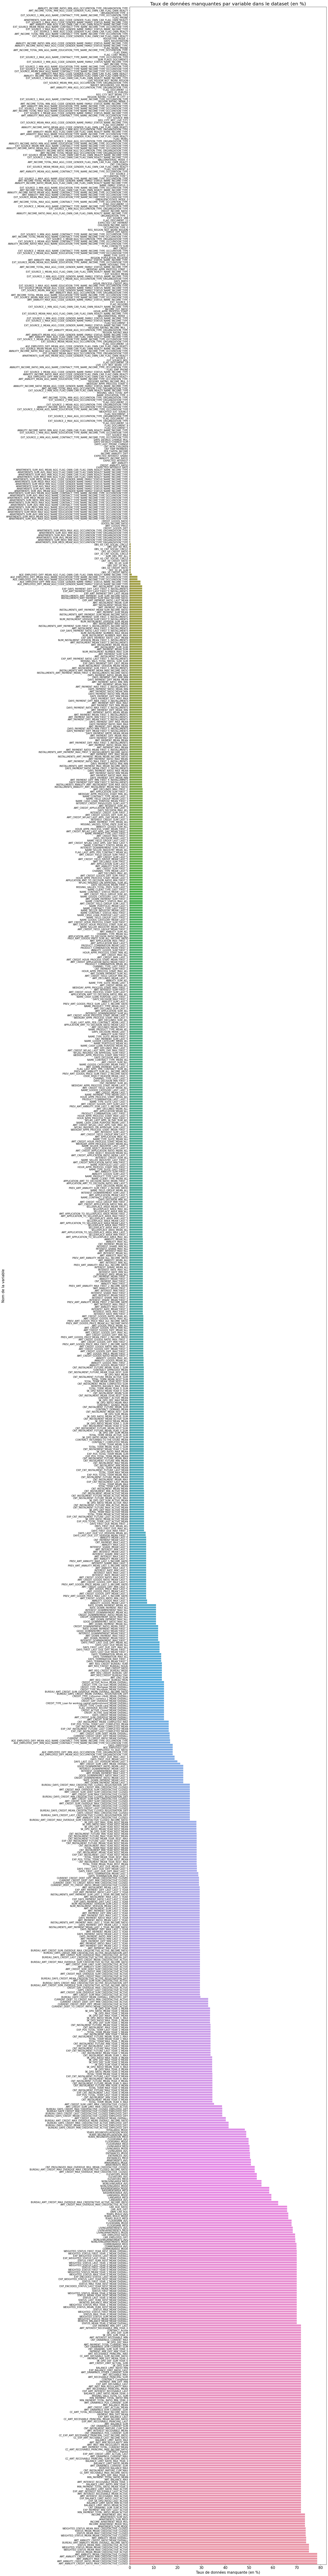

In [14]:
DataNaN = train_data.isna().sum().divide(train_data.shape[0]).multiply(100).sort_values(ascending = True)
    
plt.figure(figsize=(15, 200))
sns.barplot(x = DataNaN.values, y = DataNaN.index)
plt.xlabel('Taux de données manquante (en %)', fontsize = 15)
plt.ylabel('Nom de la variable', fontsize = 15)
plt.title('Taux de données manquantes par variable dans le dataset (en %)', fontsize = 20)
plt.tick_params(axis='x', which='major', labelsize=15)
plt.tick_params(axis='y', which='major', labelsize=10)
plt.show()

Pour la suite nous ne garderons que les variables avec moins de 60% de valeurs manquantes, au dessus nous n'aurons pas assez de valeurs pour avoir des valeurs de moyenne ou médiane qui colle vraiment à ce que nous avons et ça n'apportera pas d'infos au final.

In [15]:
def tauxDeNan_Affichage(dataset, variable):
    print('La variable', variable, 'contient', round((dataset[variable].isna().sum()/dataset.shape[0]) * 100, 2), '% de données manquantes.')


def tauxDeNan(dataset, variable):
    return round((dataset[variable].isna().sum()/dataset.shape[0])*100, 2)

In [16]:
listeVariableADrop = []

In [17]:
for variable in train_data.columns:
    if tauxDeNan(train_data, variable) > 60:
        listeVariableADrop.append(variable)

In [18]:
len(listeVariableADrop)

156

In [19]:
train_data.drop(listeVariableADrop, axis = 1, inplace = True)

In [20]:
train_data.shape

(307507, 941)

Enlevons ces mêmes variables à test_data, afin que nous puissions utiliser la table par la suite (afin qu'il n'y ait pas de problème de nombre de variable):  

In [21]:
test_data.drop(listeVariableADrop, axis = 1, inplace = True)

In [22]:
test_data.shape

(48744, 941)

Nous allons maintenant regarder les outliers, en fonction de ça nous appliquerons soit la moyenne, soit la médianne en remplacement des valeurs manquantes.

In [23]:
listeVariableAvecNaN = []

In [24]:
for variable in train_data.columns:
    if tauxDeNan(train_data, variable) > 0:
        listeVariableAvecNaN.append(variable)

In [25]:
len(listeVariableAvecNaN)

743

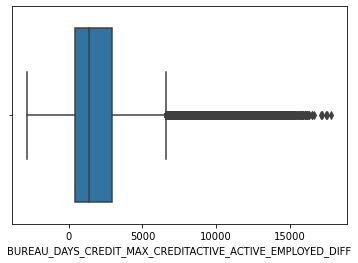

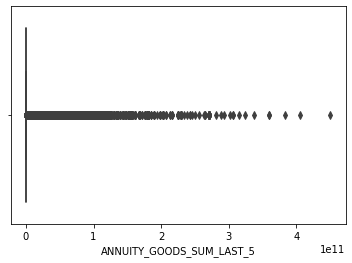

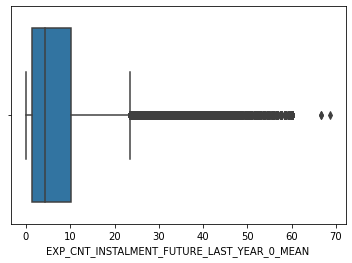

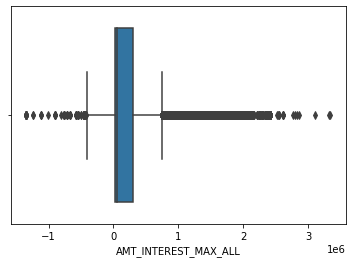

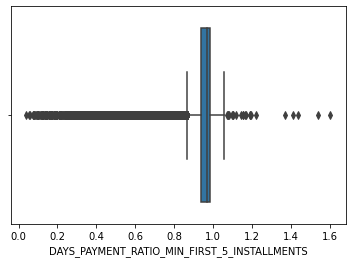

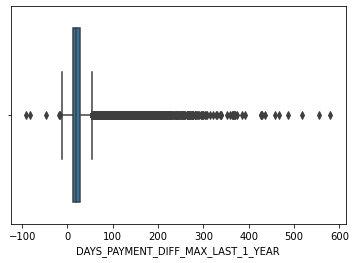

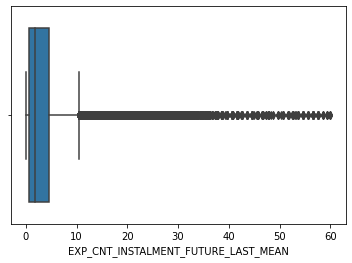

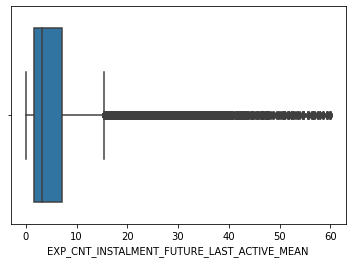

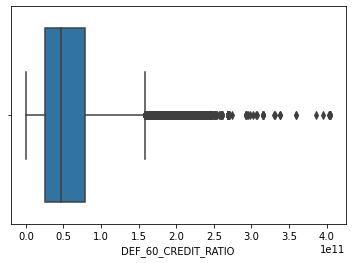

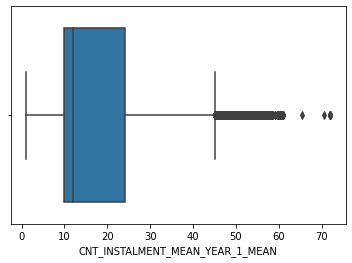

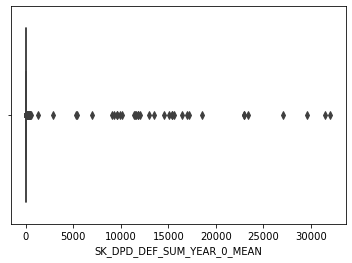

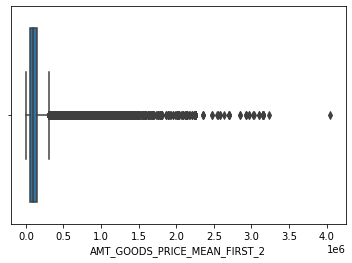

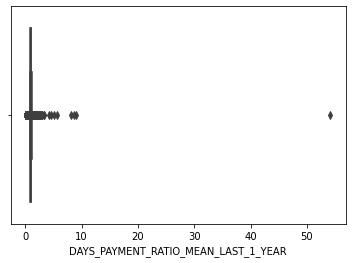

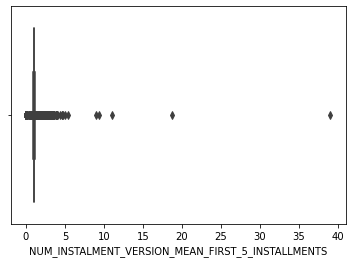

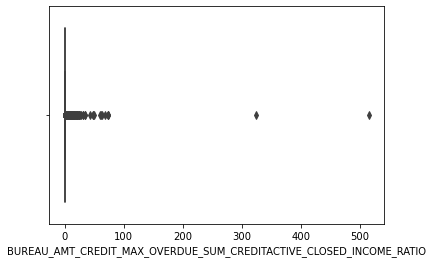

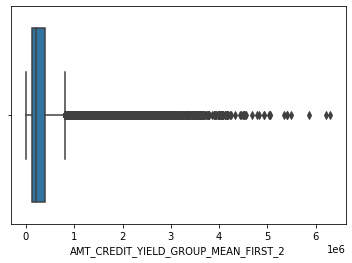

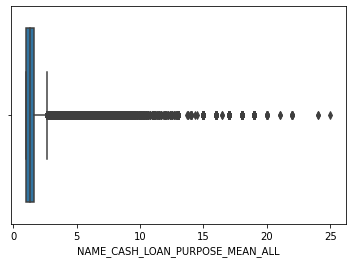

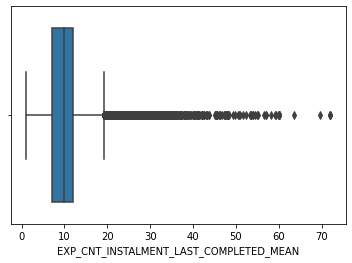

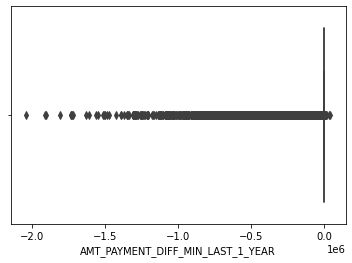

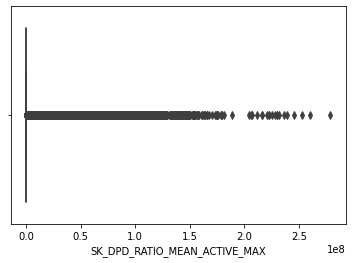

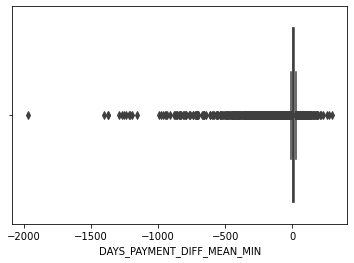

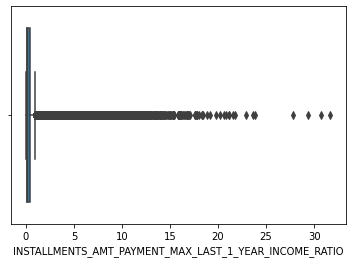

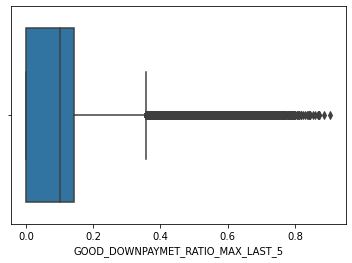

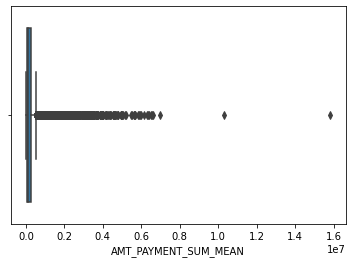

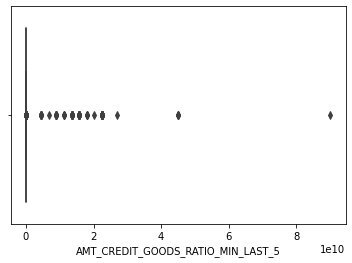

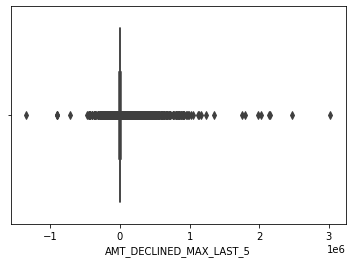

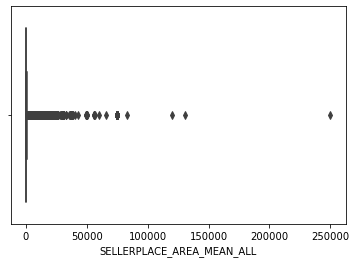

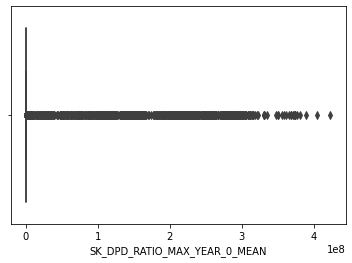

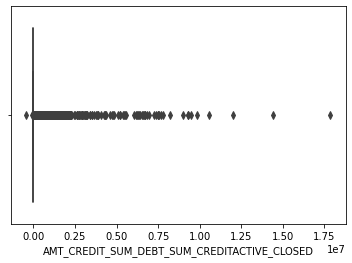

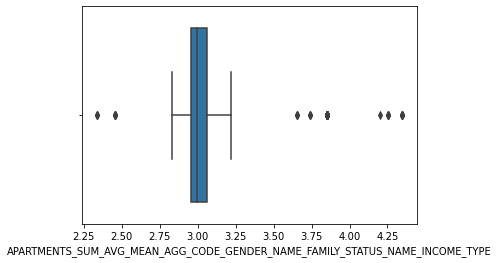

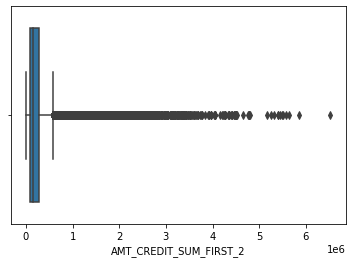

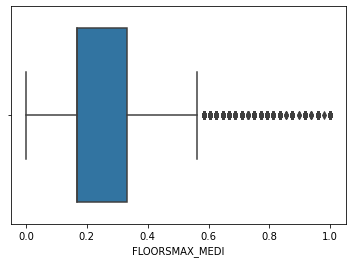

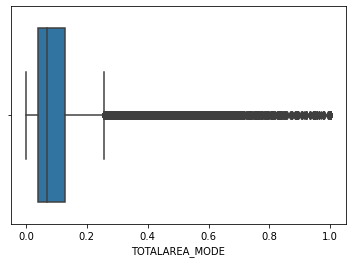

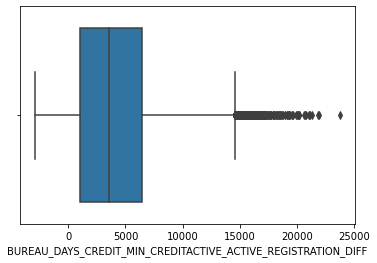

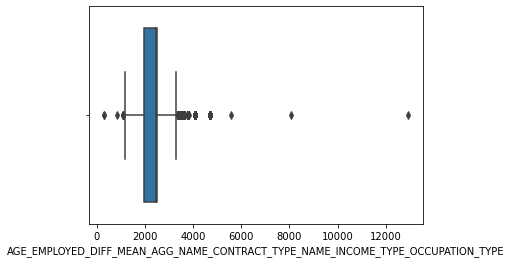

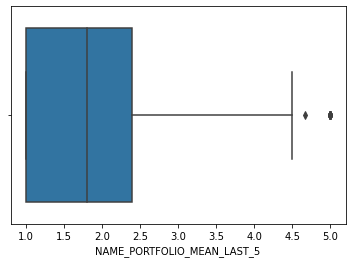

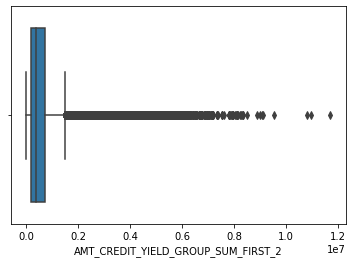

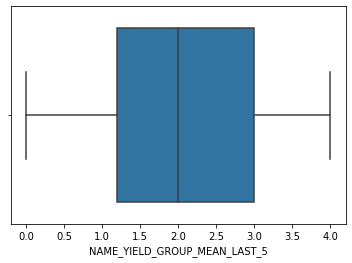

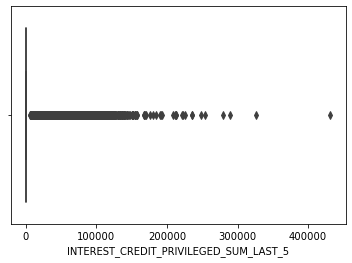

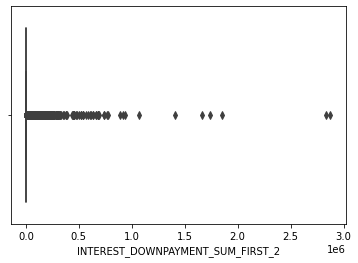

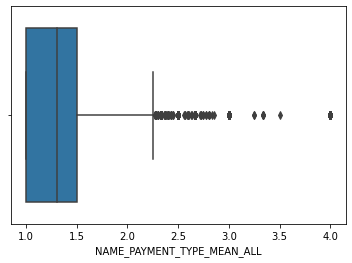

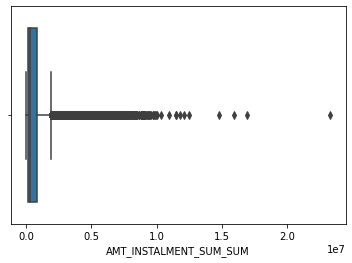

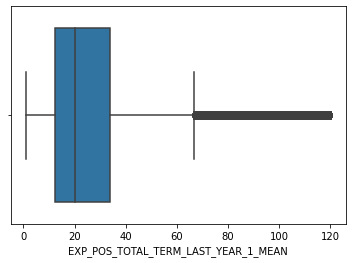

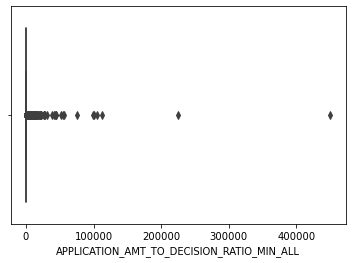

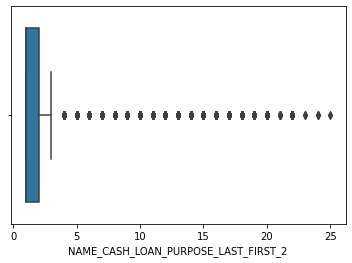

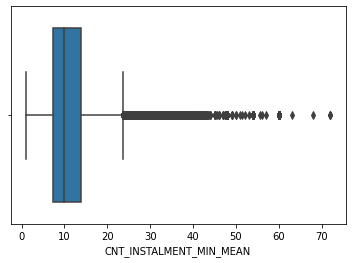

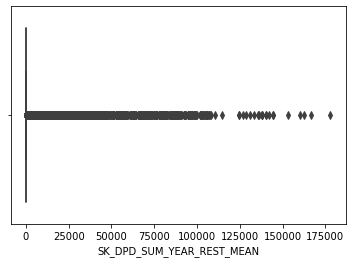

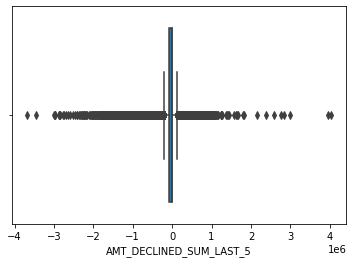

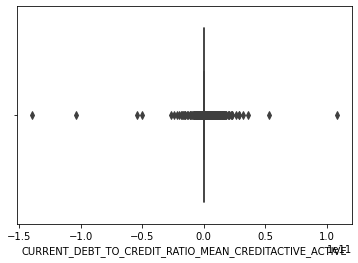

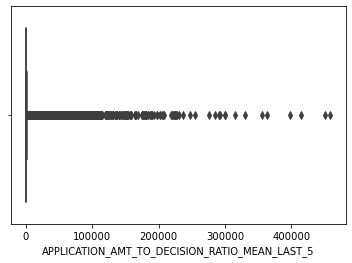

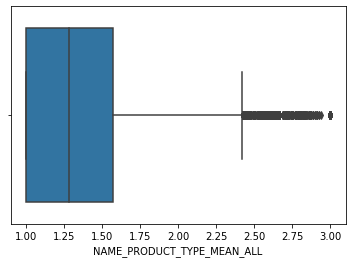

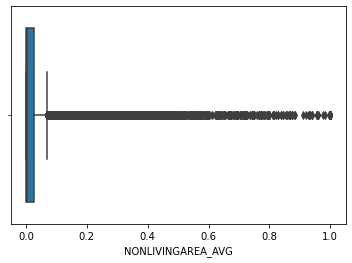

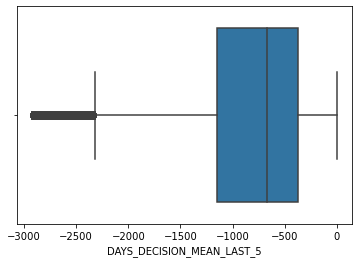

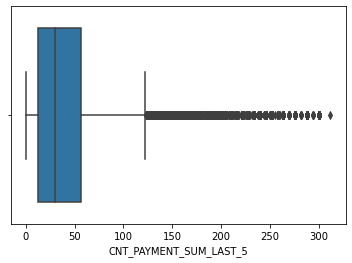

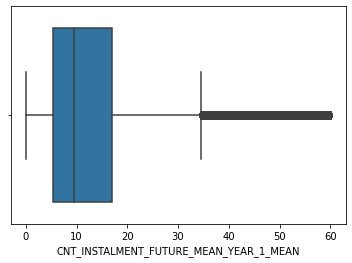

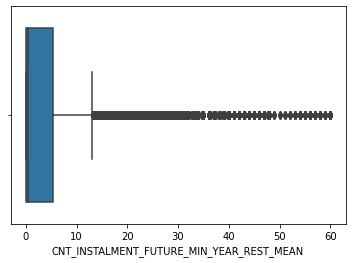

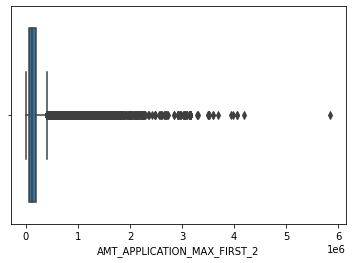

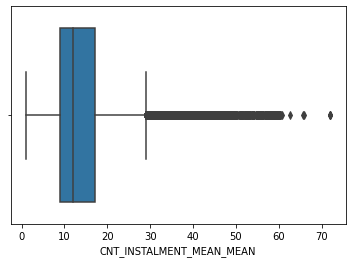

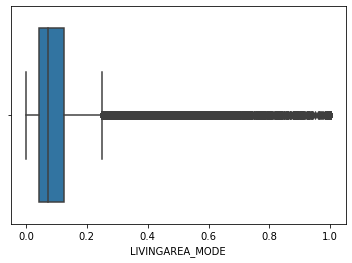

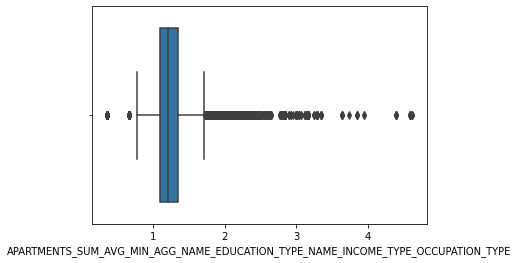

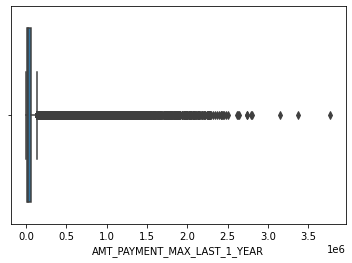

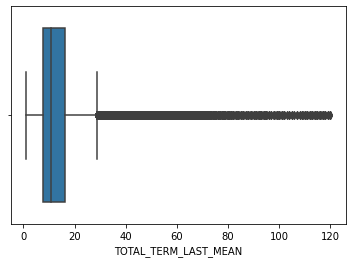

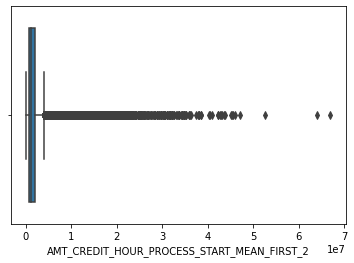

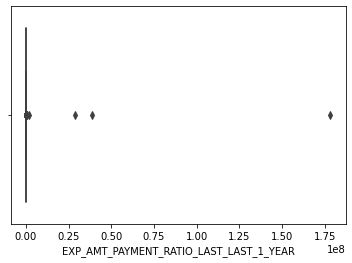

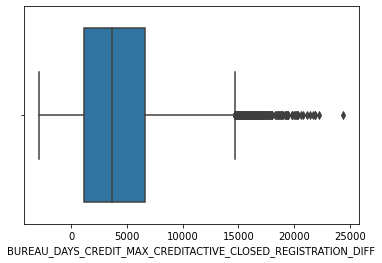

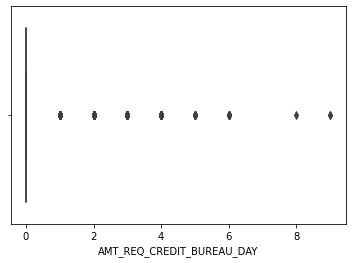

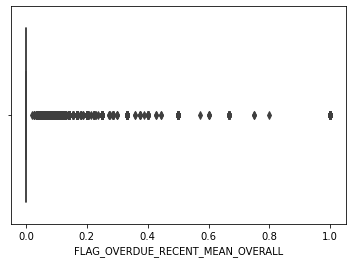

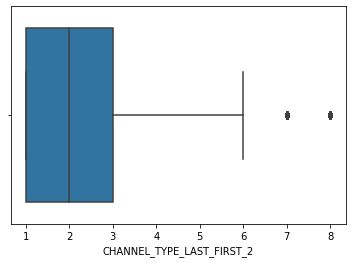

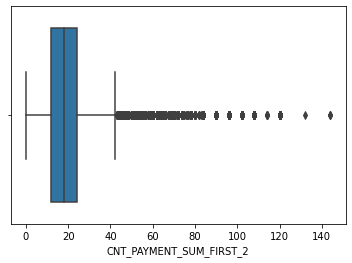

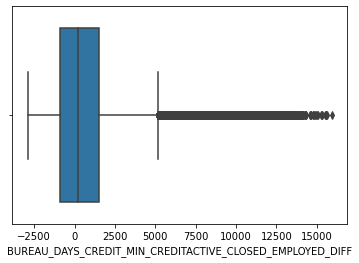

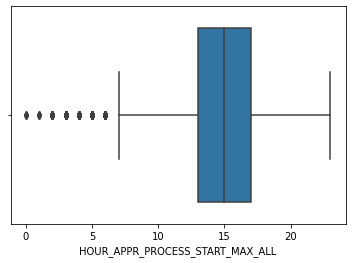

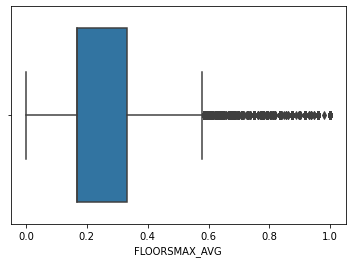

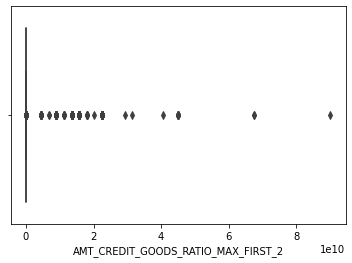

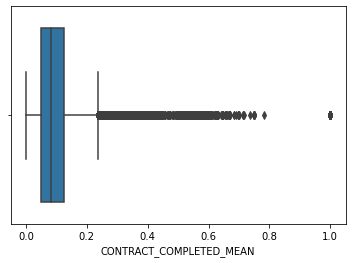

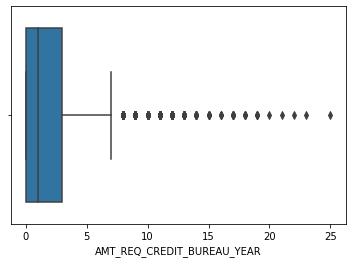

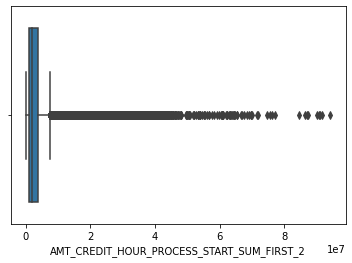

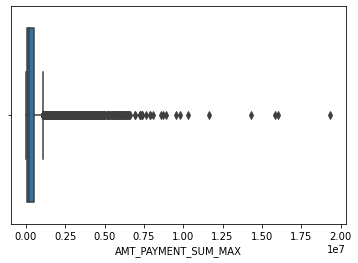

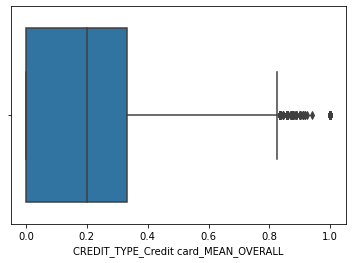

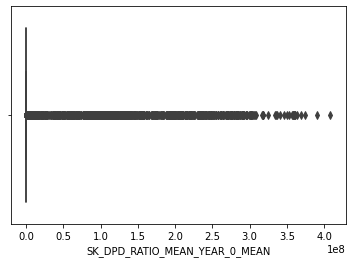

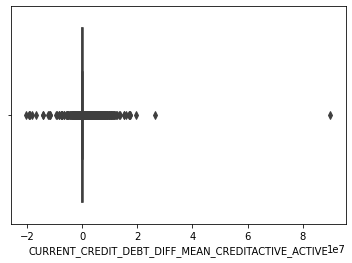

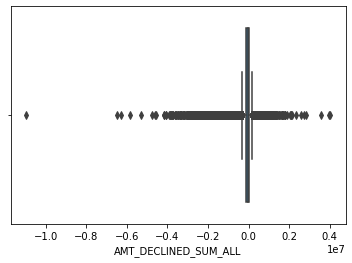

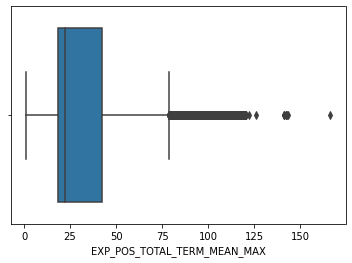

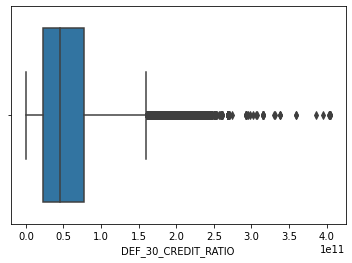

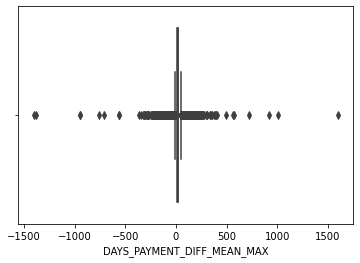

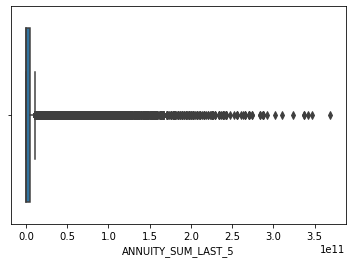

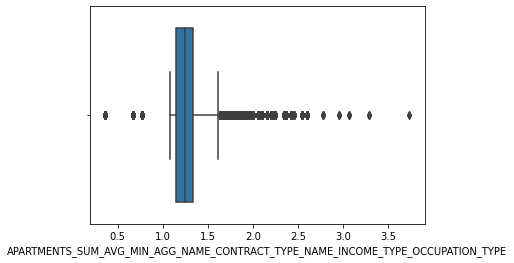

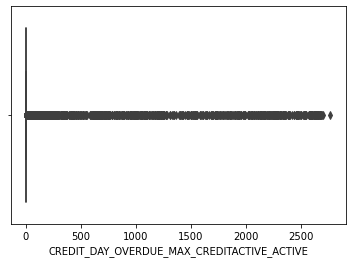

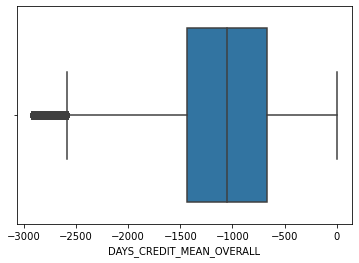

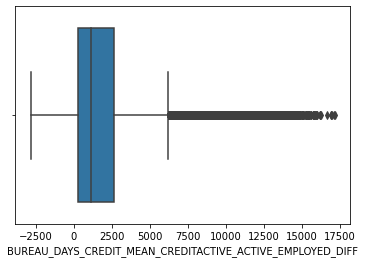

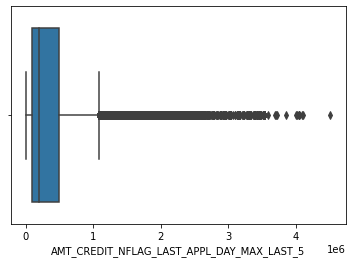

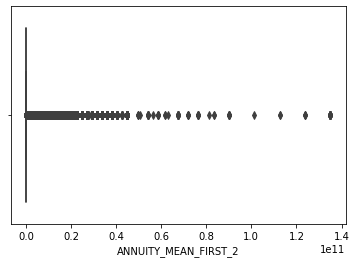

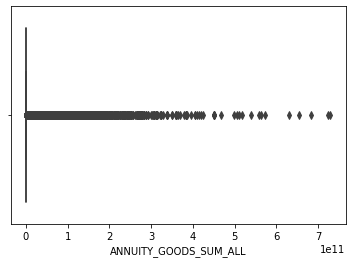

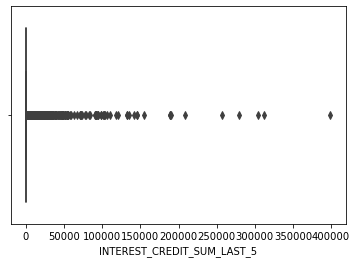

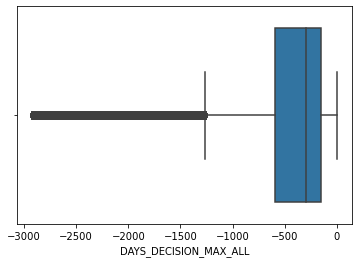

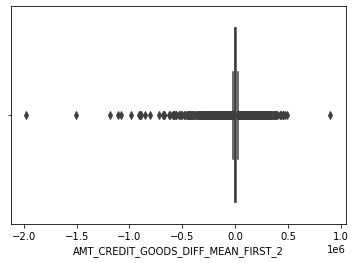

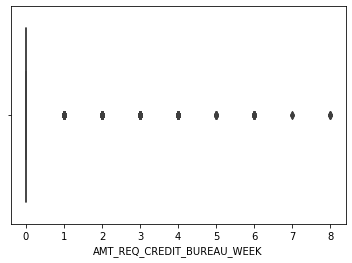

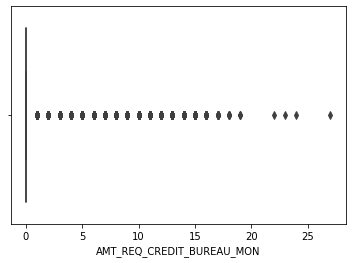

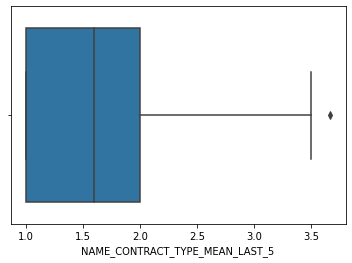

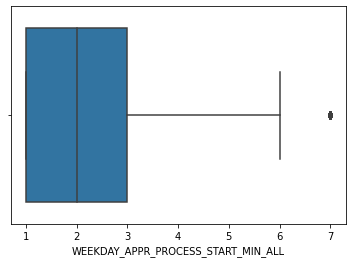

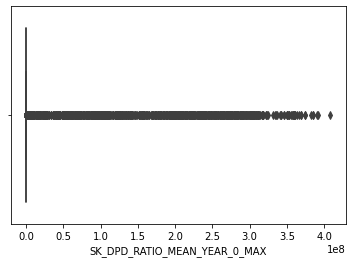

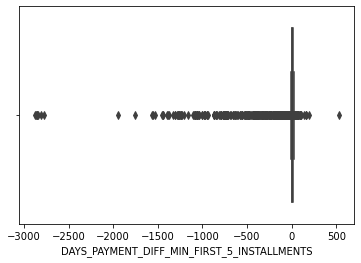

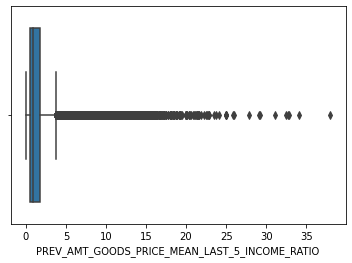

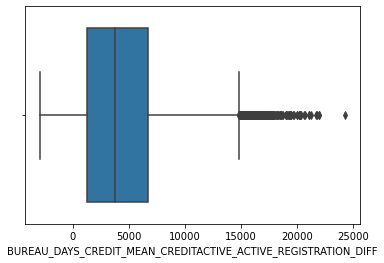

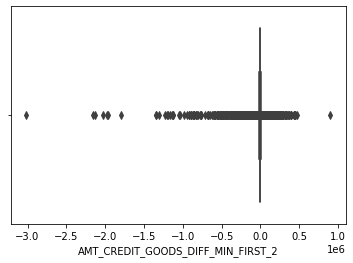

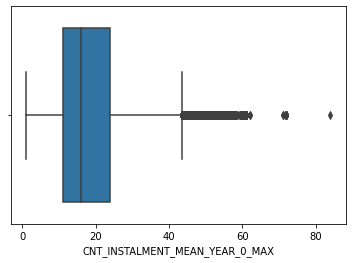

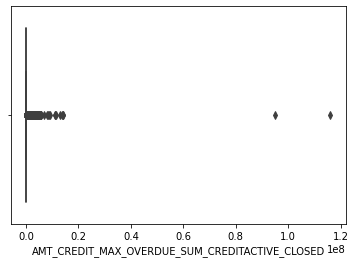

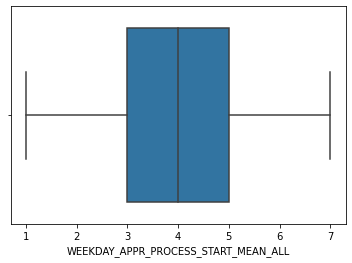

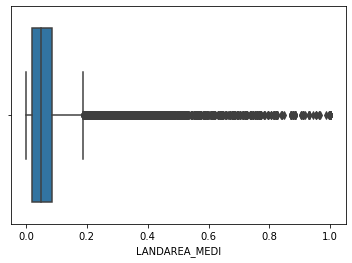

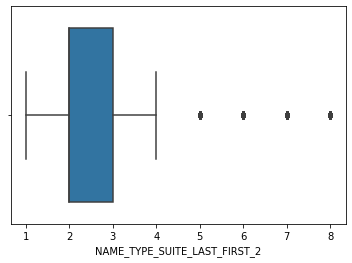

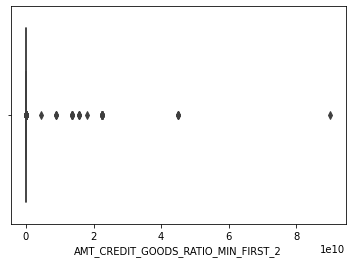

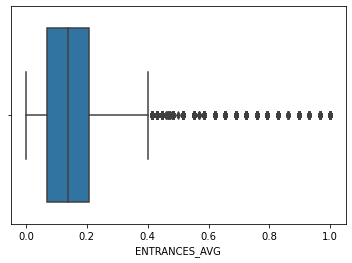

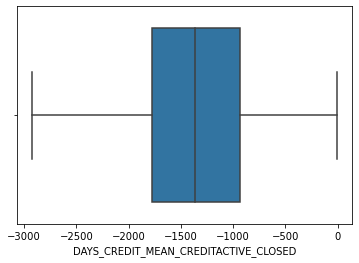

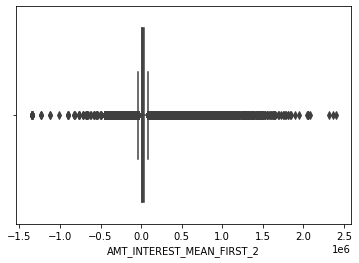

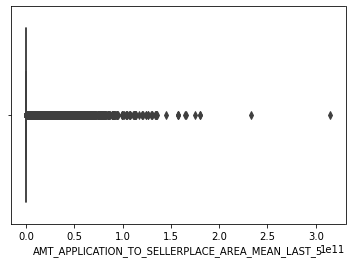

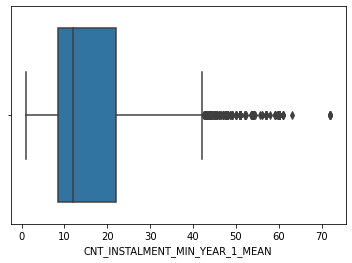

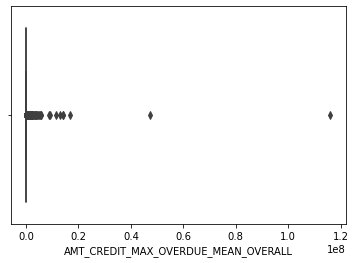

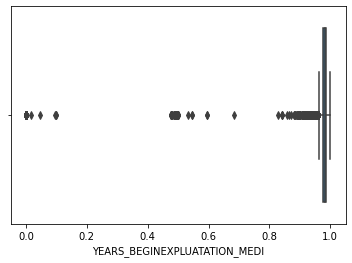

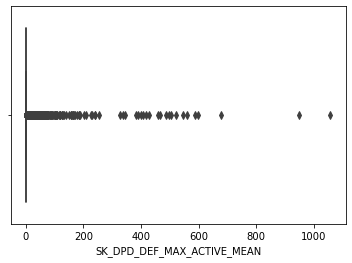

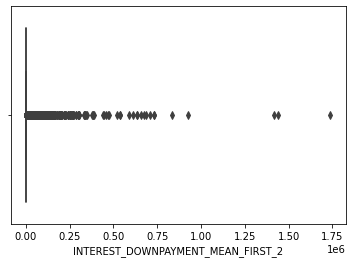

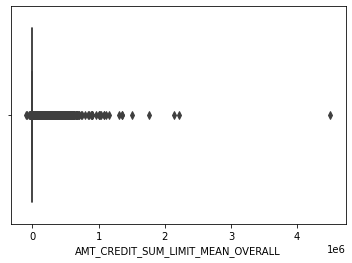

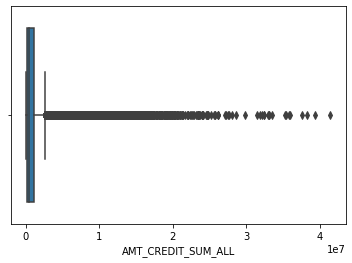

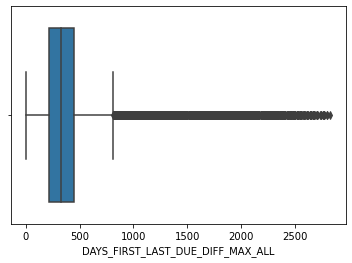

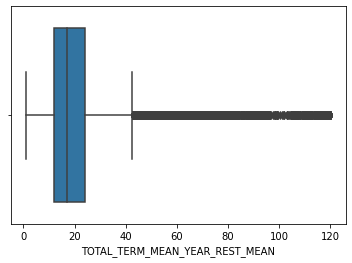

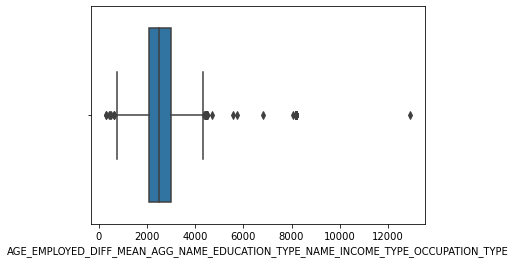

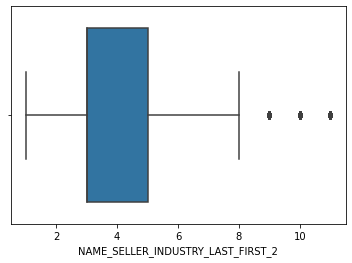

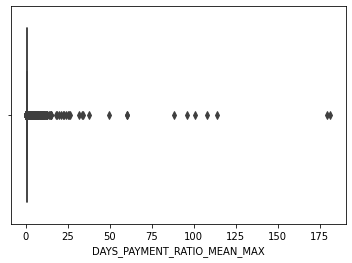

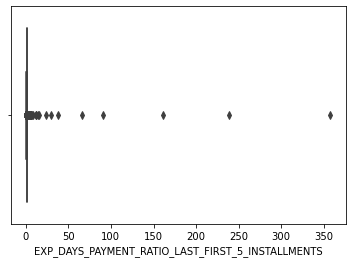

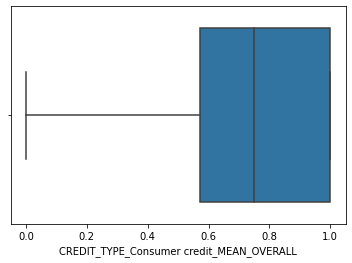

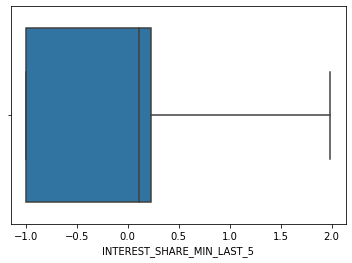

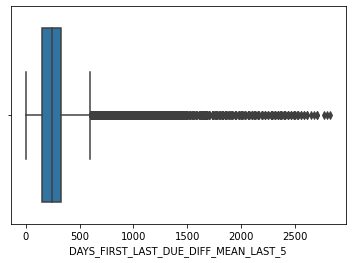

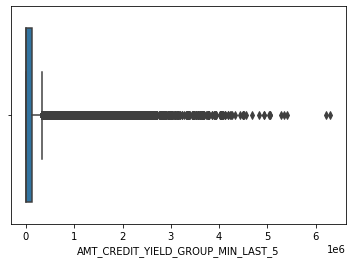

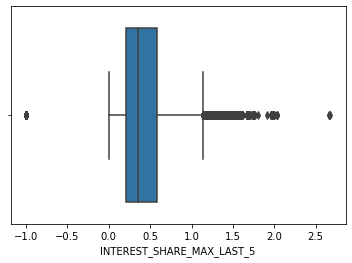

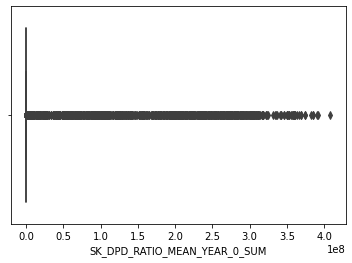

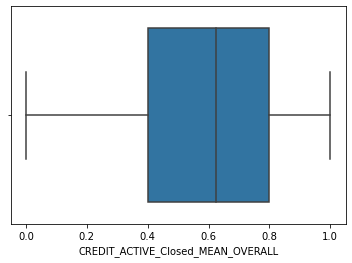

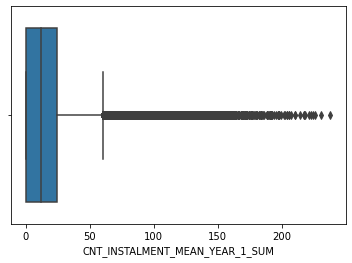

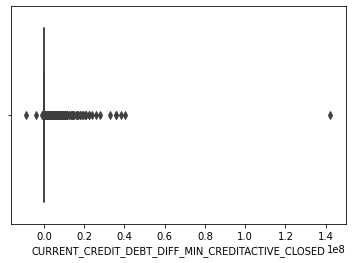

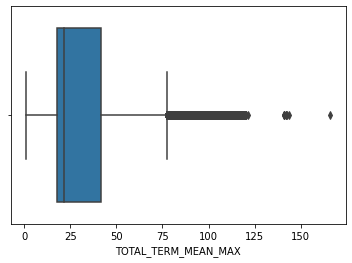

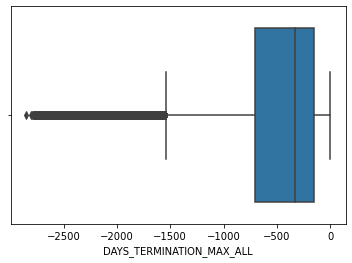

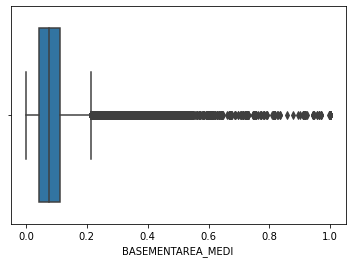

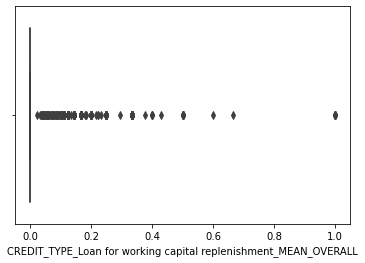

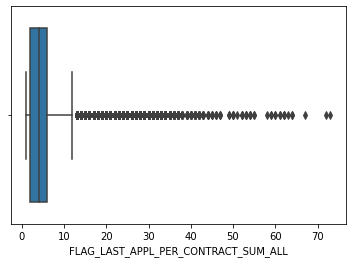

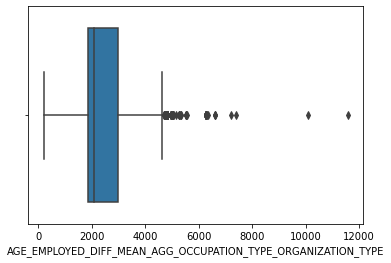

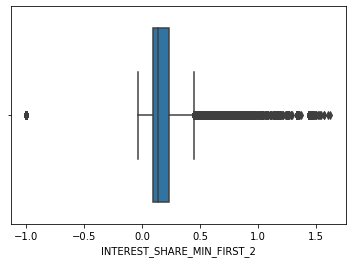

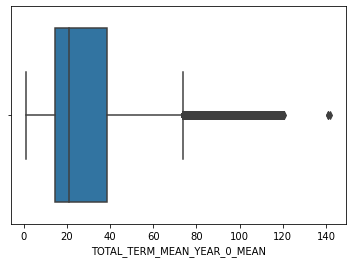

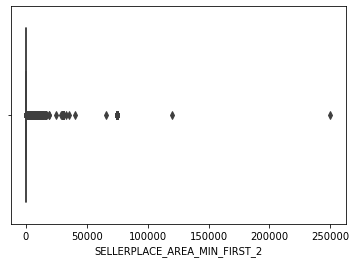

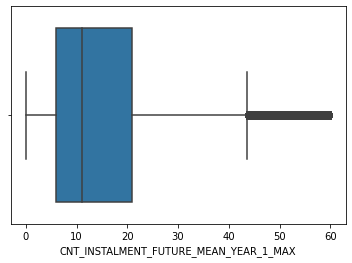

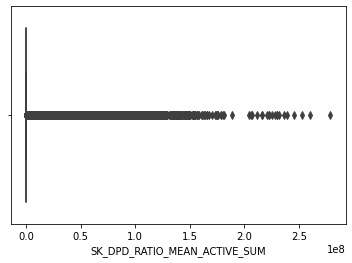

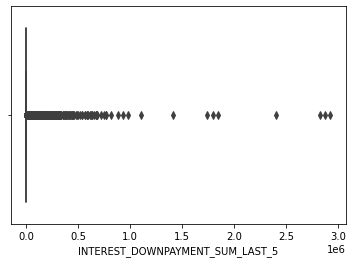

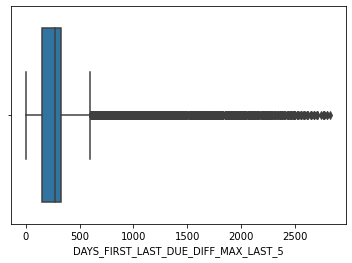

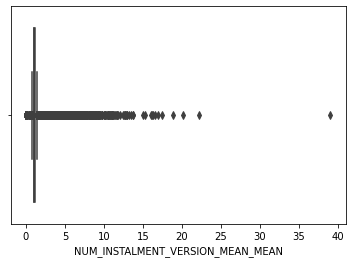

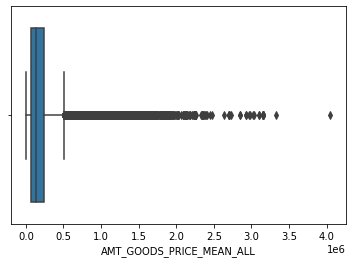

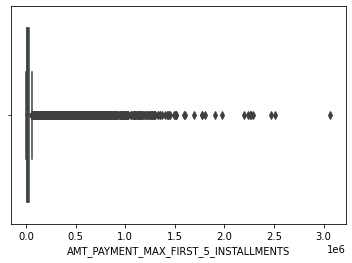

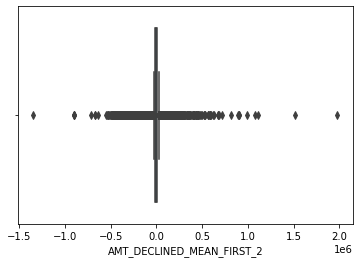

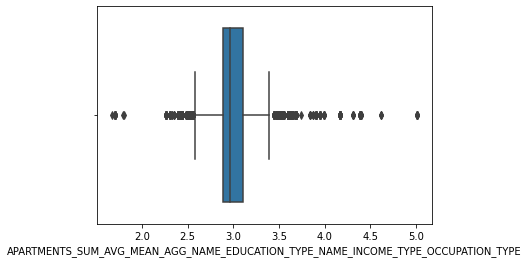

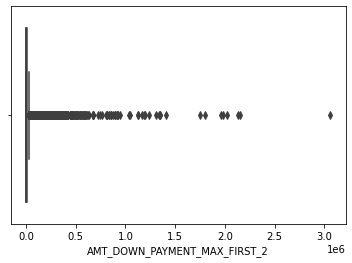

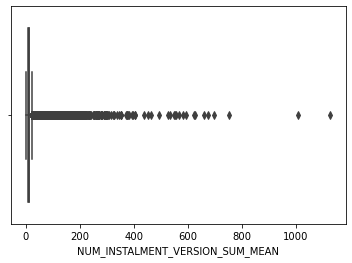

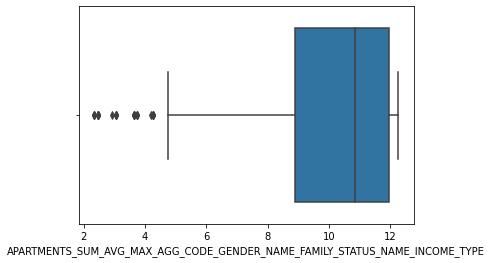

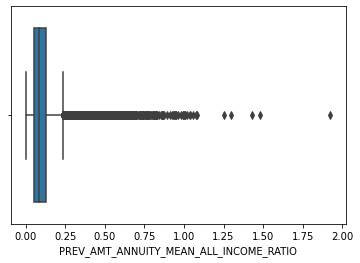

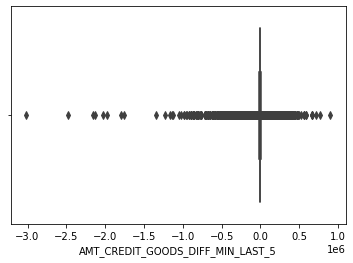

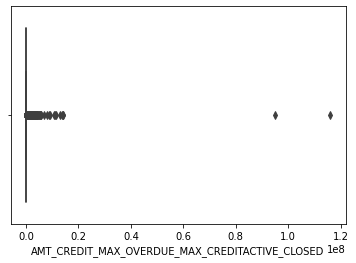

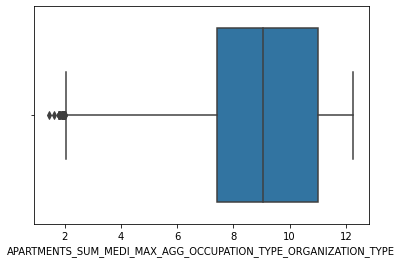

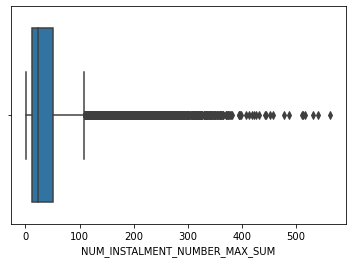

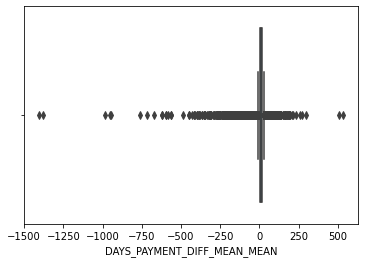

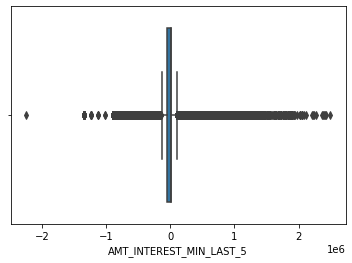

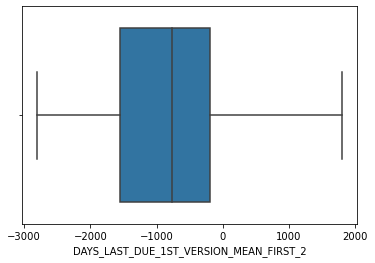

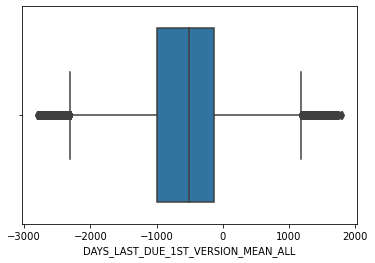

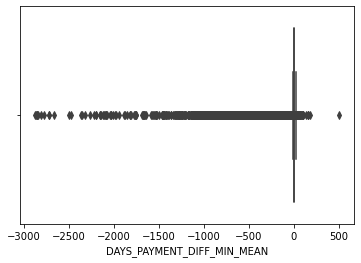

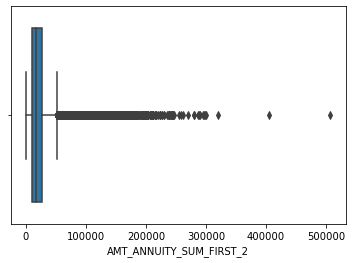

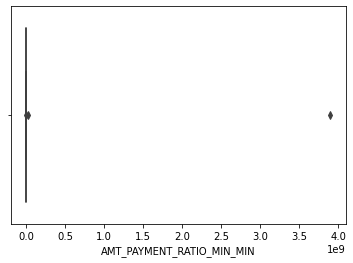

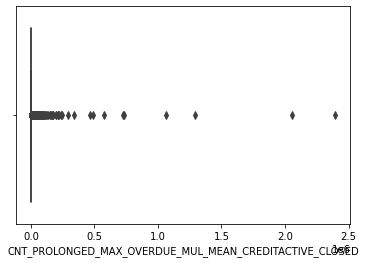

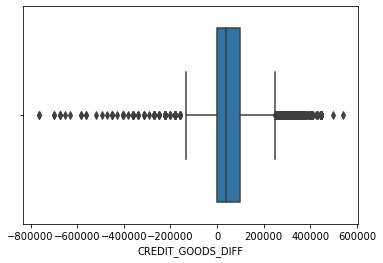

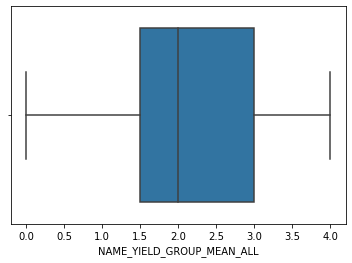

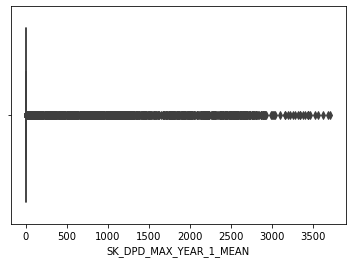

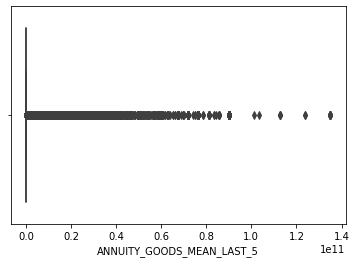

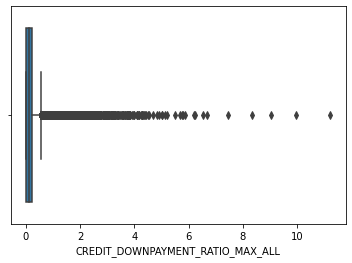

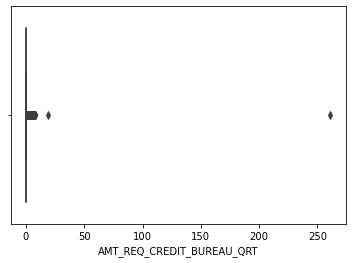

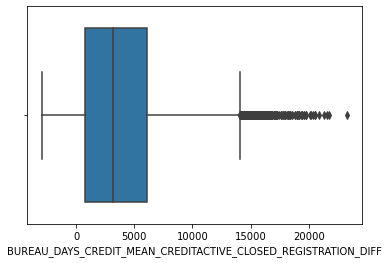

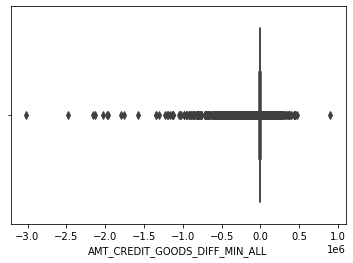

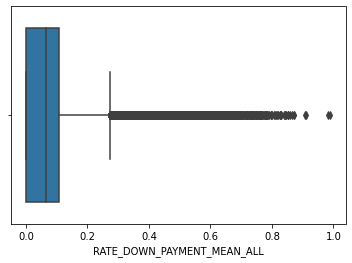

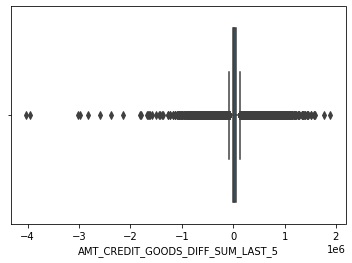

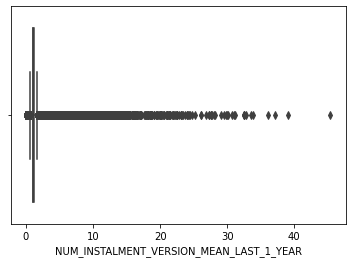

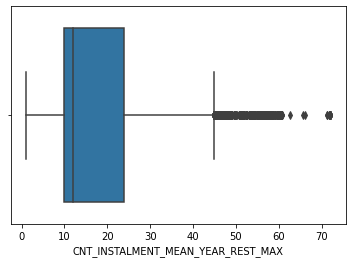

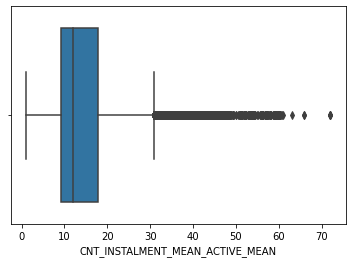

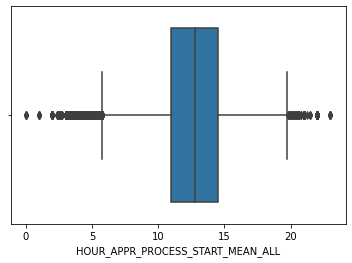

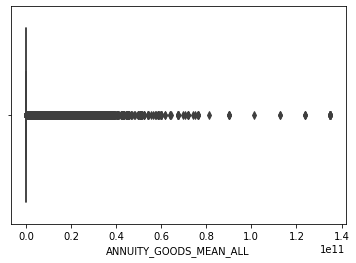

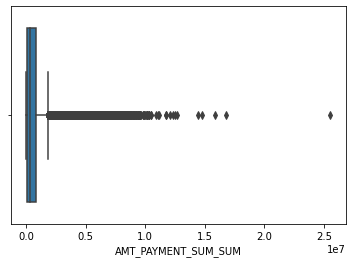

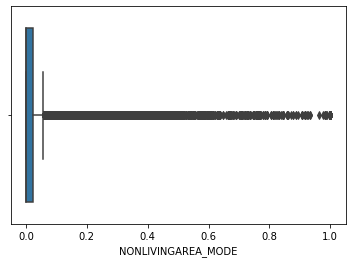

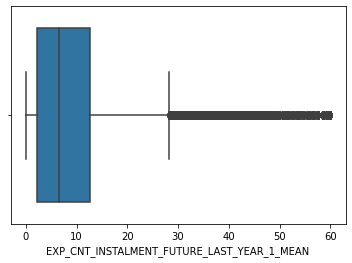

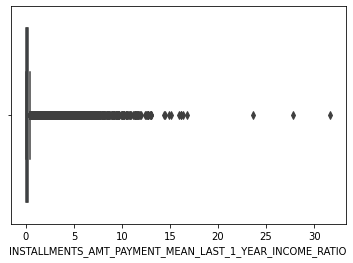

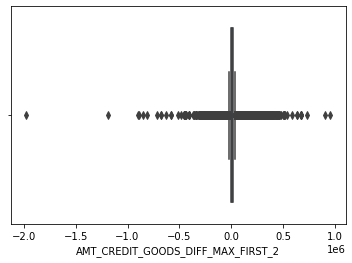

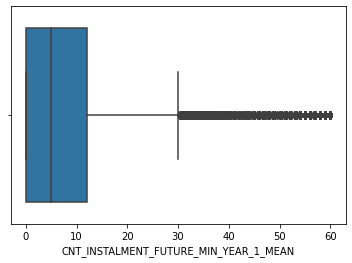

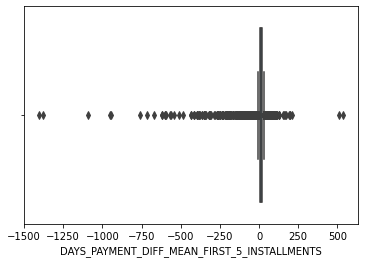

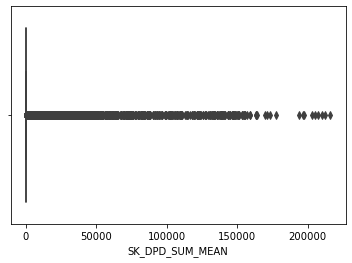

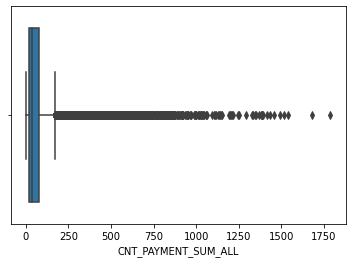

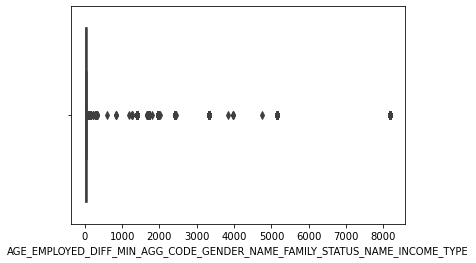

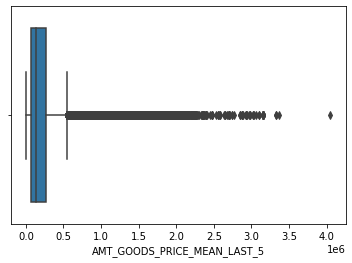

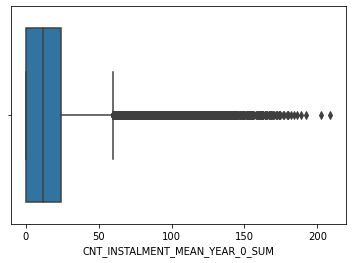

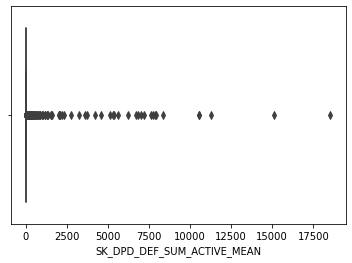

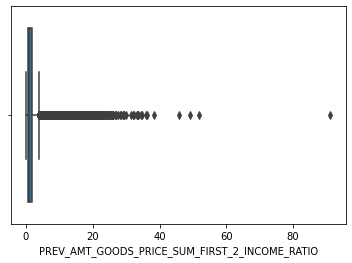

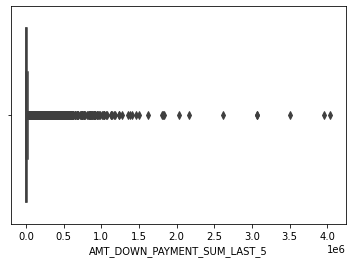

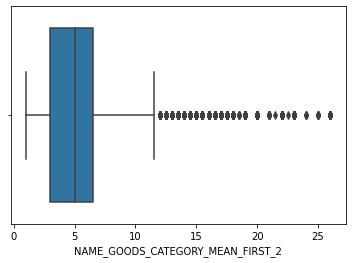

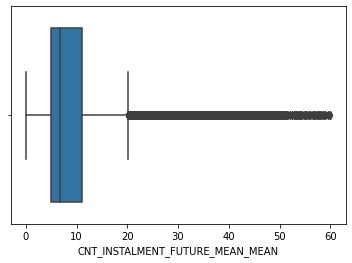

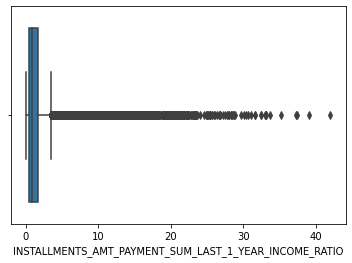

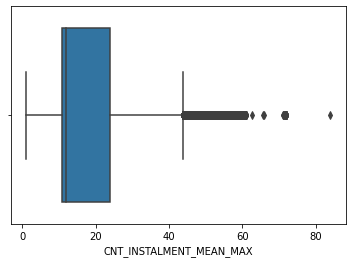

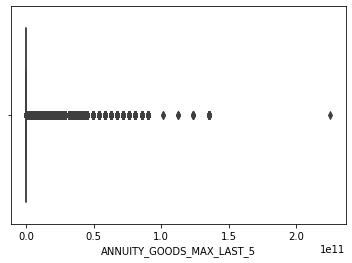

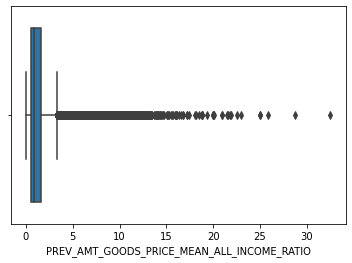

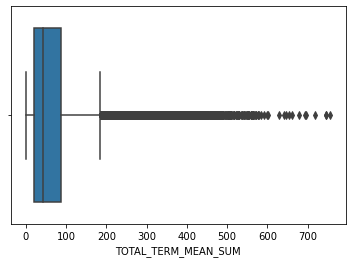

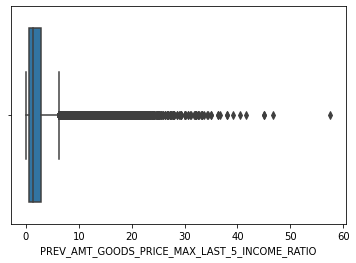

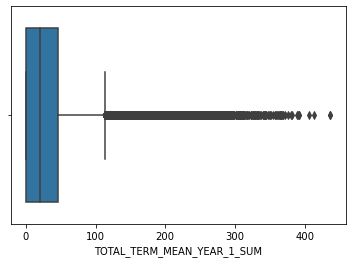

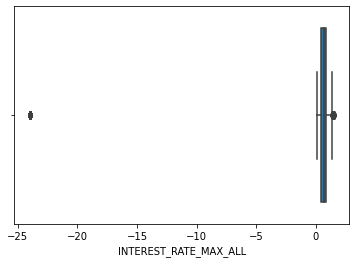

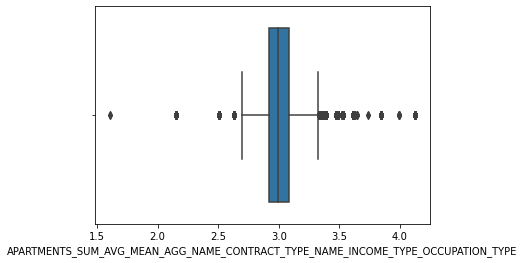

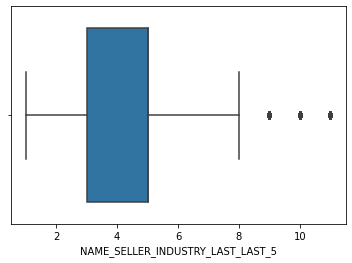

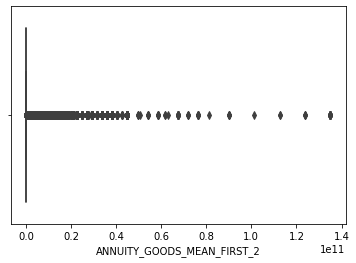

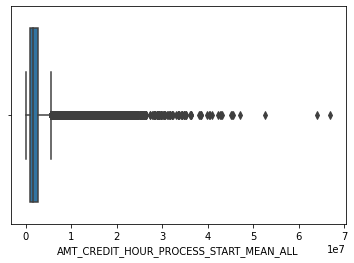

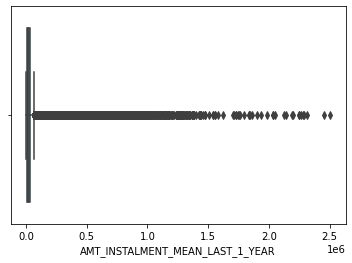

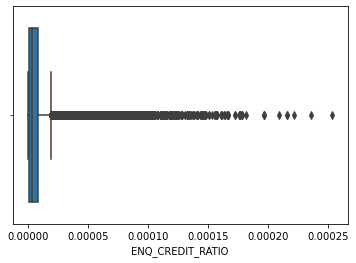

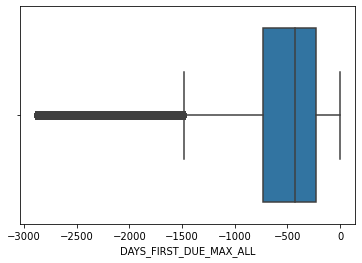

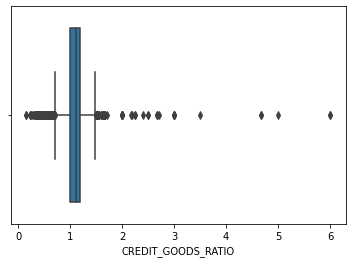

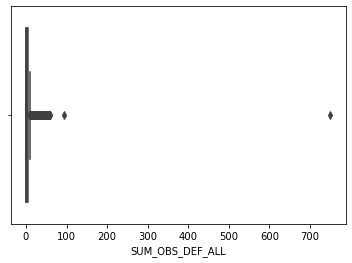

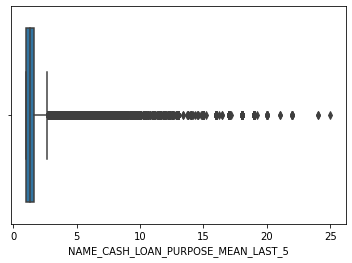

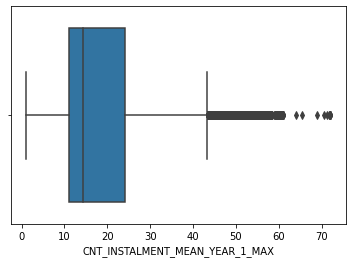

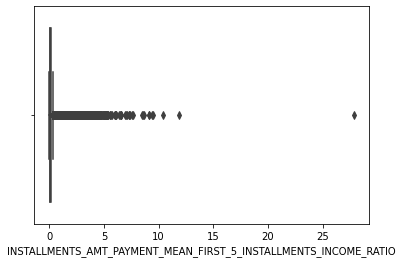

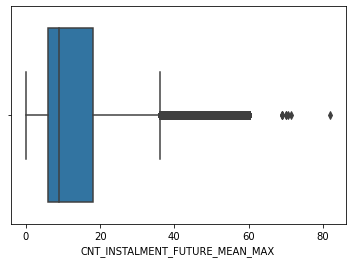

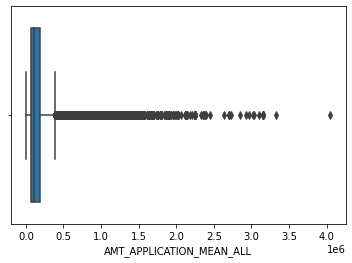

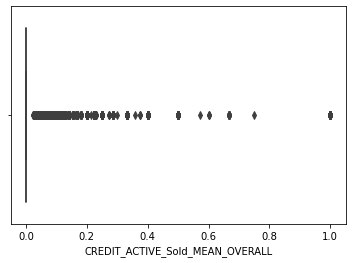

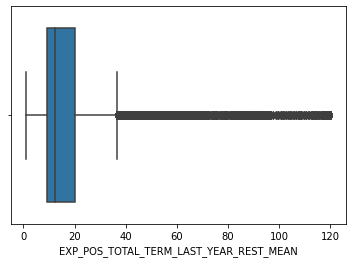

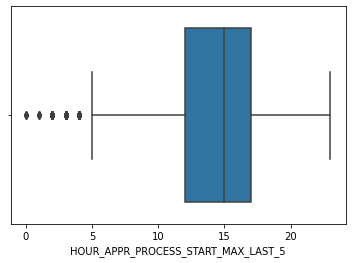

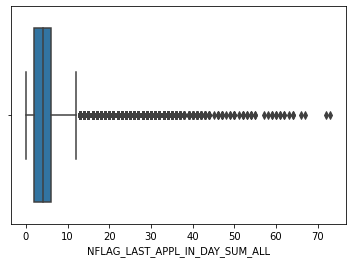

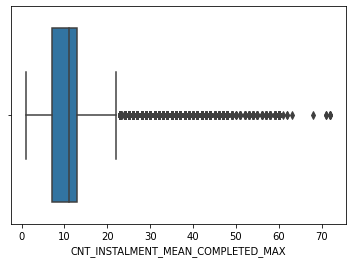

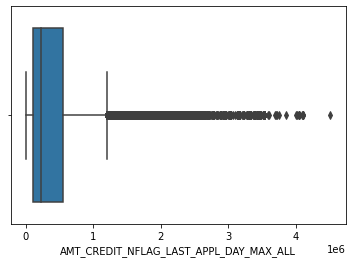

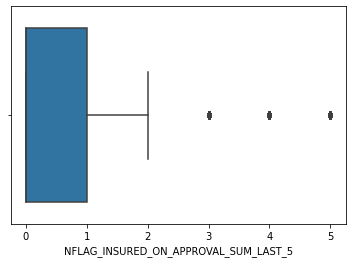

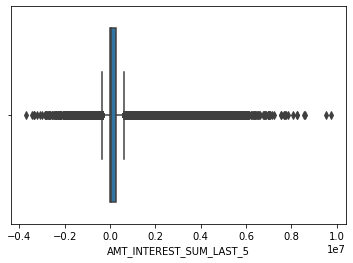

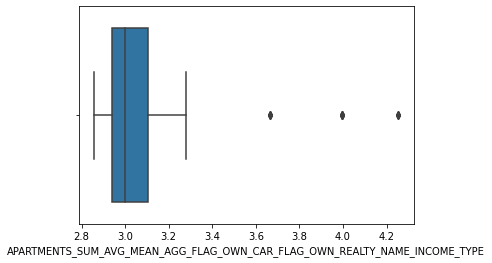

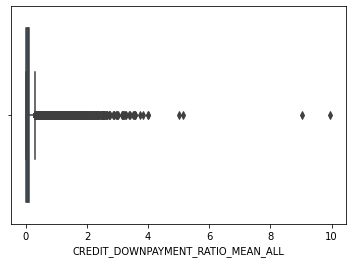

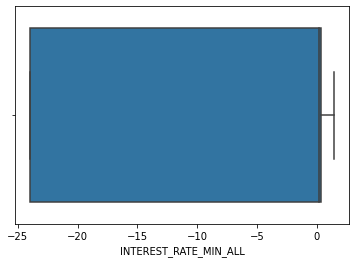

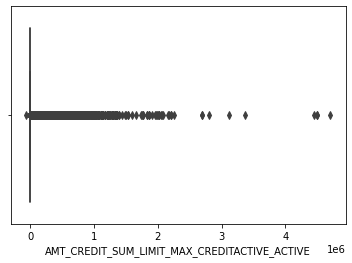

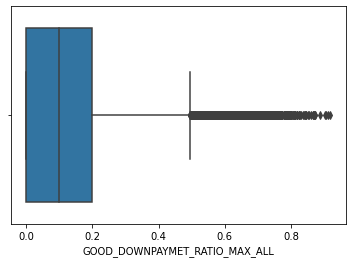

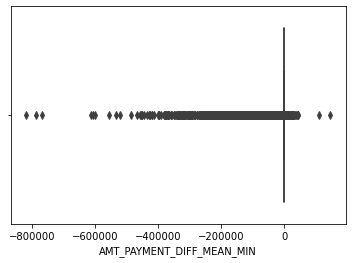

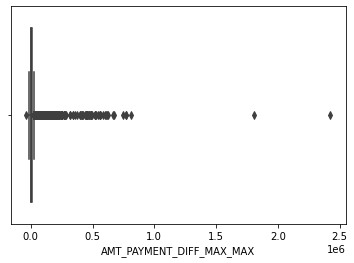

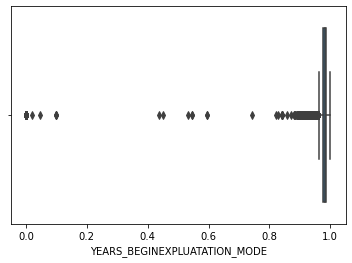

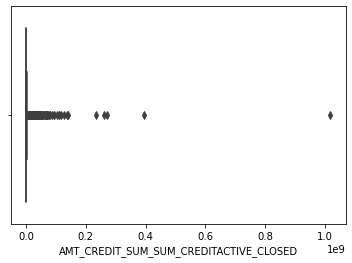

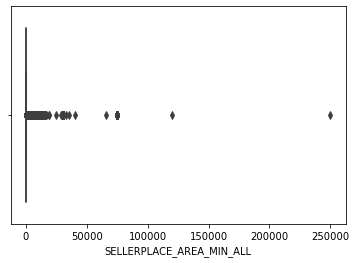

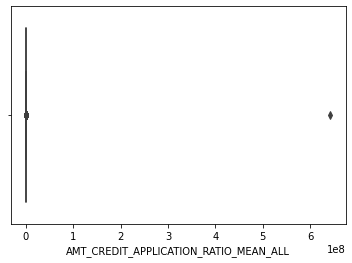

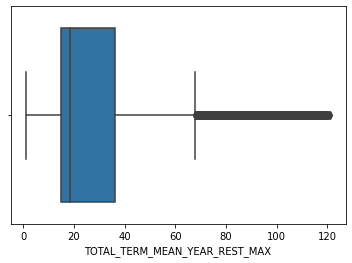

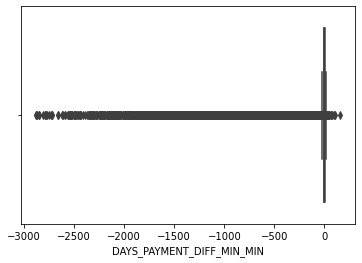

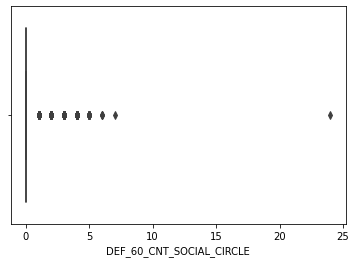

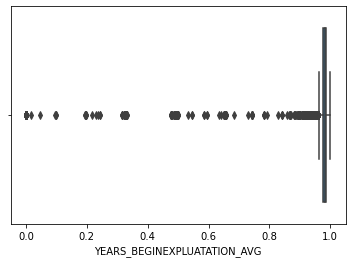

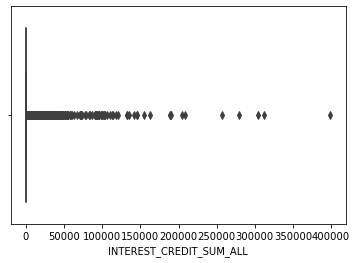

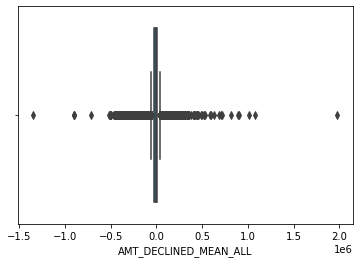

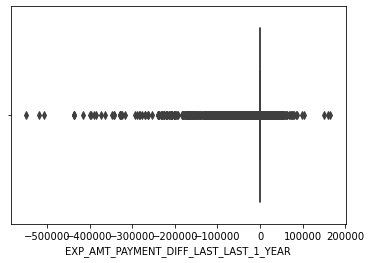

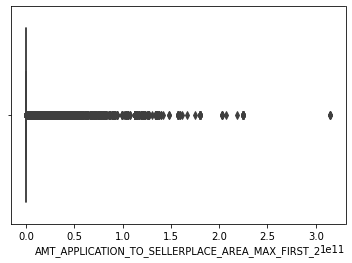

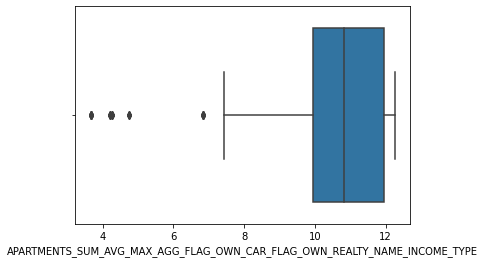

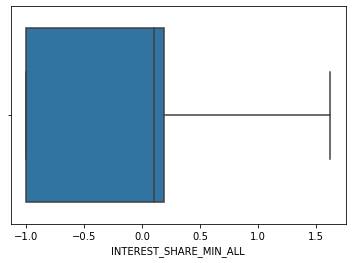

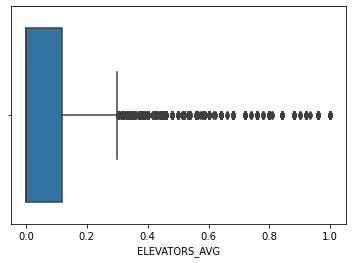

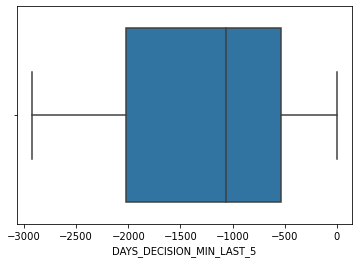

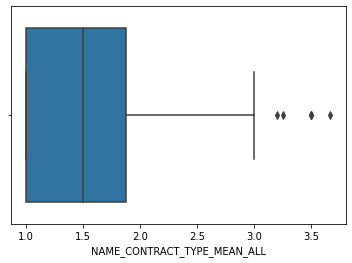

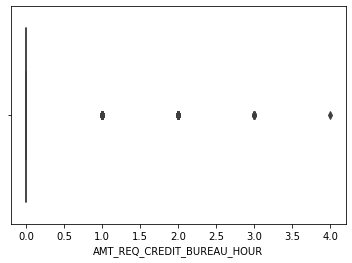

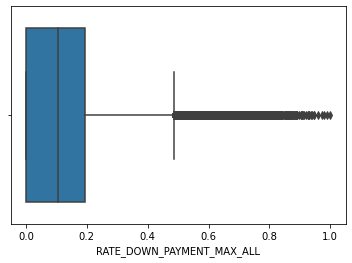

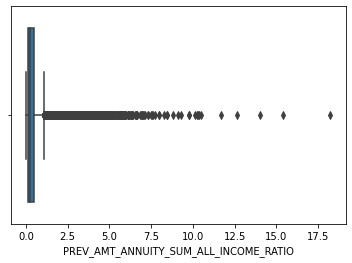

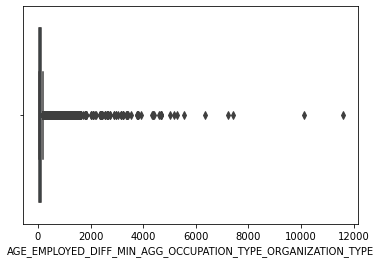

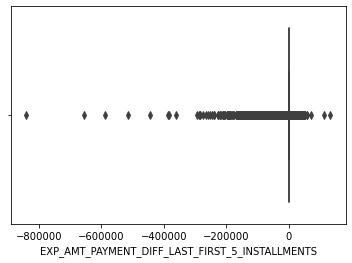

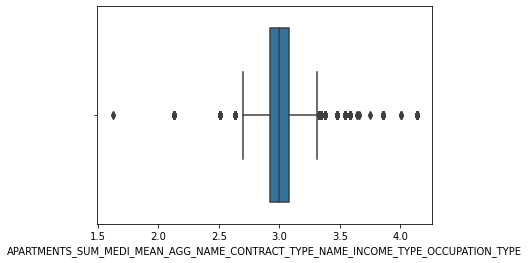

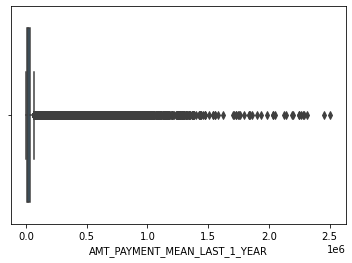

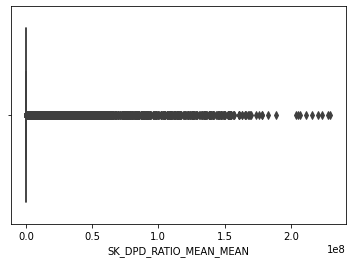

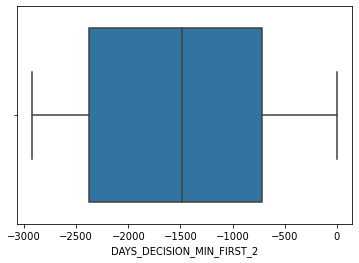

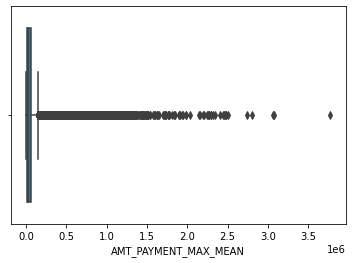

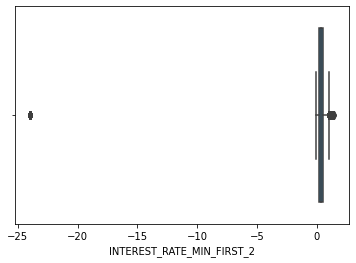

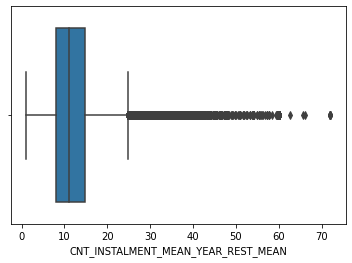

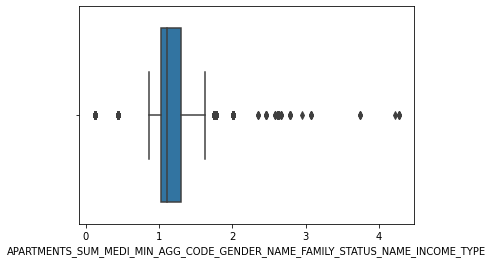

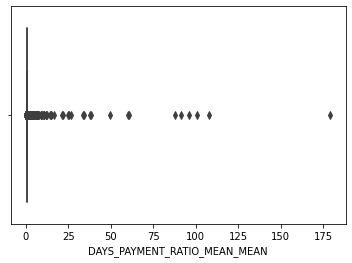

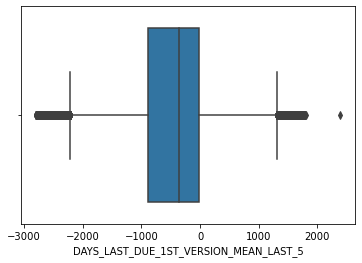

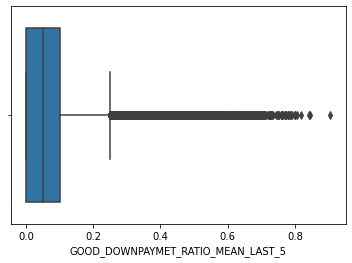

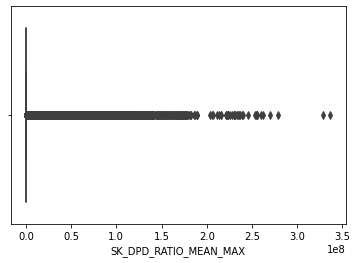

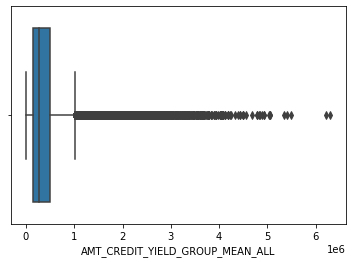

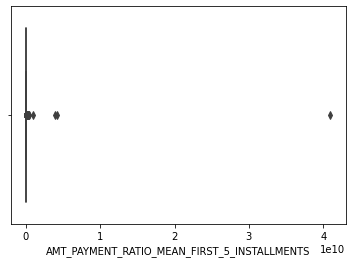

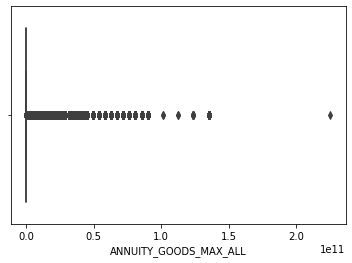

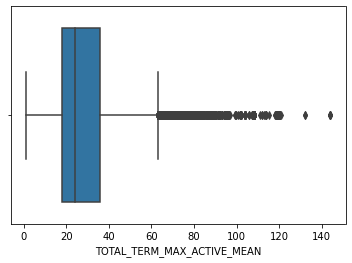

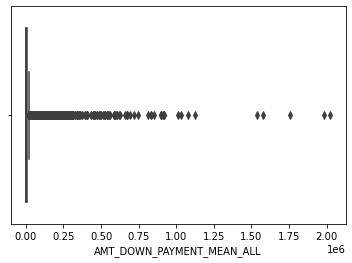

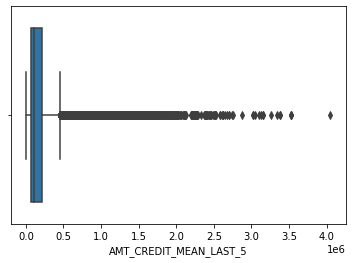

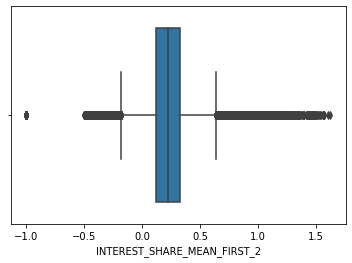

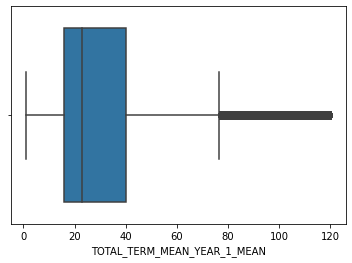

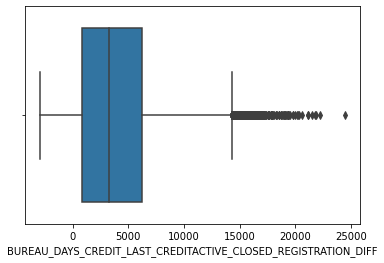

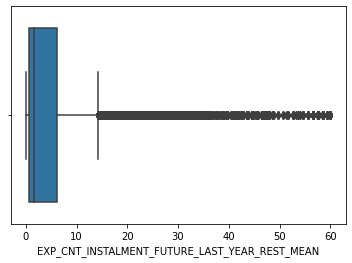

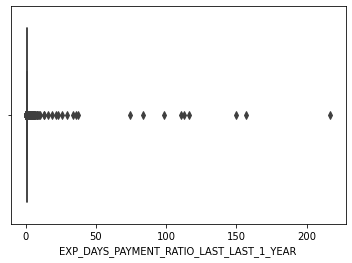

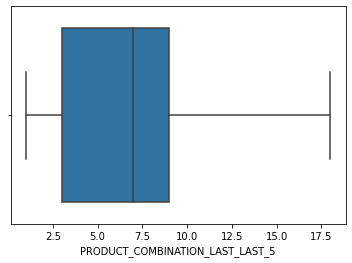

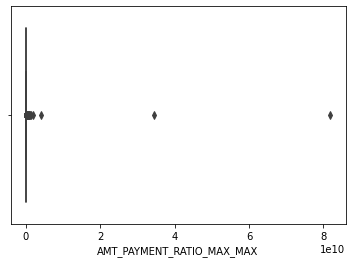

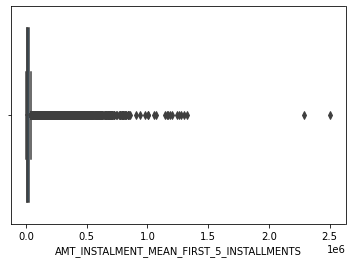

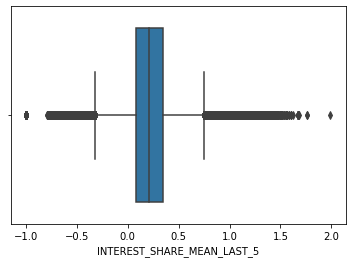

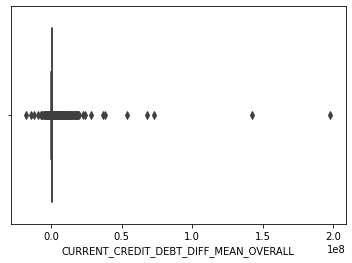

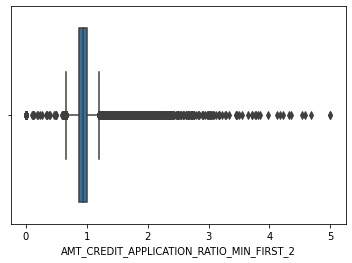

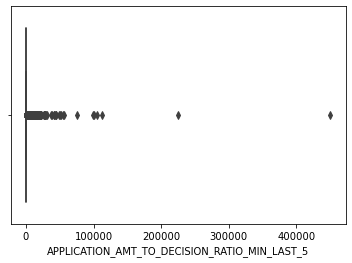

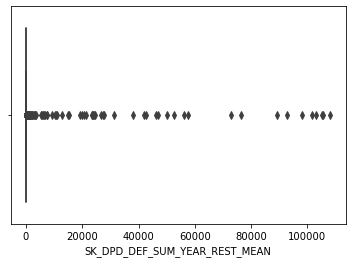

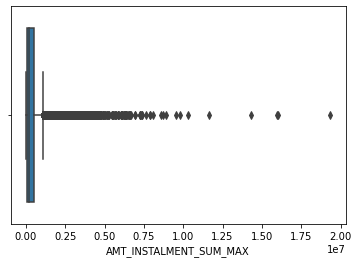

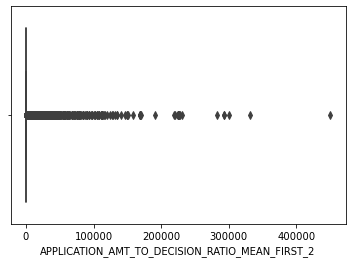

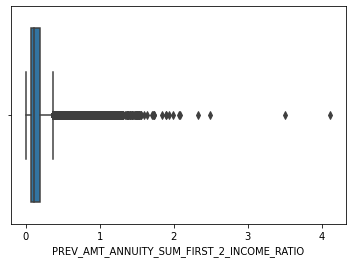

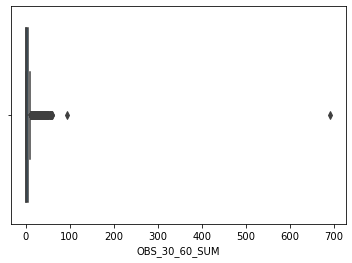

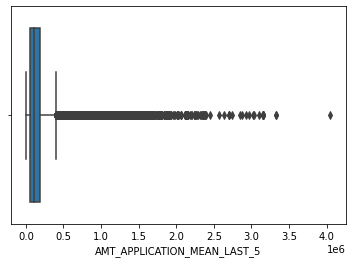

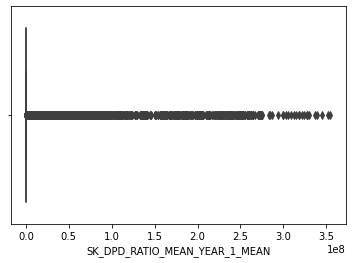

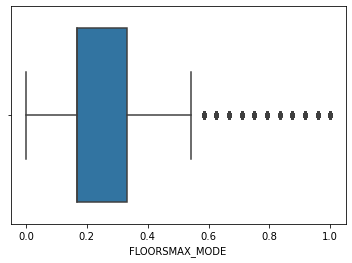

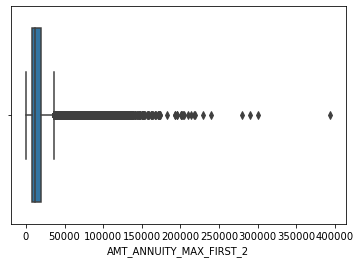

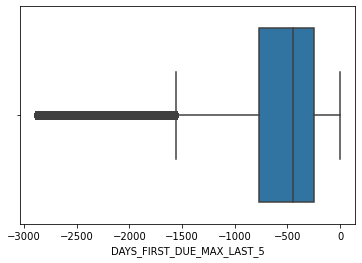

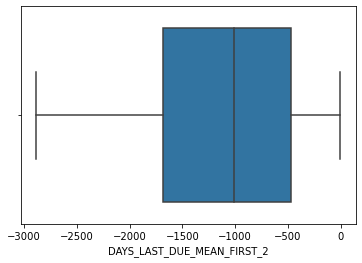

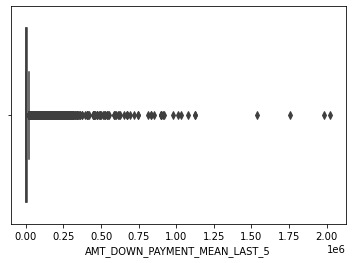

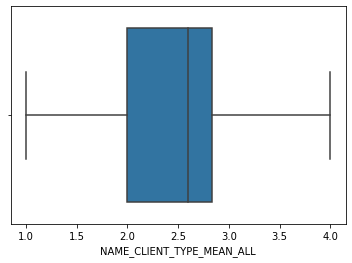

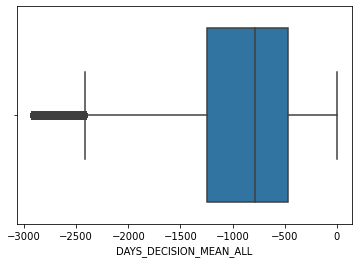

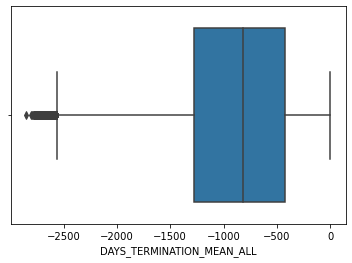

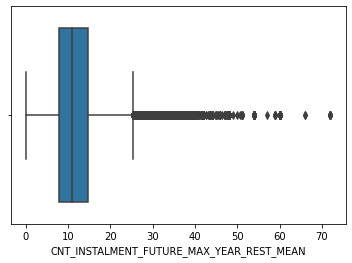

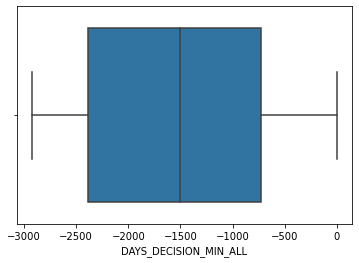

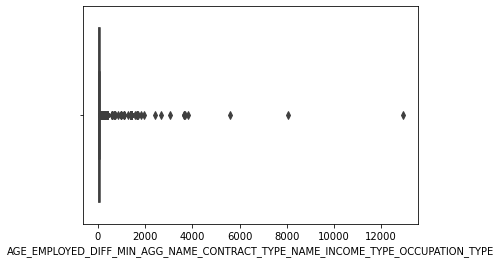

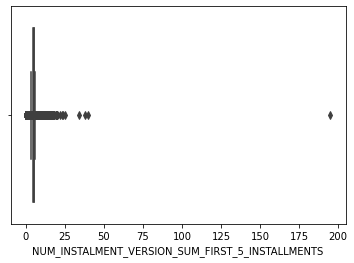

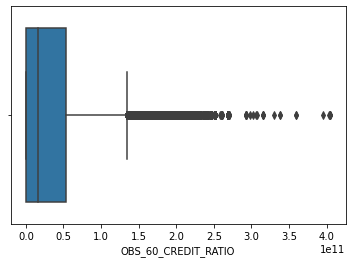

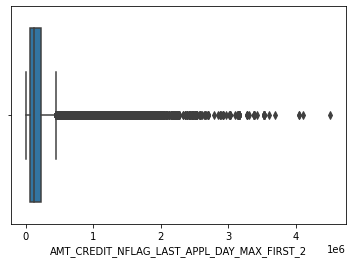

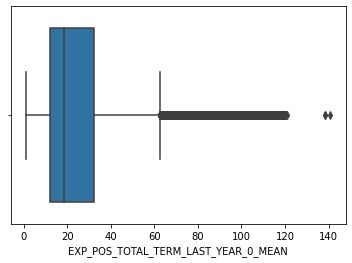

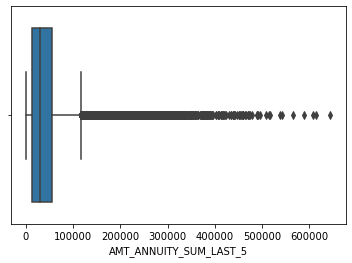

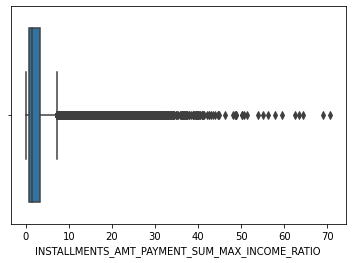

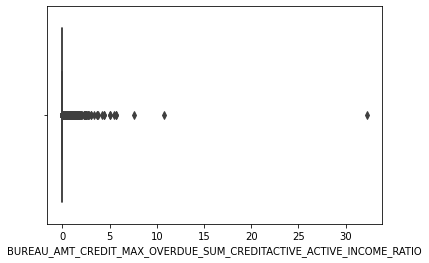

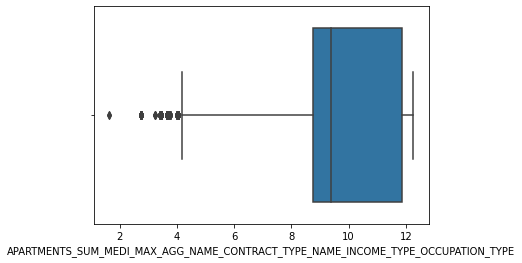

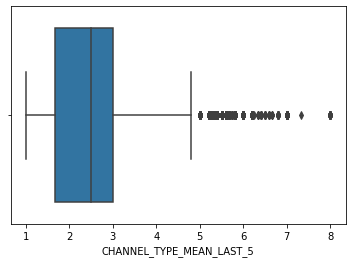

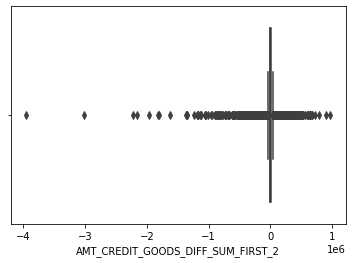

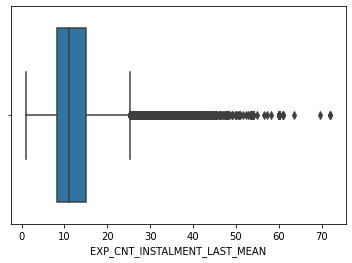

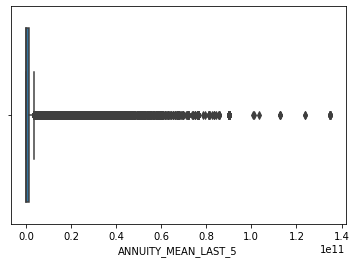

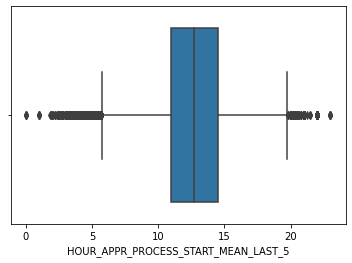

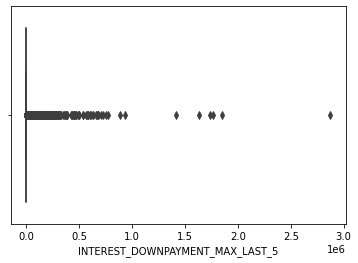

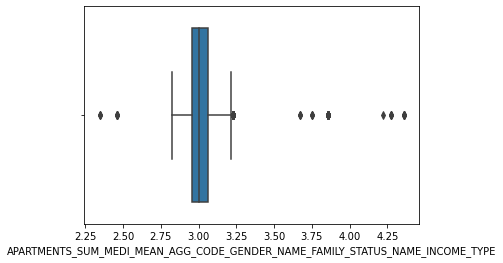

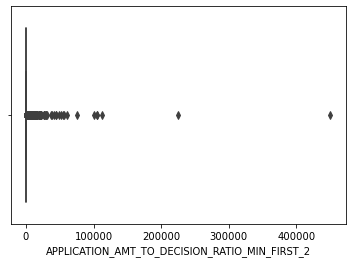

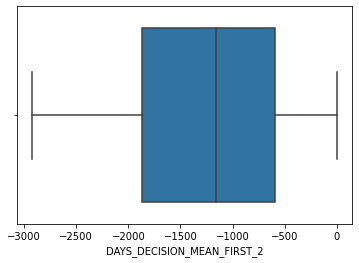

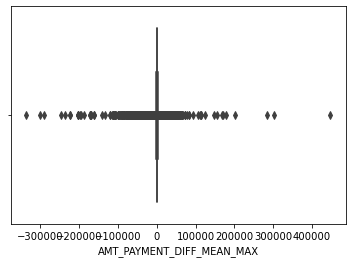

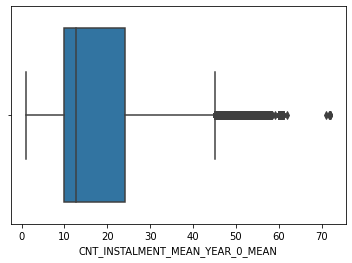

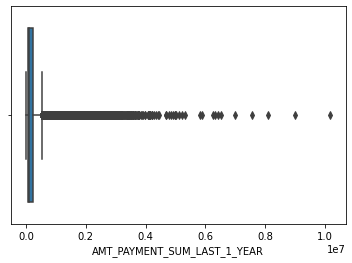

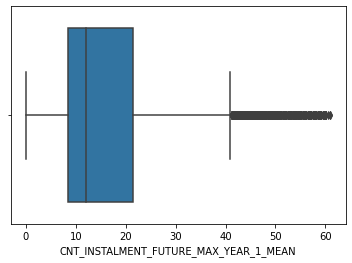

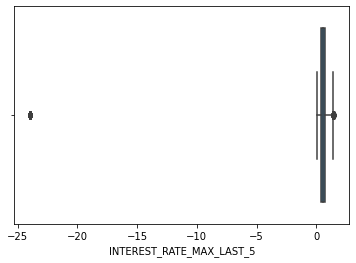

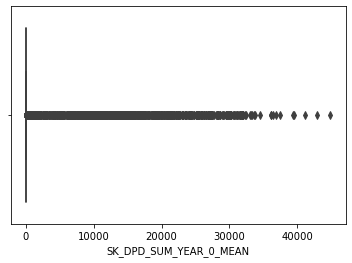

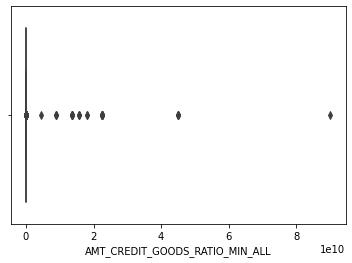

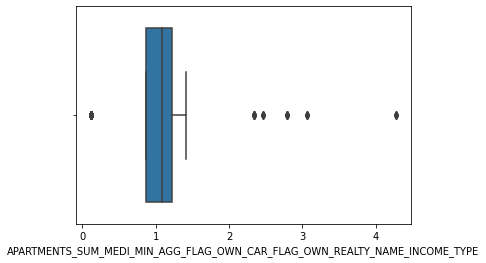

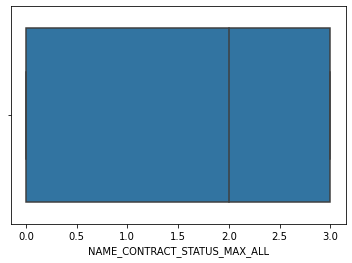

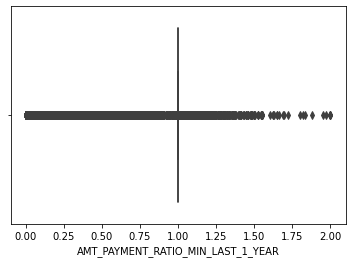

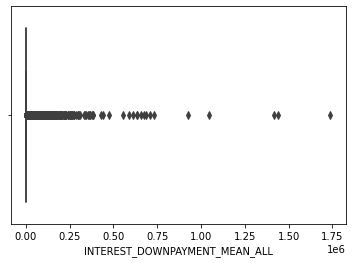

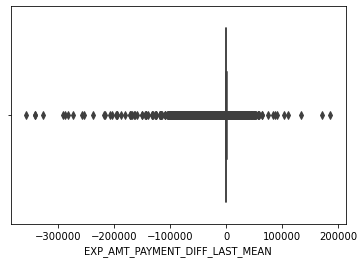

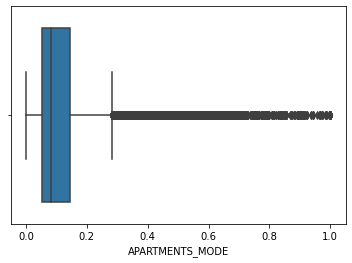

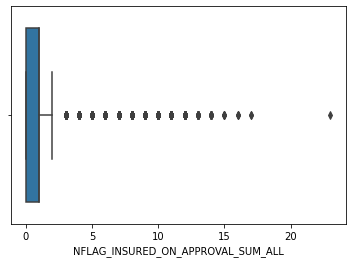

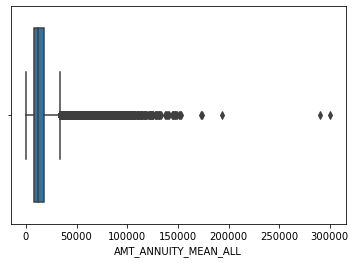

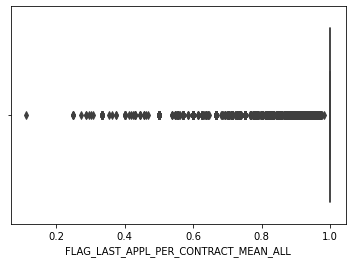

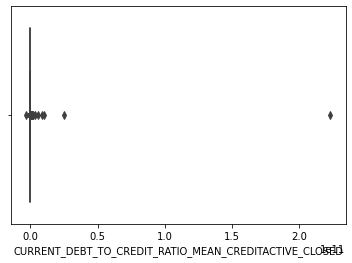

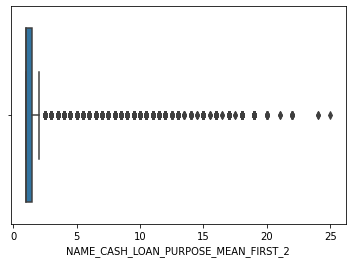

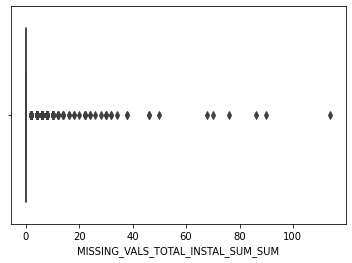

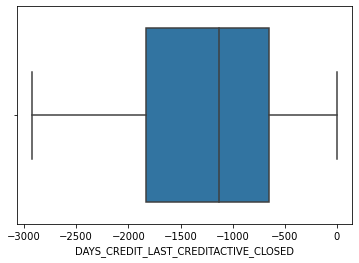

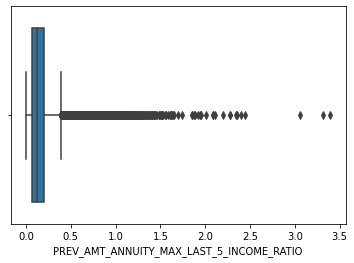

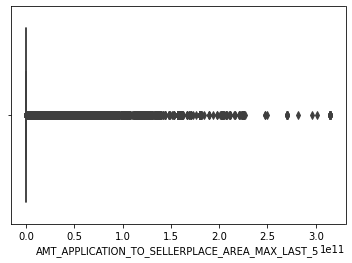

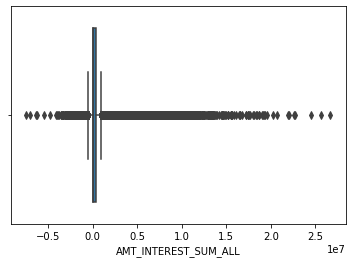

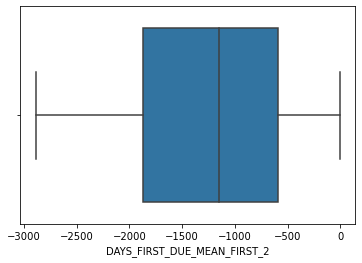

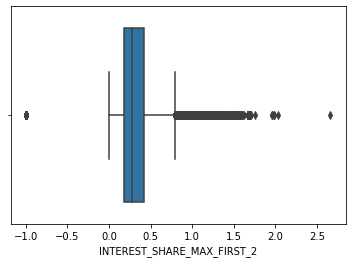

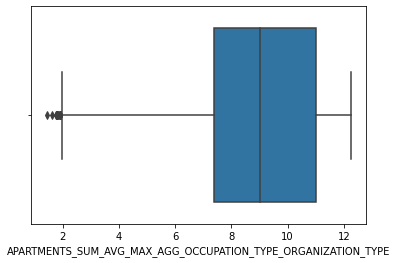

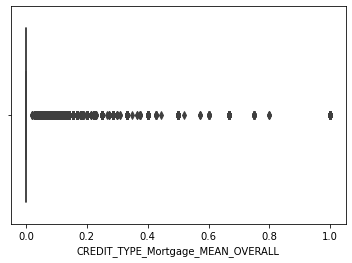

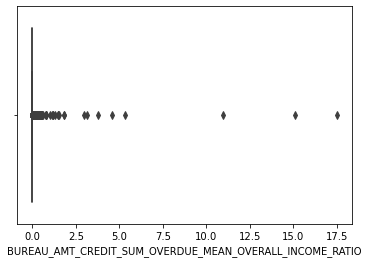

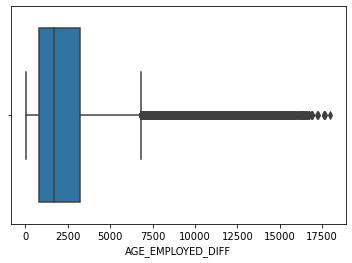

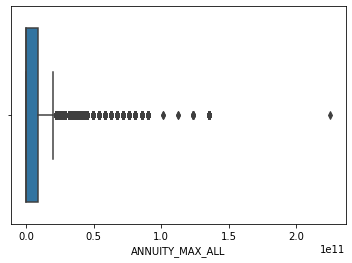

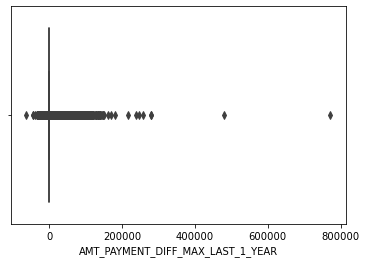

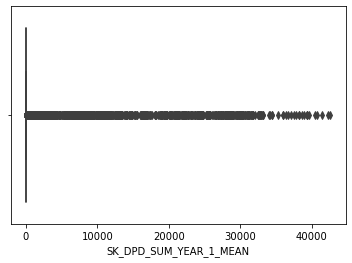

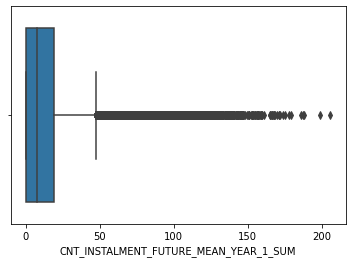

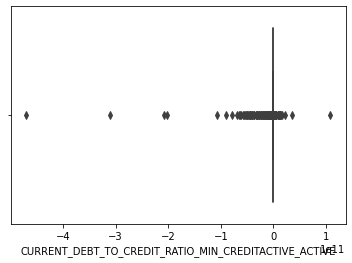

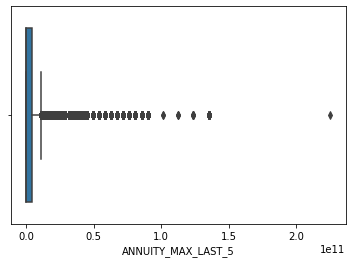

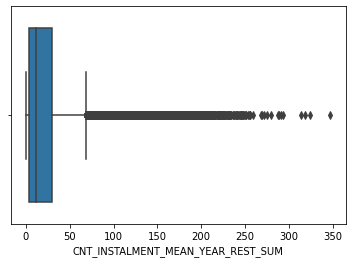

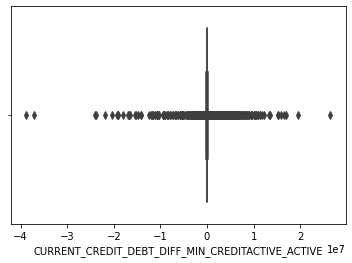

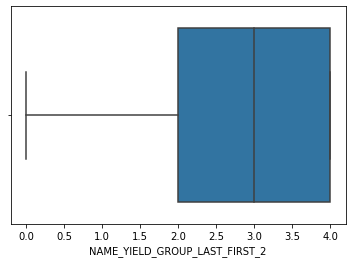

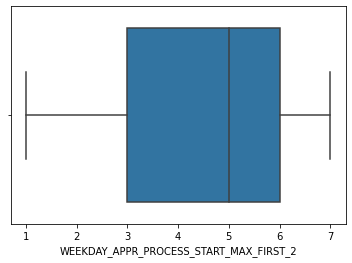

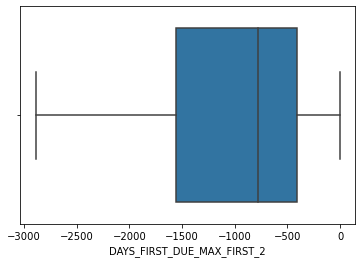

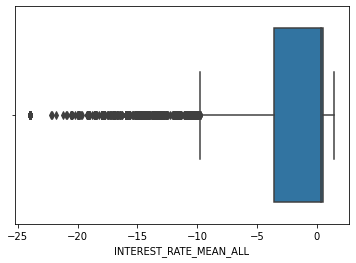

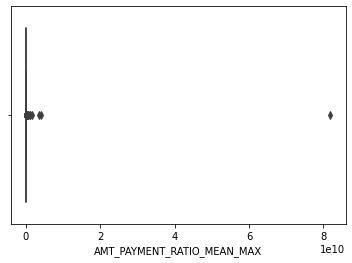

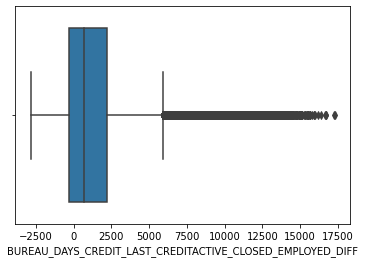

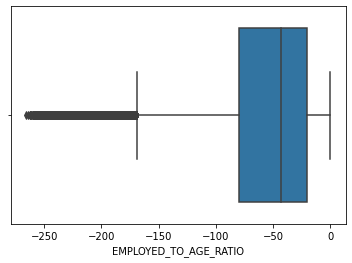

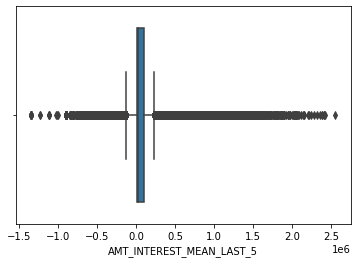

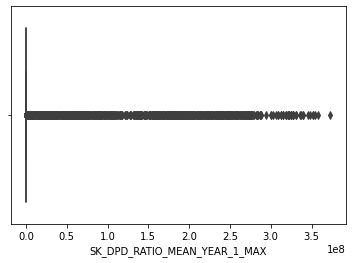

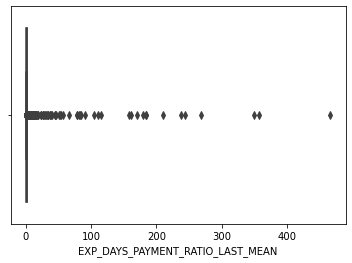

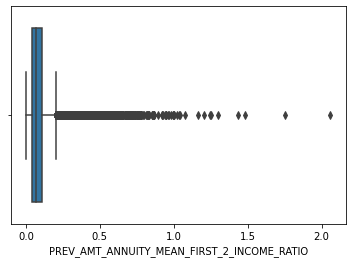

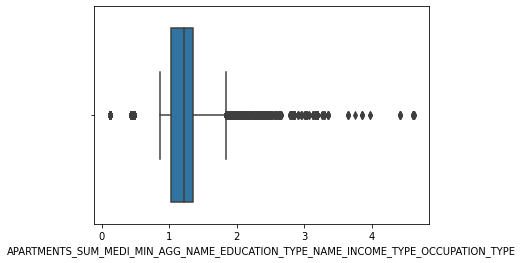

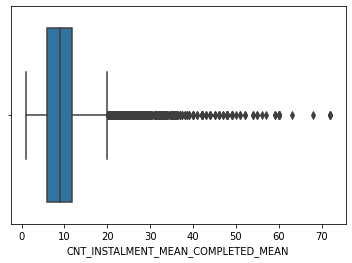

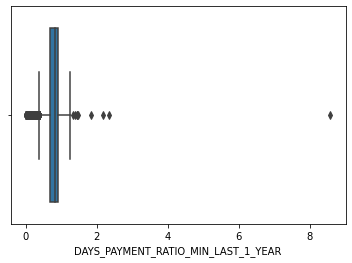

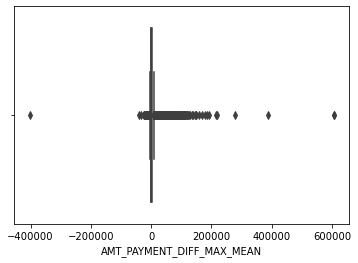

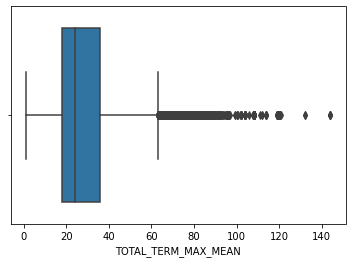

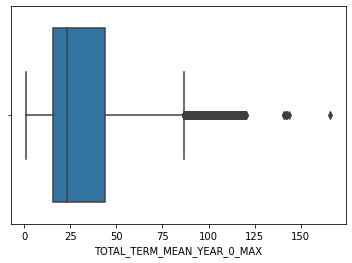

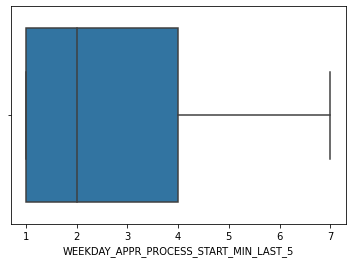

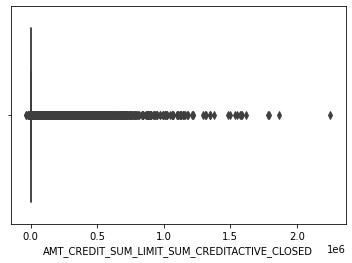

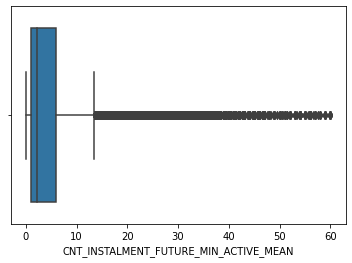

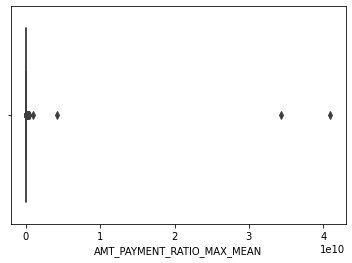

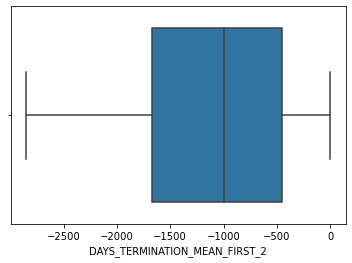

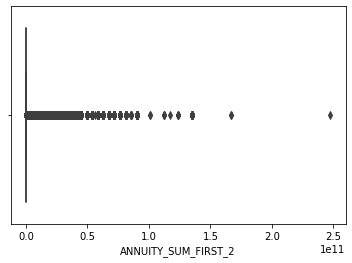

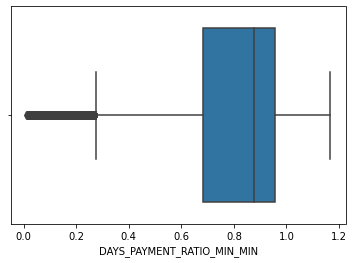

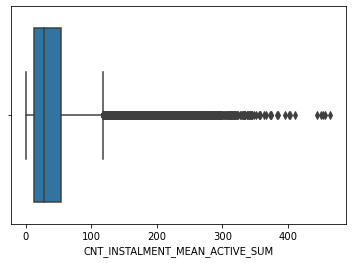

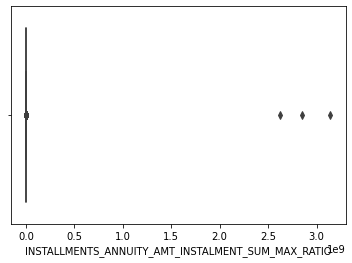

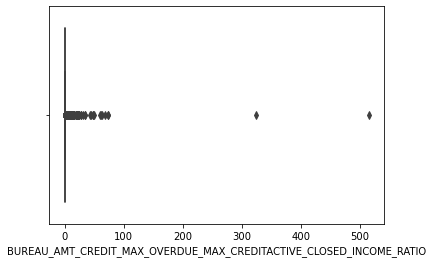

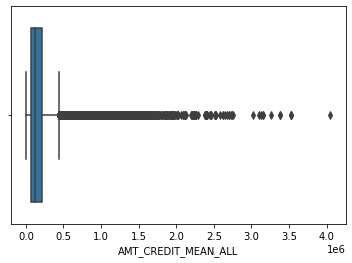

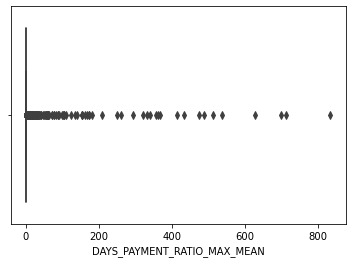

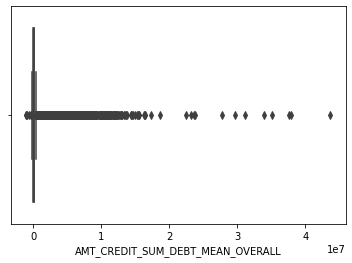

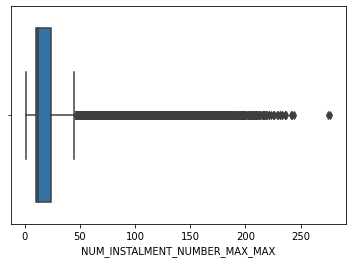

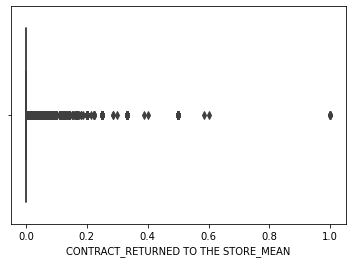

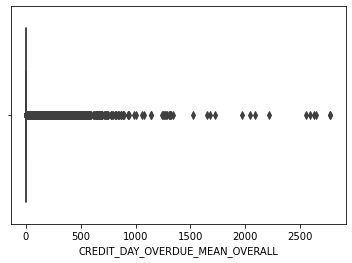

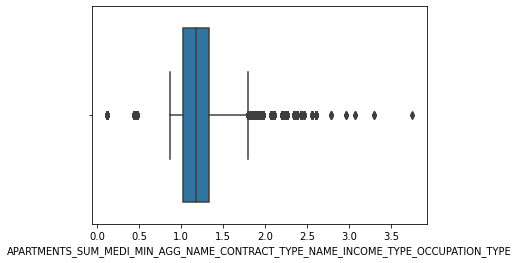

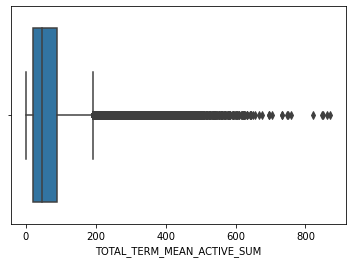

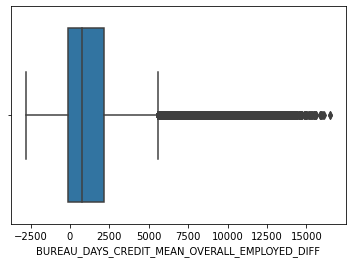

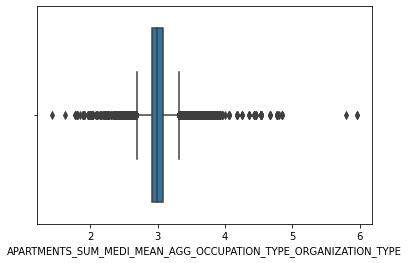

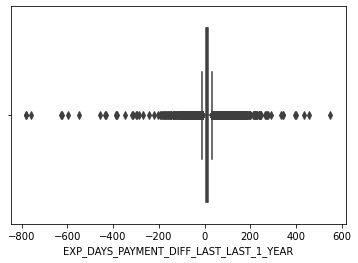

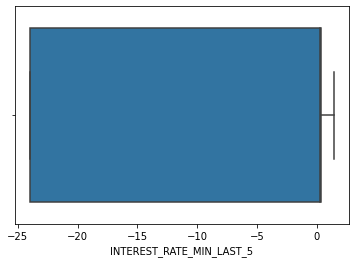

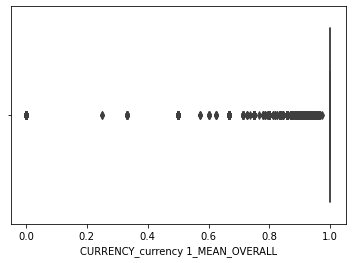

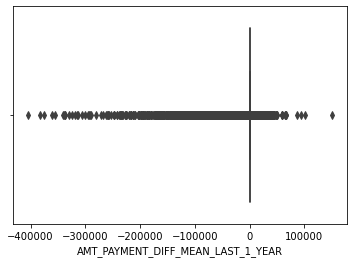

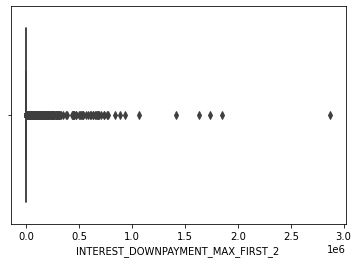

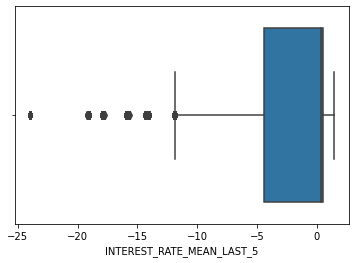

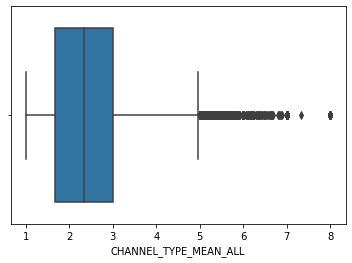

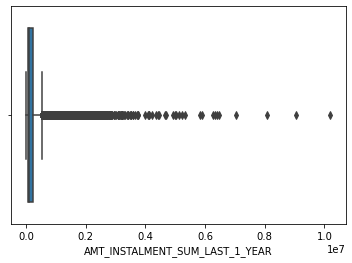

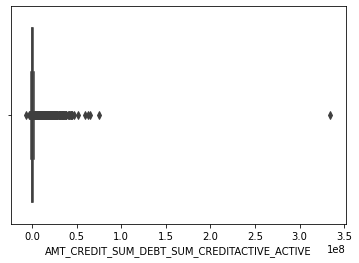

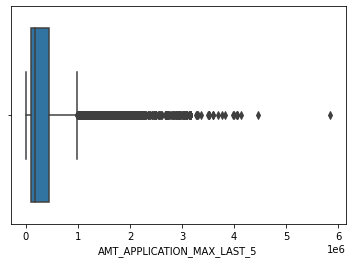

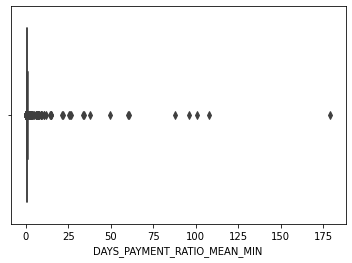

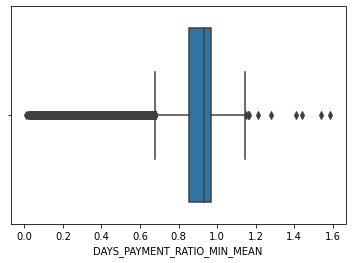

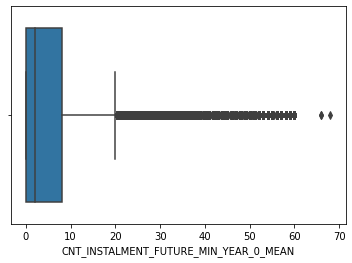

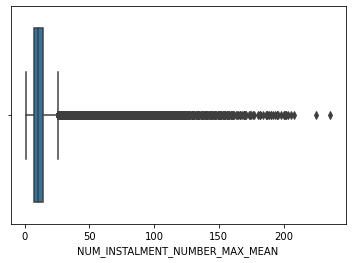

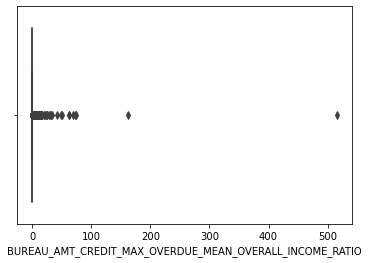

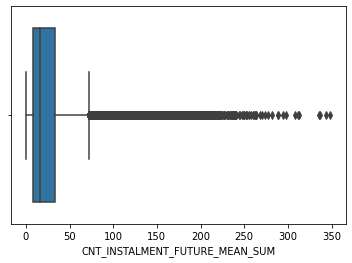

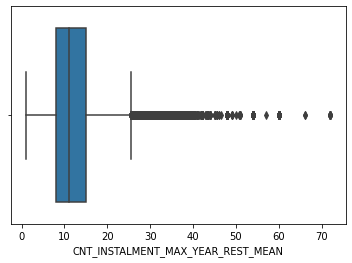

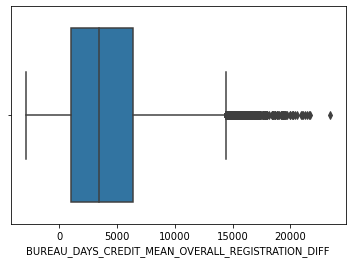

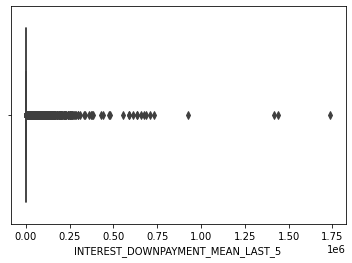

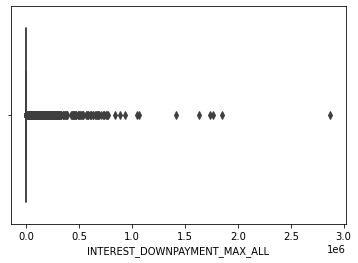

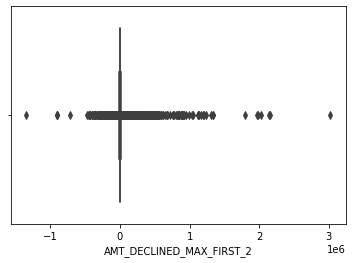

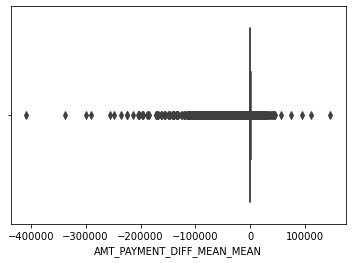

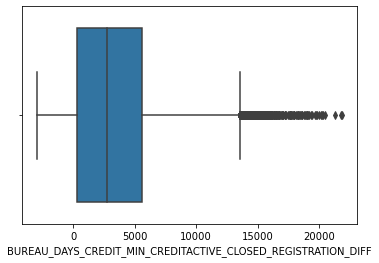

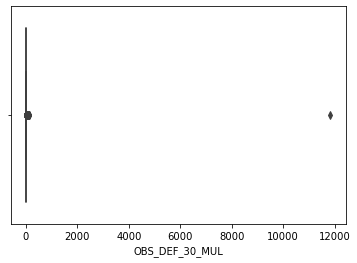

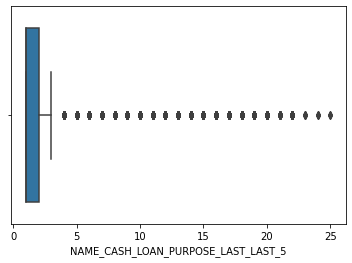

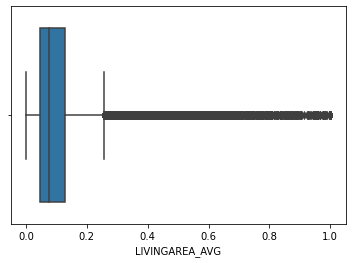

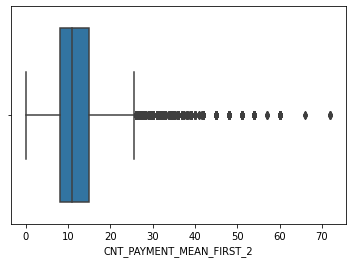

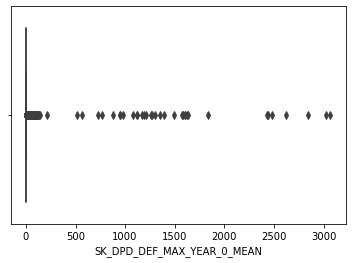

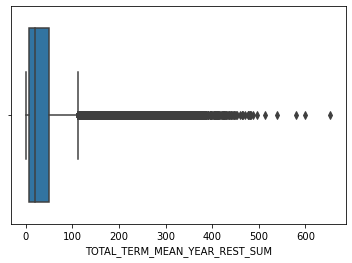

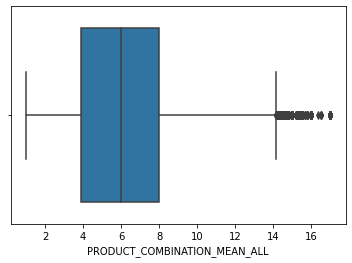

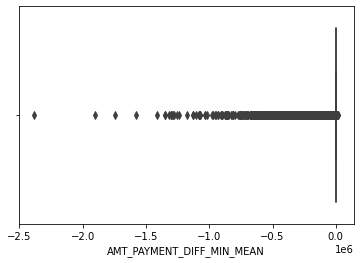

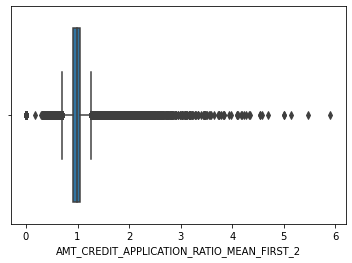

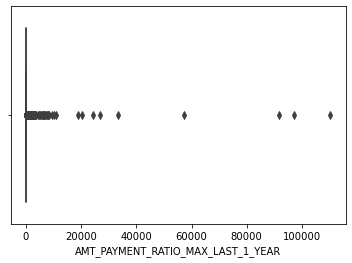

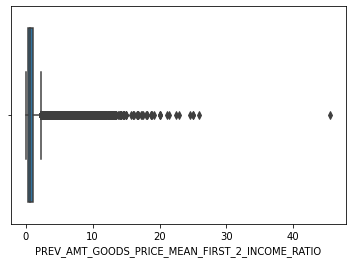

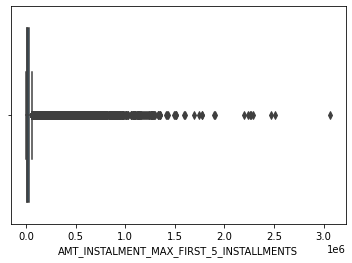

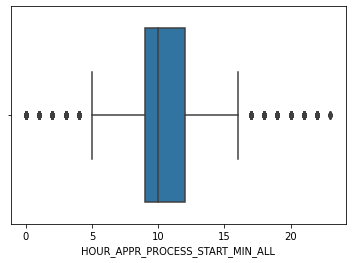

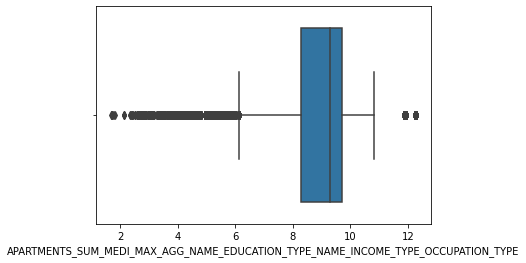

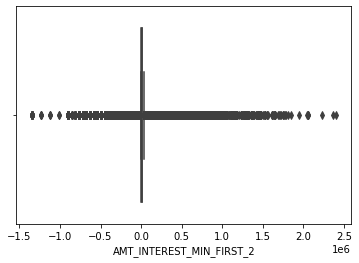

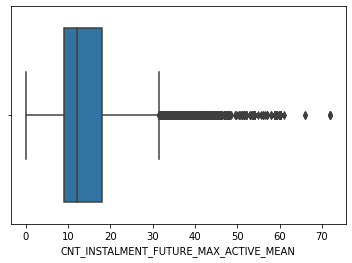

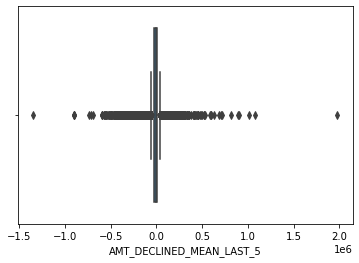

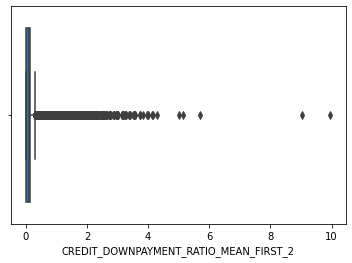

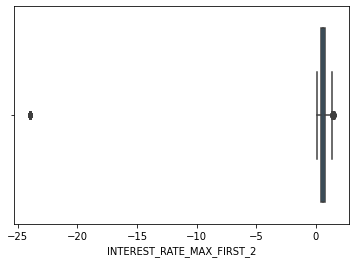

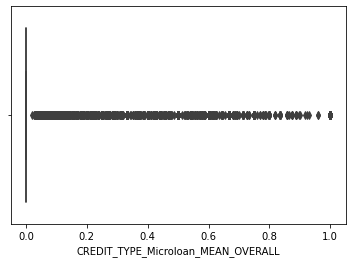

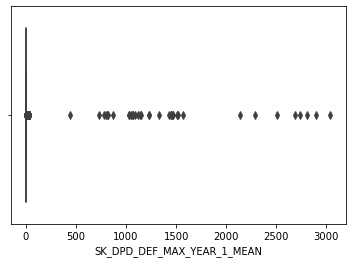

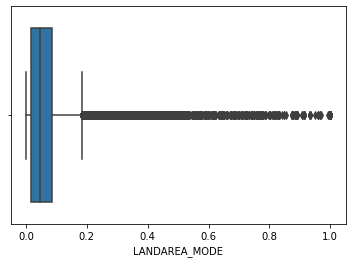

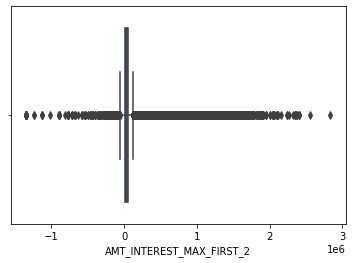

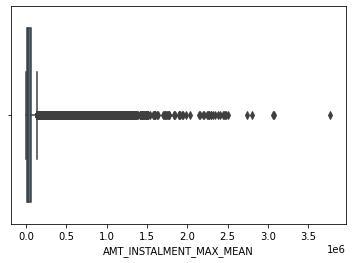

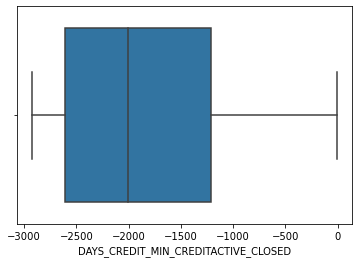

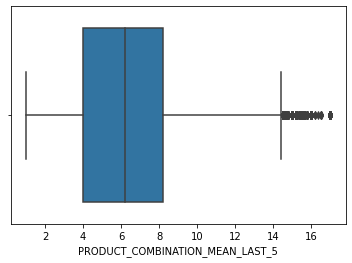

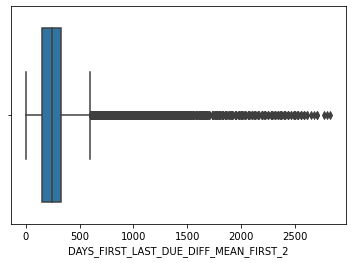

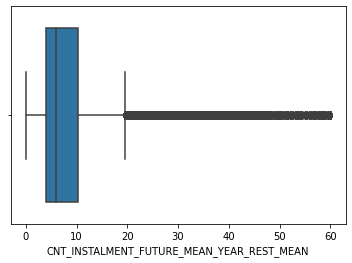

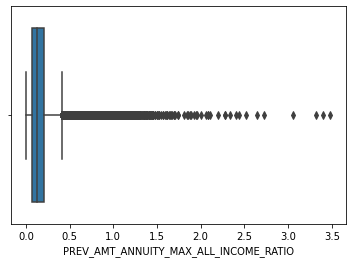

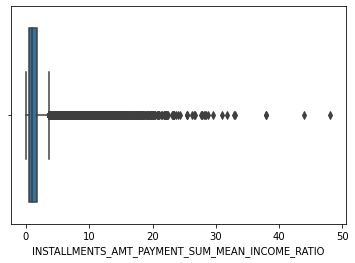

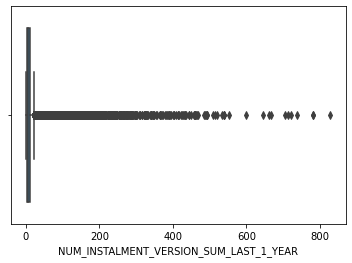

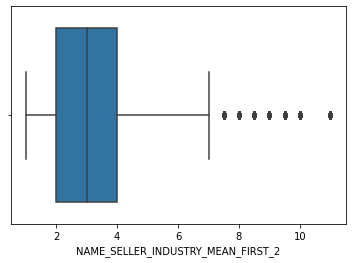

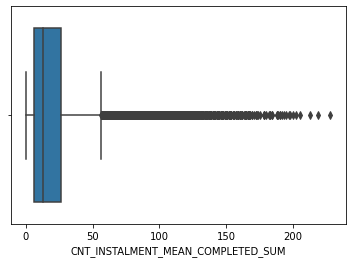

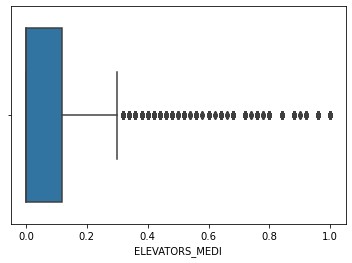

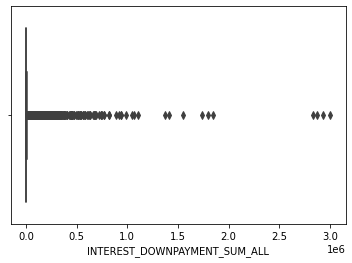

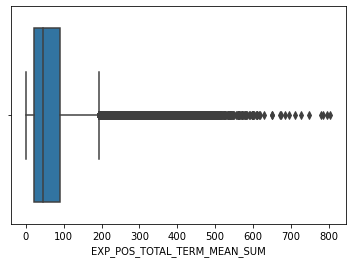

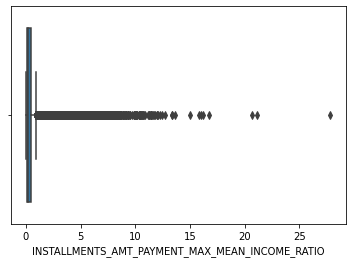

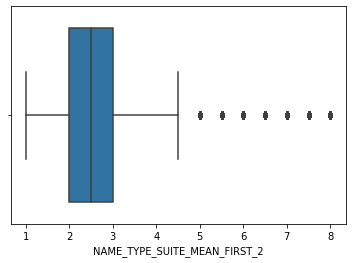

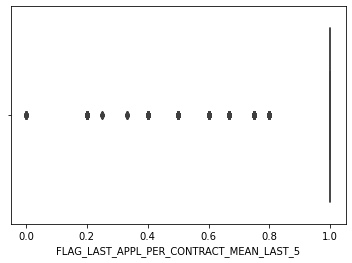

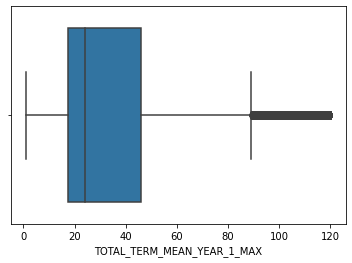

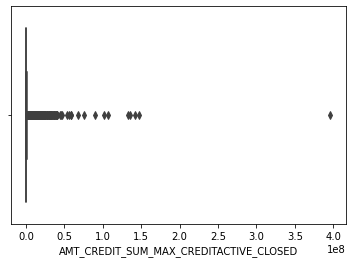

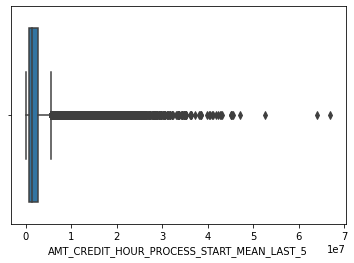

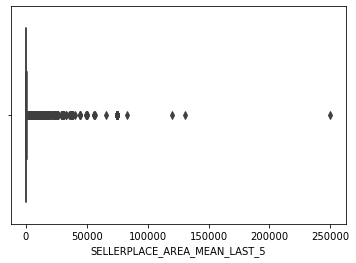

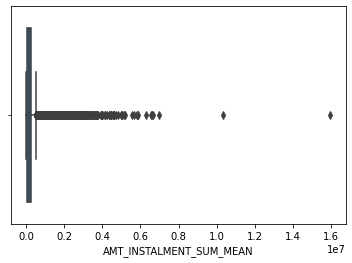

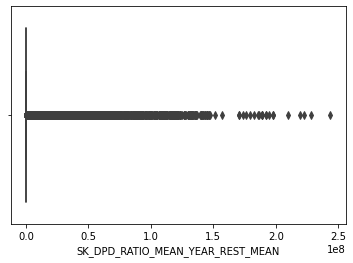

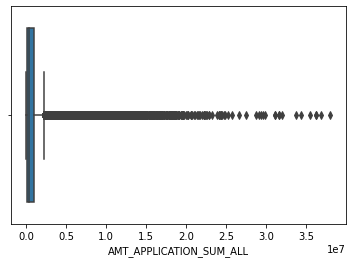

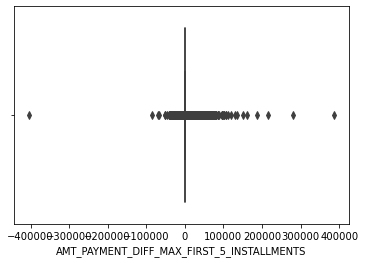

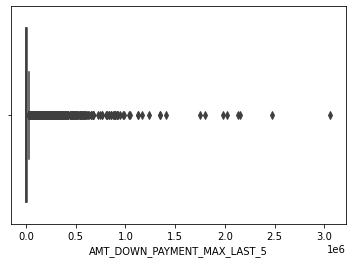

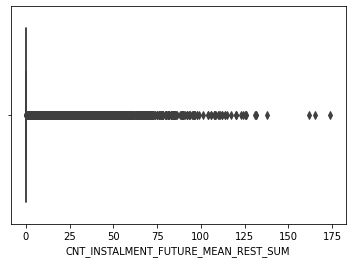

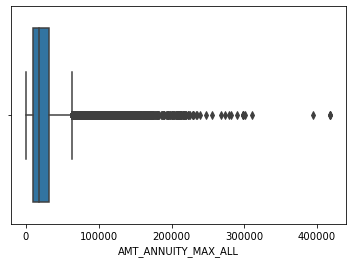

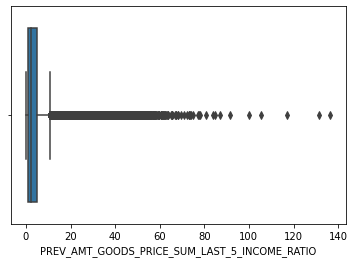

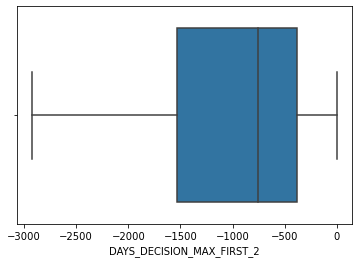

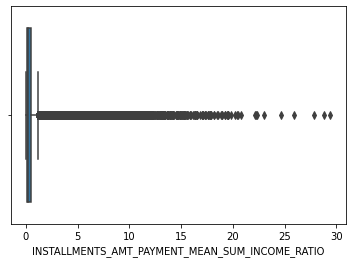

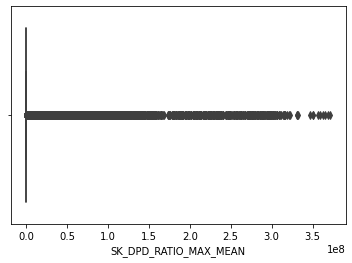

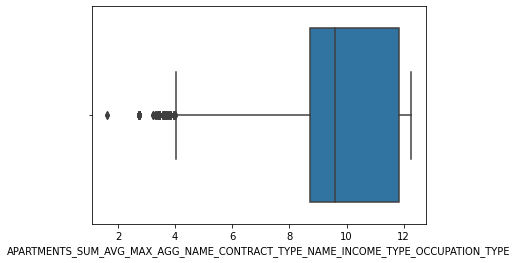

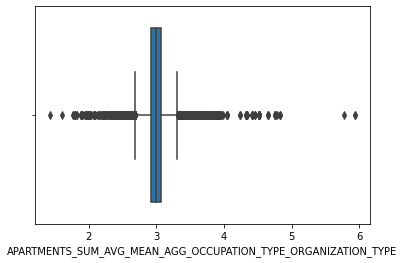

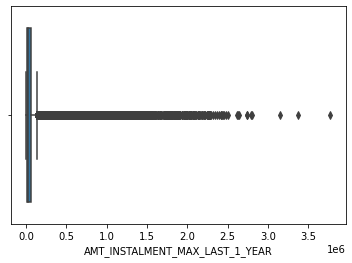

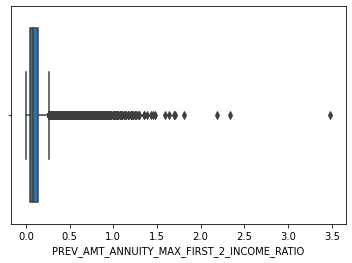

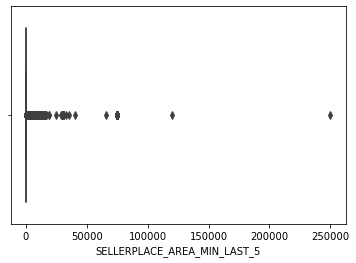

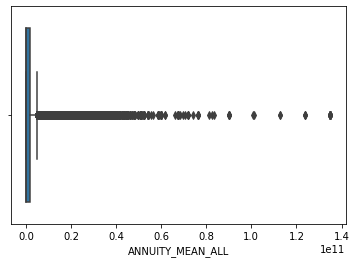

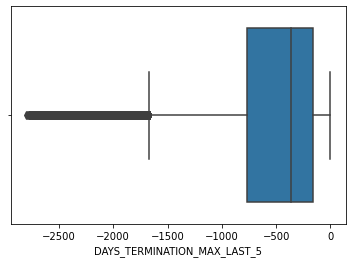

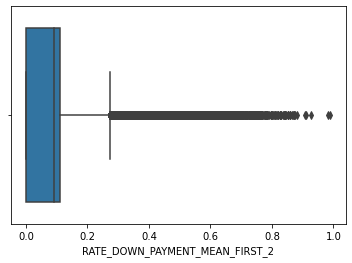

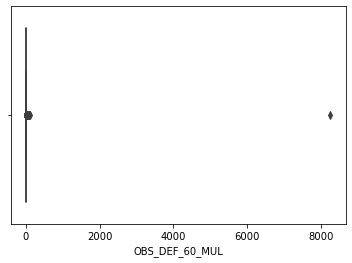

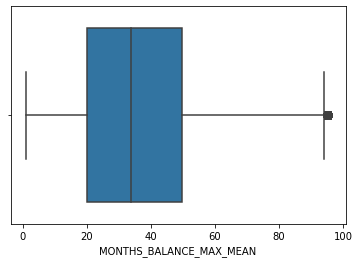

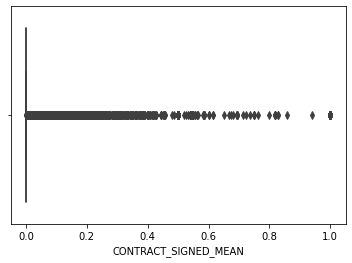

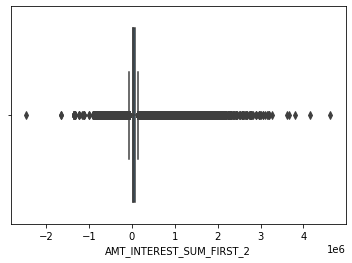

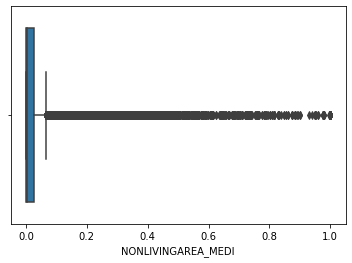

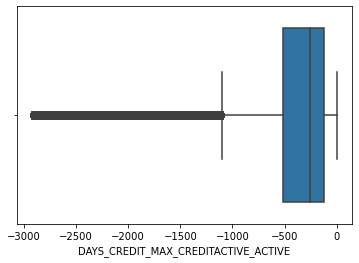

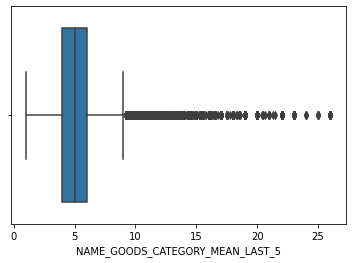

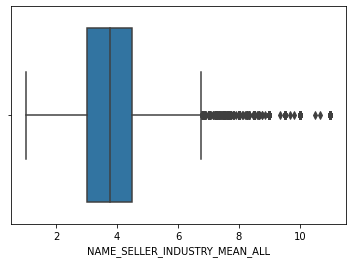

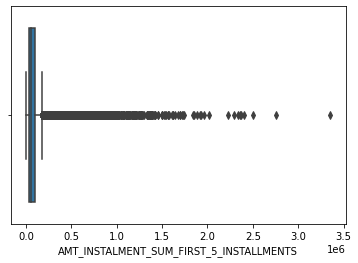

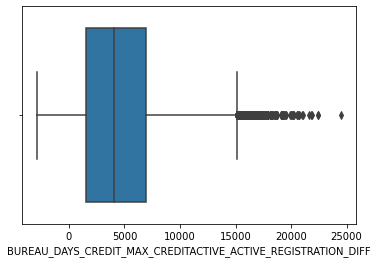

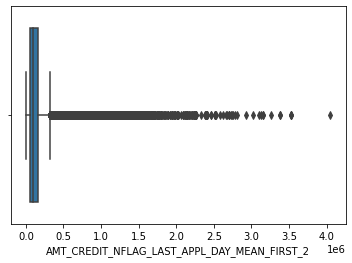

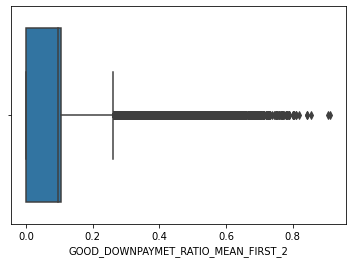

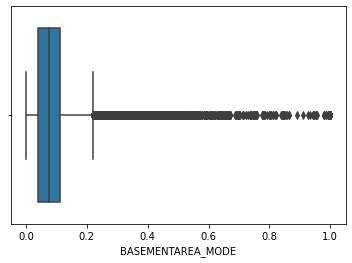

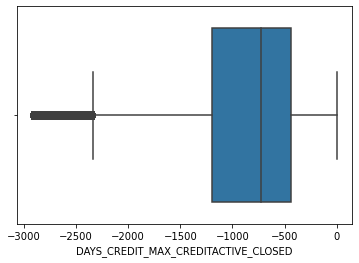

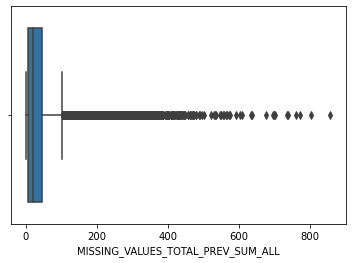

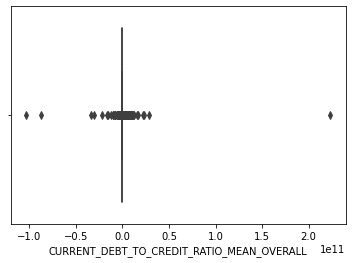

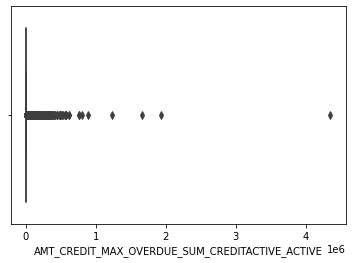

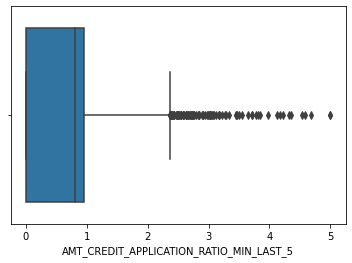

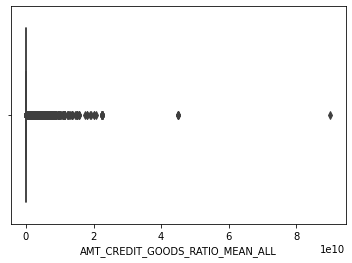

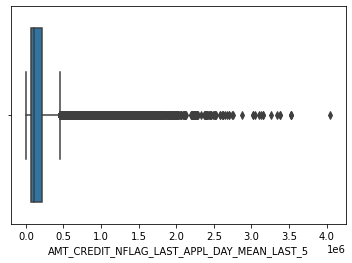

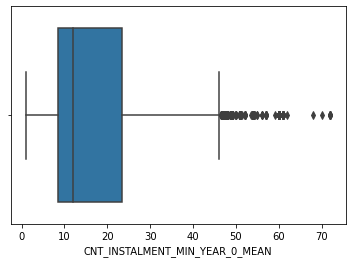

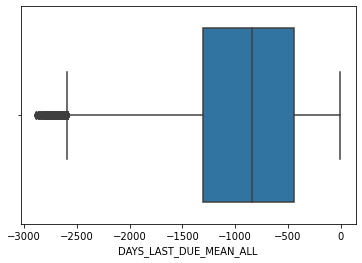

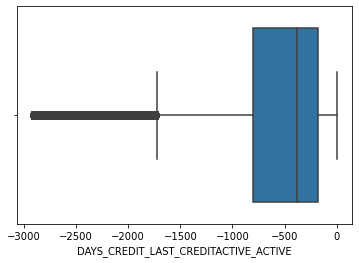

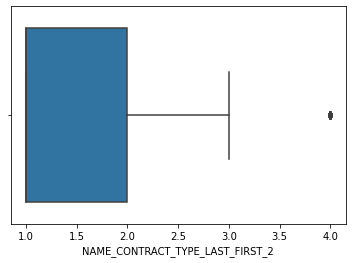

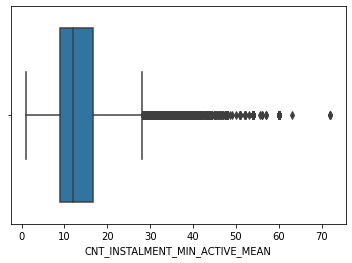

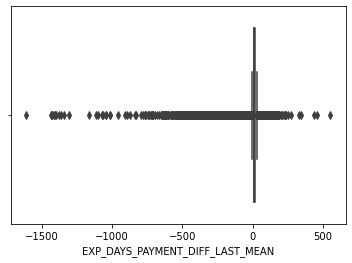

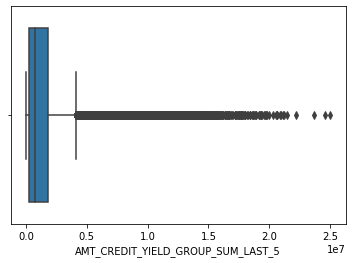

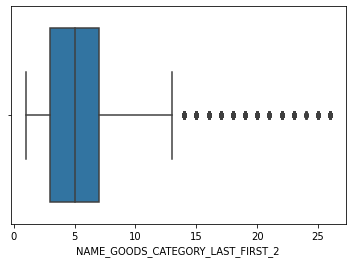

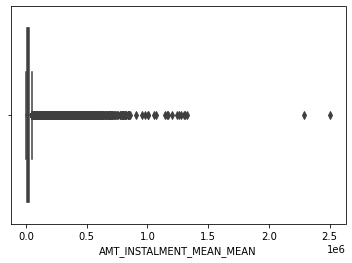

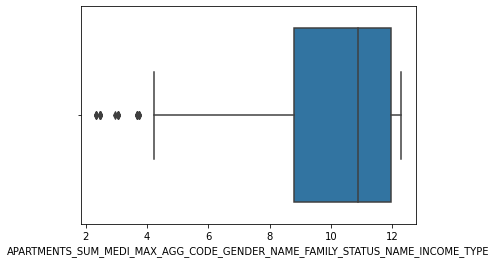

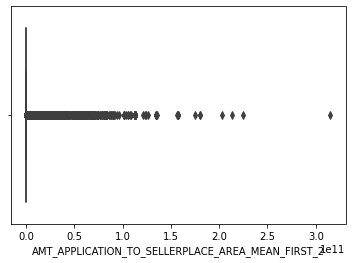

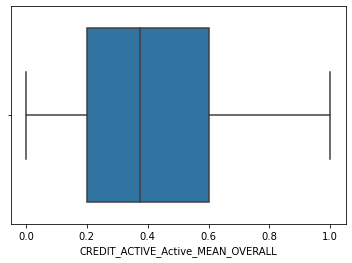

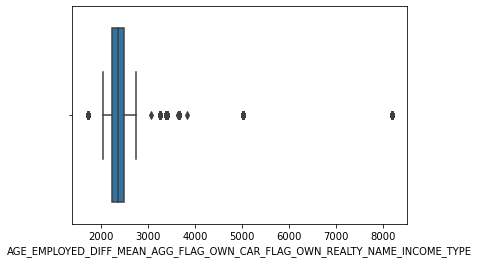

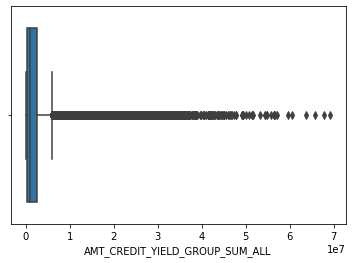

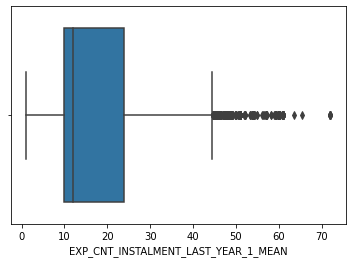

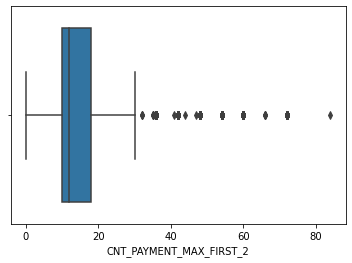

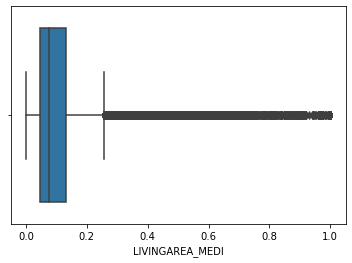

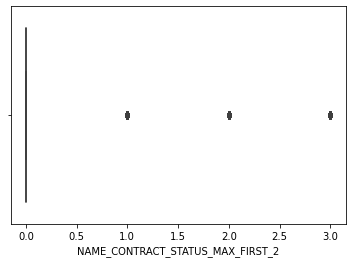

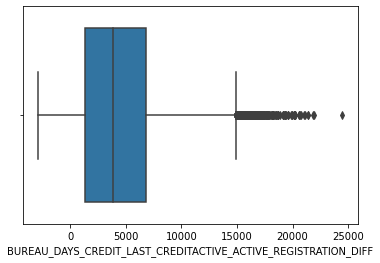

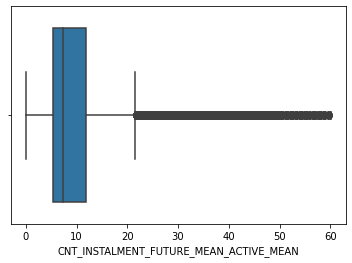

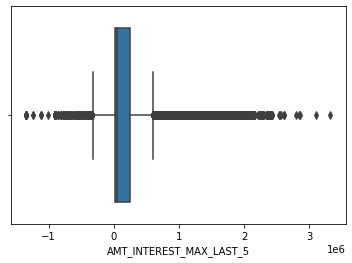

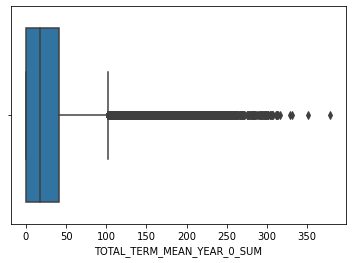

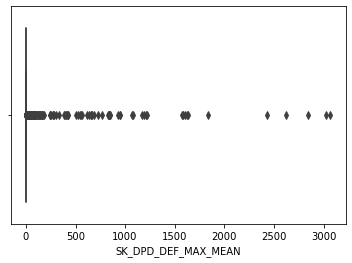

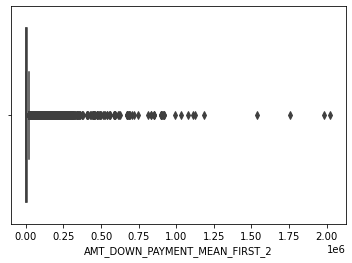

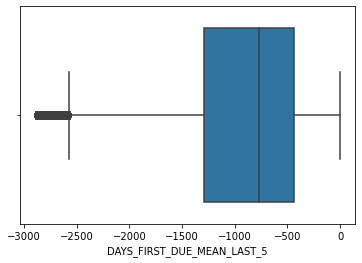

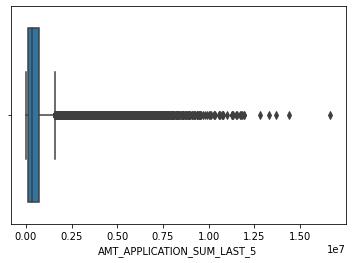

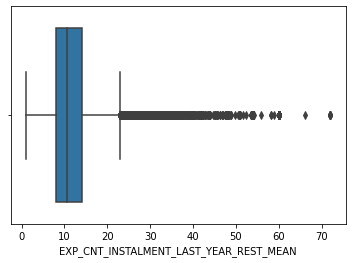

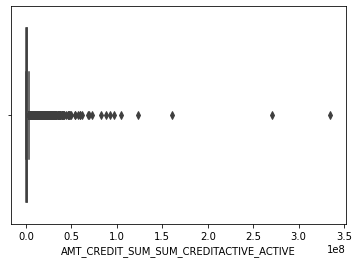

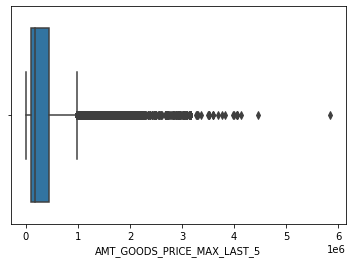

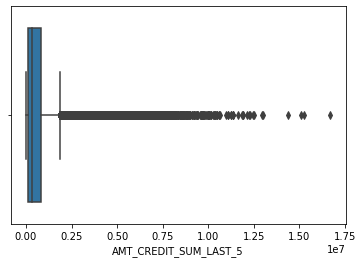

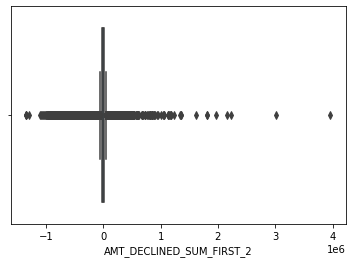

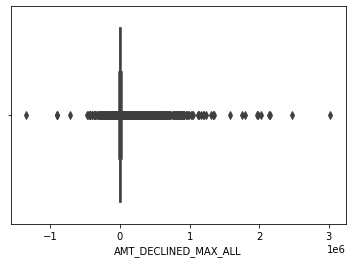

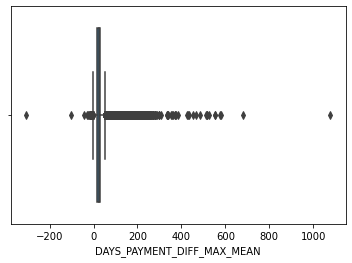

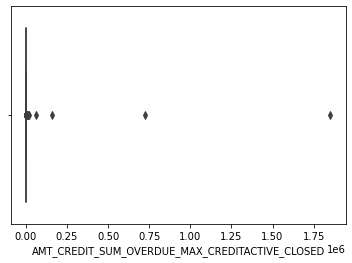

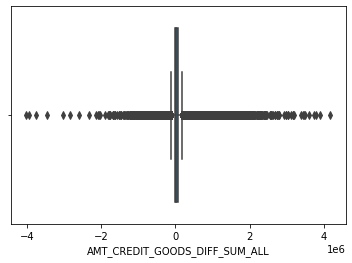

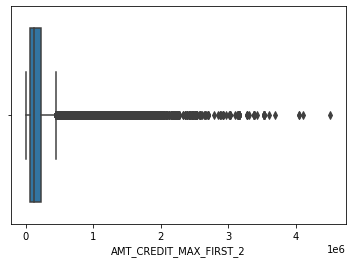

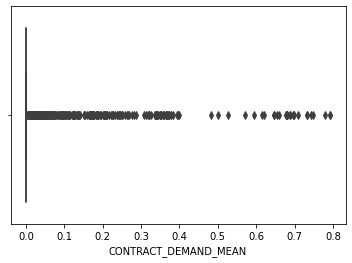

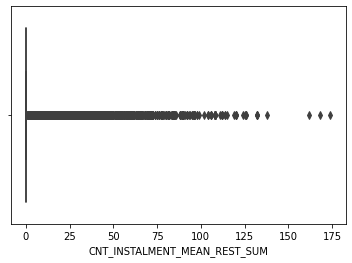

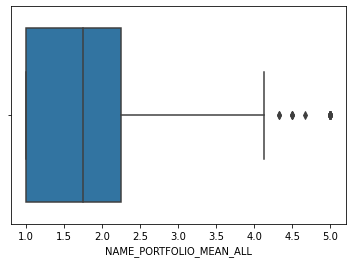

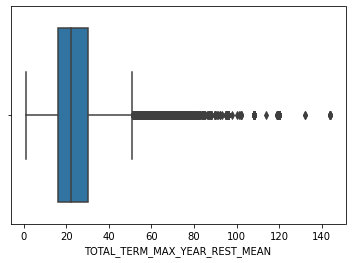

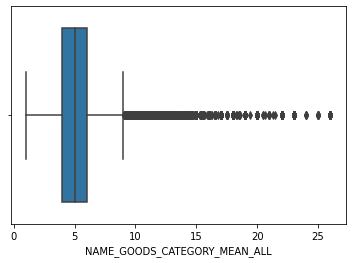

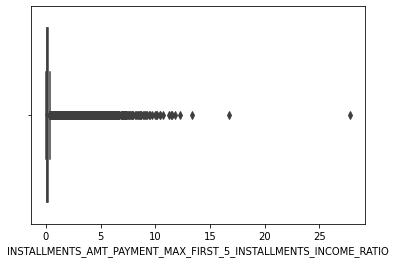

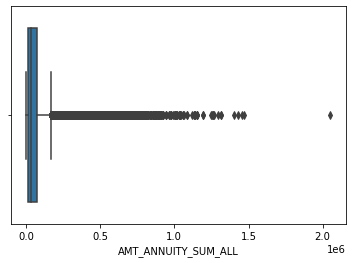

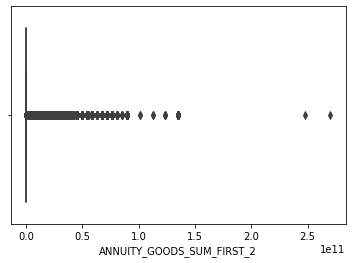

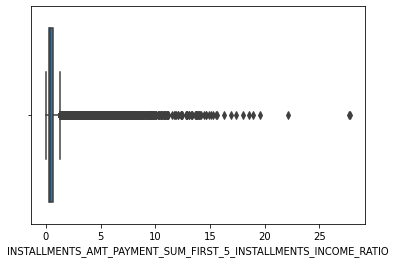

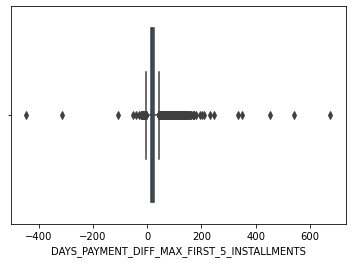

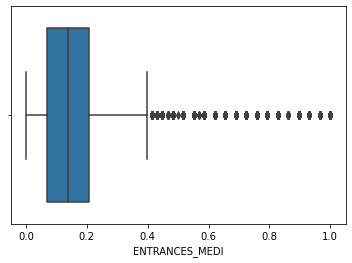

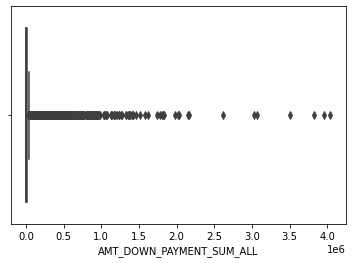

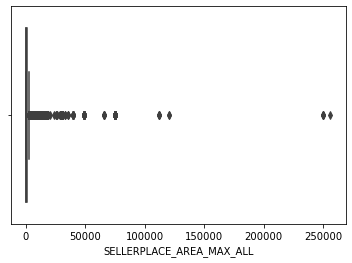

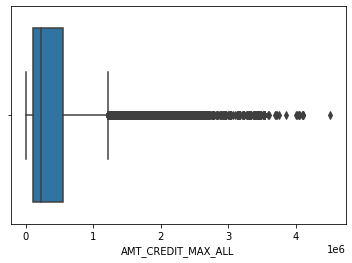

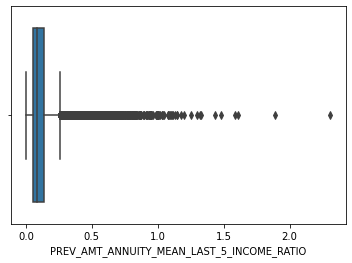

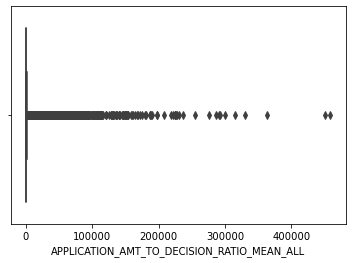

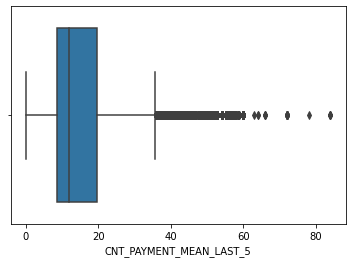

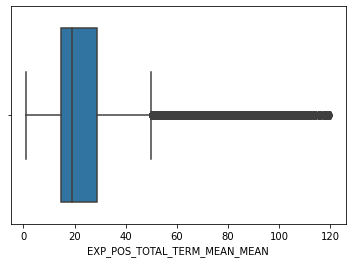

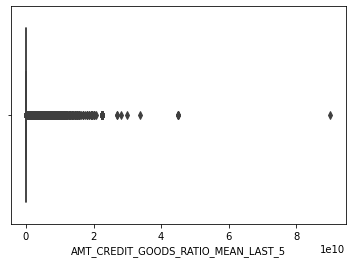

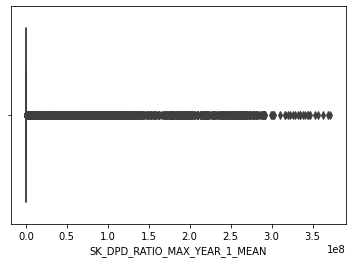

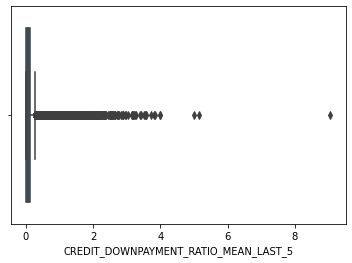

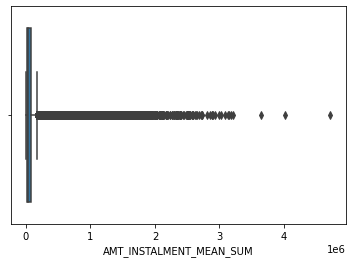

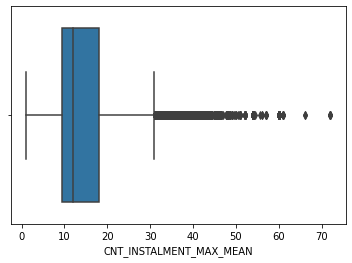

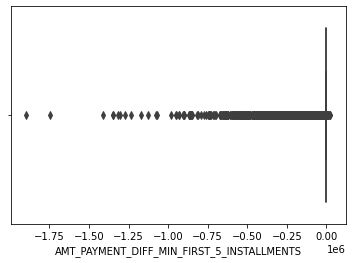

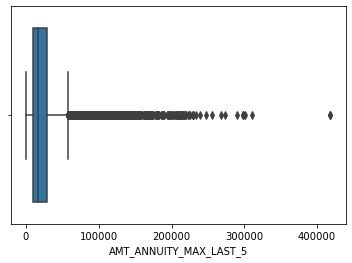

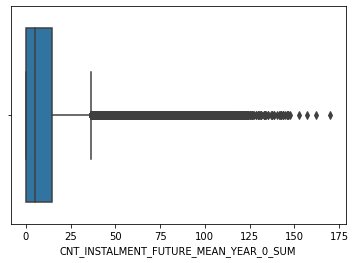

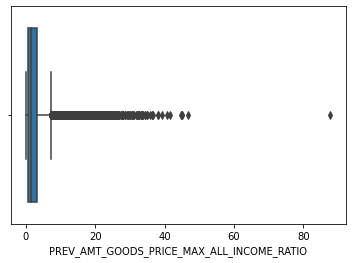

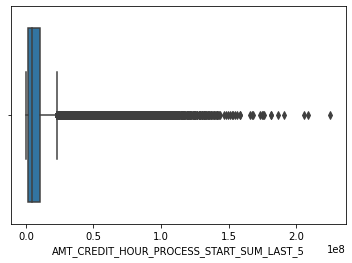

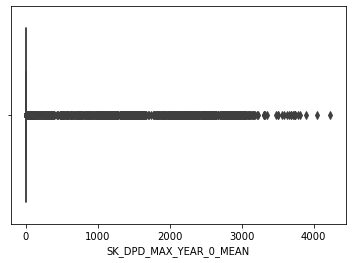

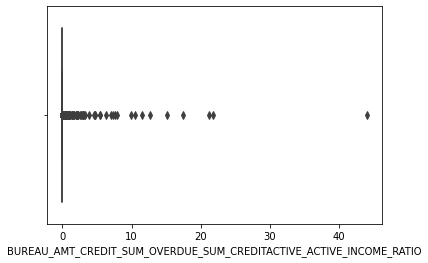

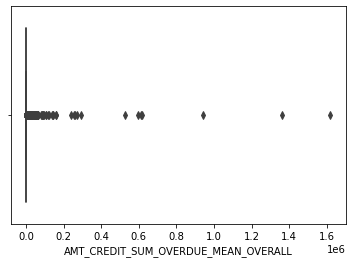

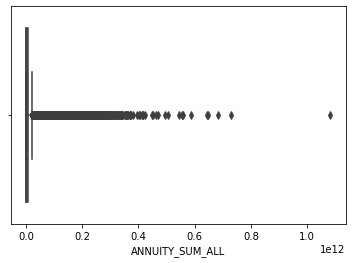

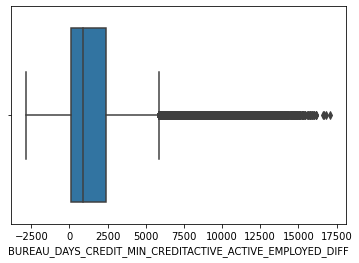

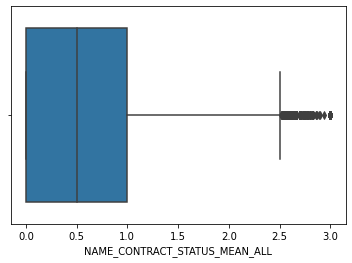

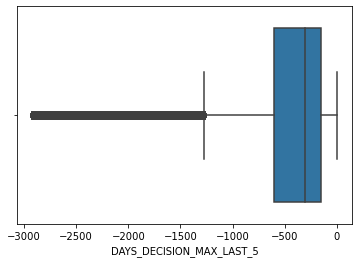

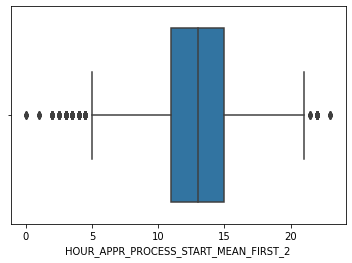

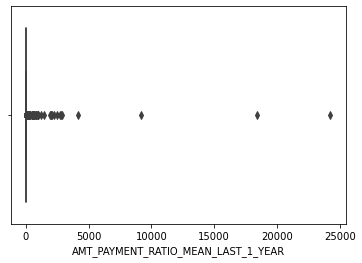

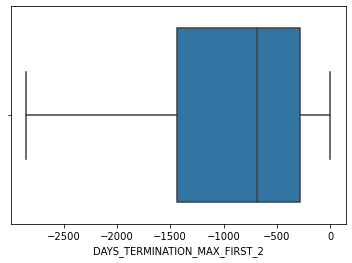

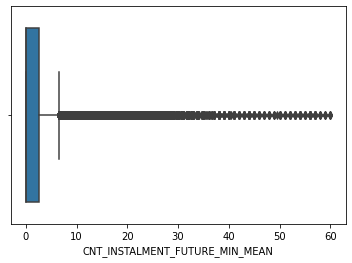

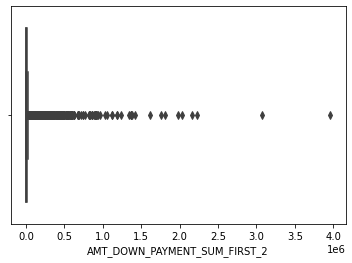

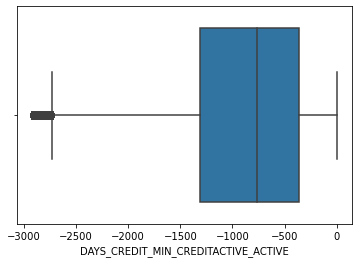

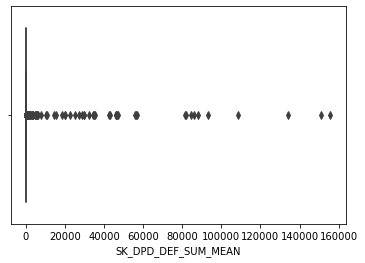

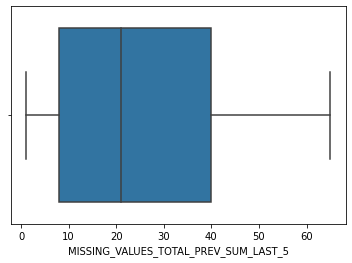

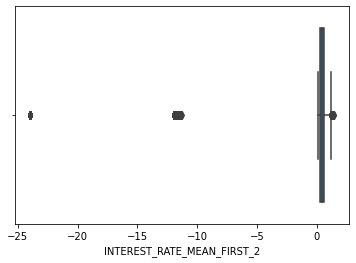

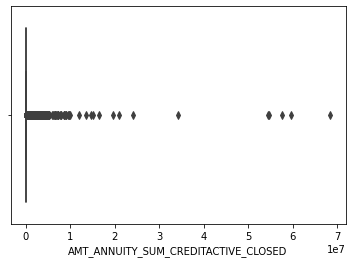

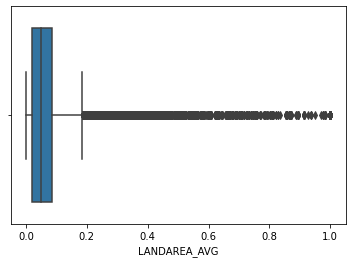

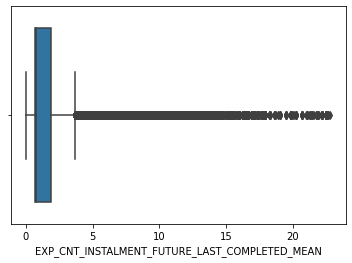

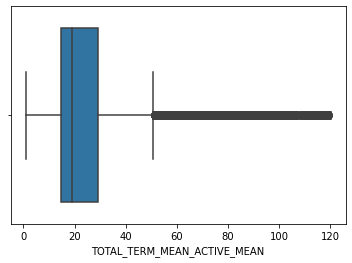

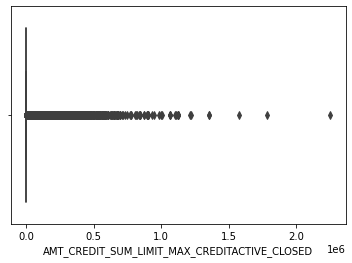

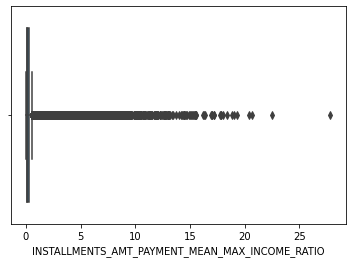

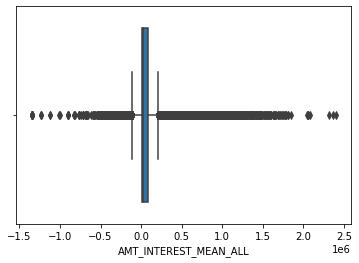

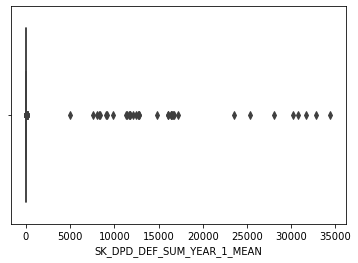

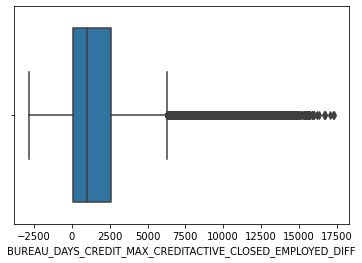

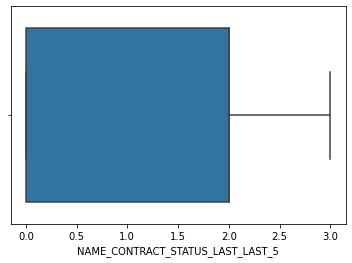

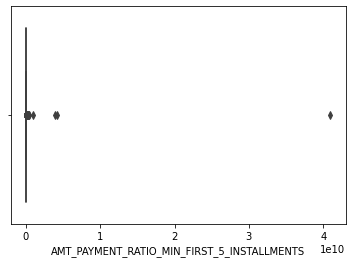

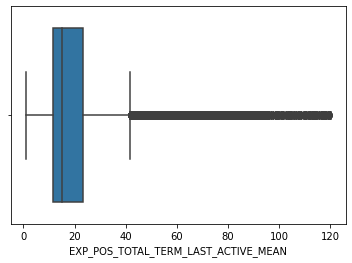

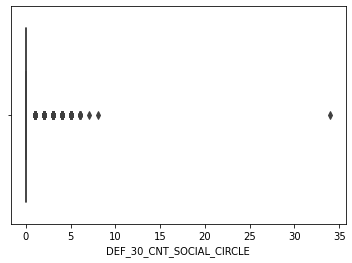

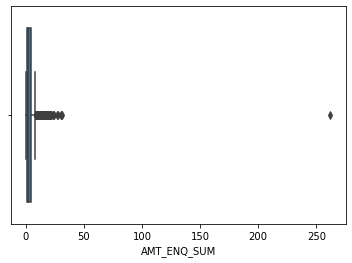

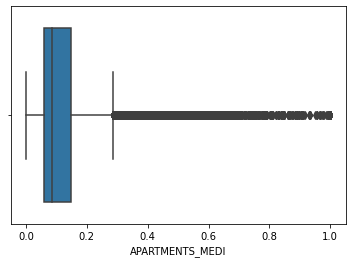

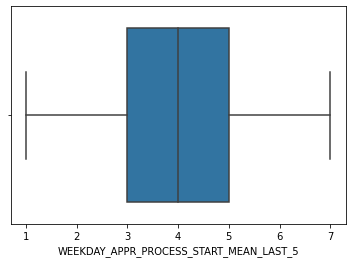

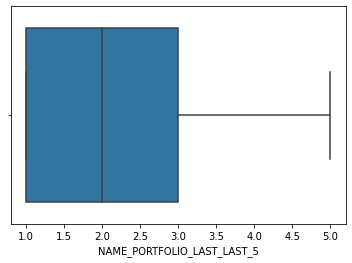

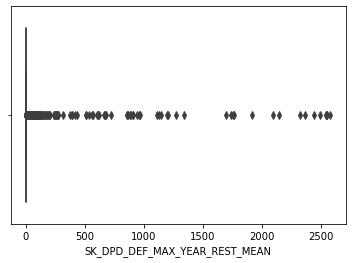

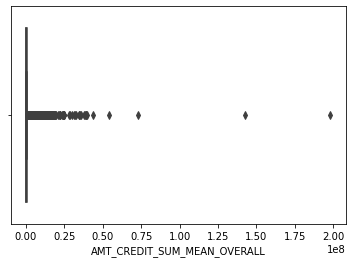

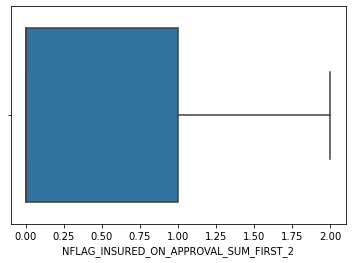

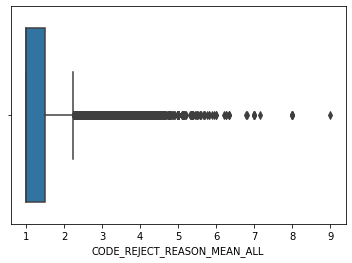

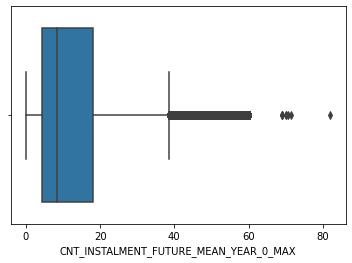

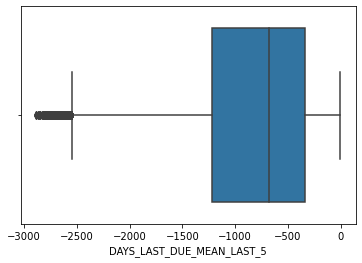

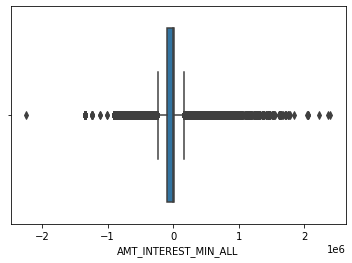

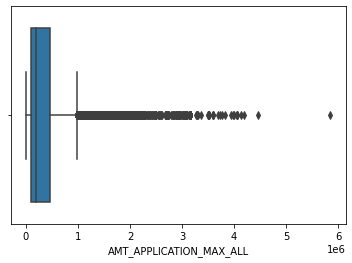

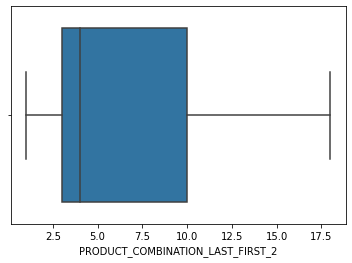

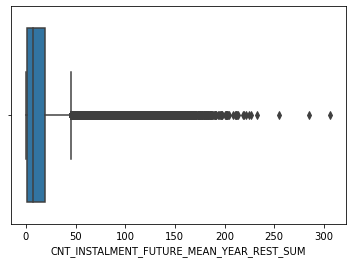

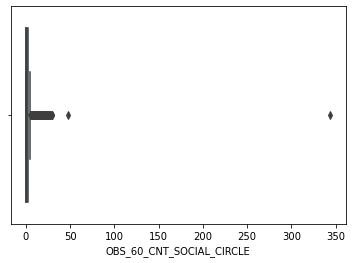

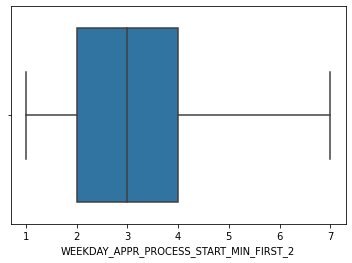

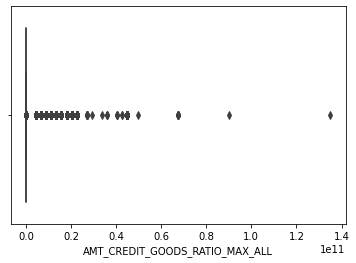

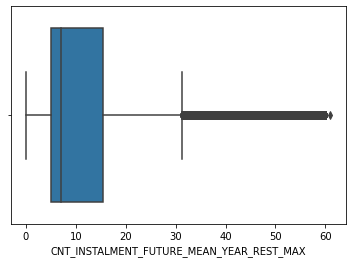

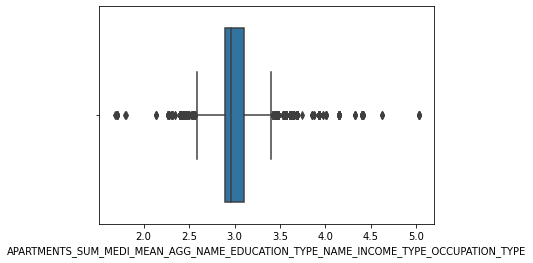

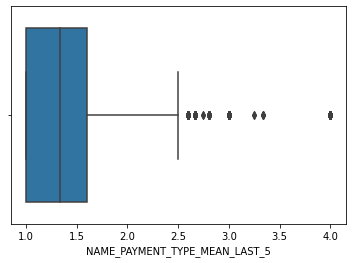

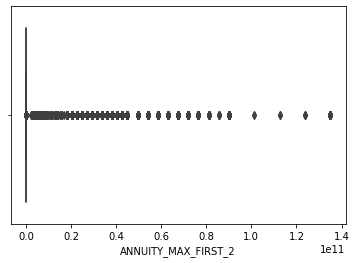

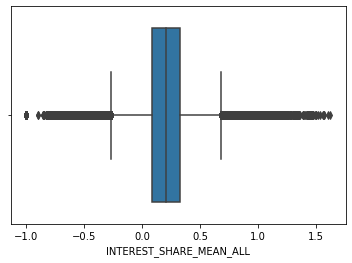

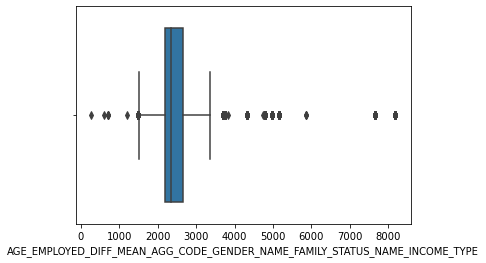

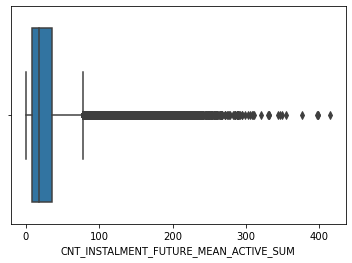

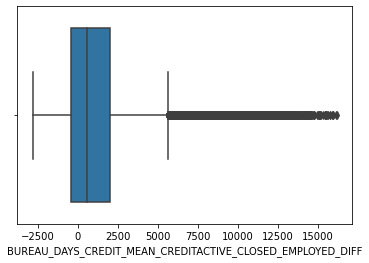

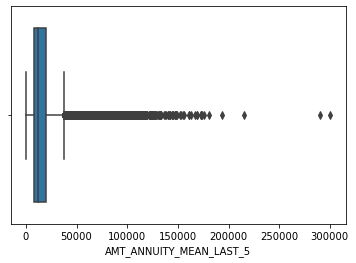

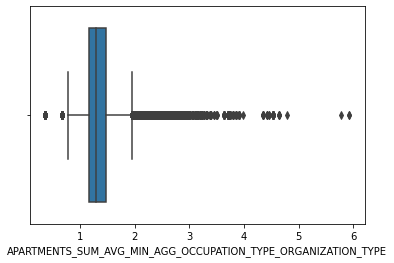

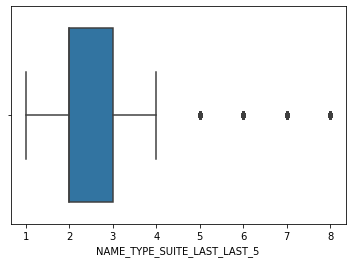

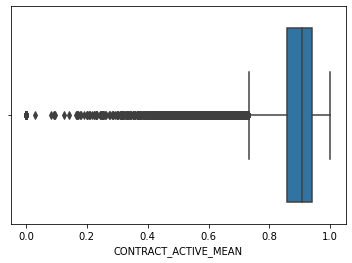

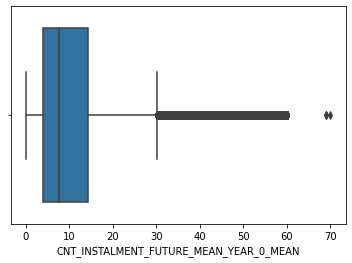

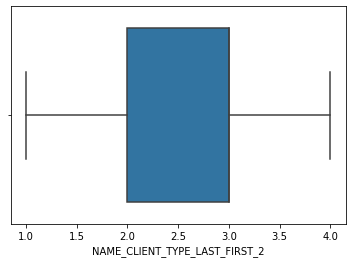

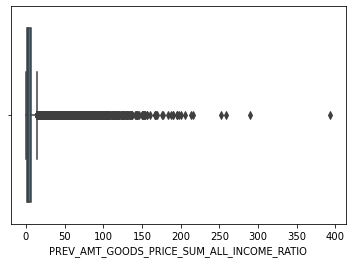

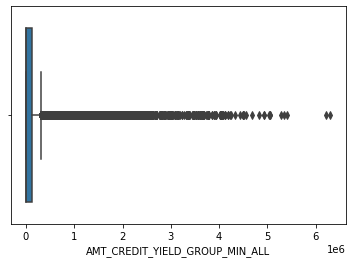

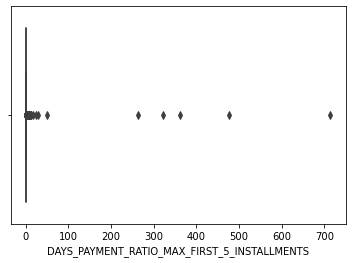

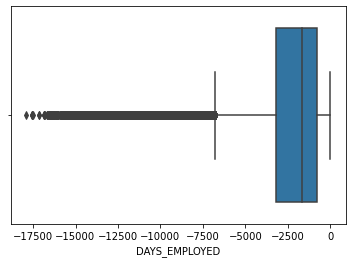

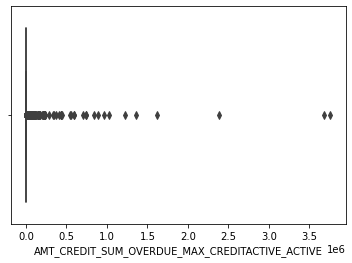

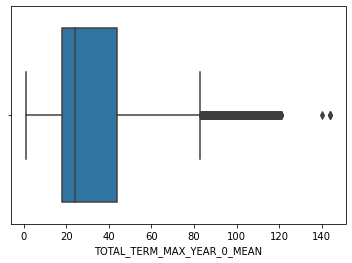

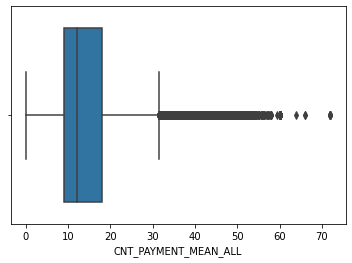

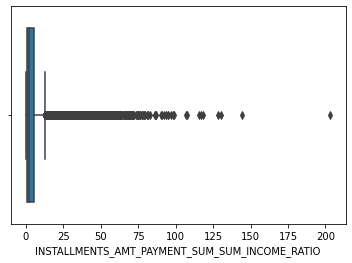

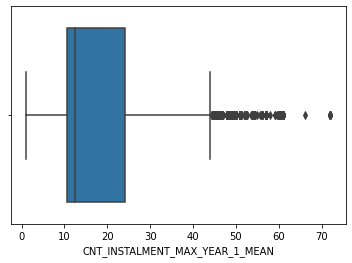

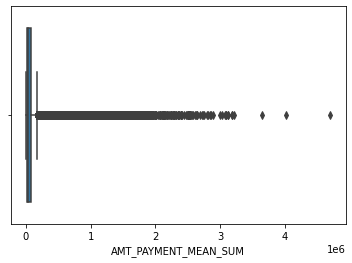

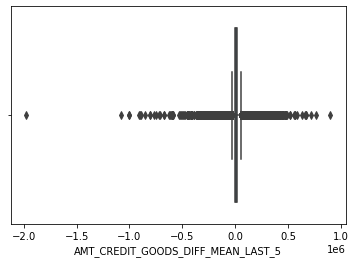

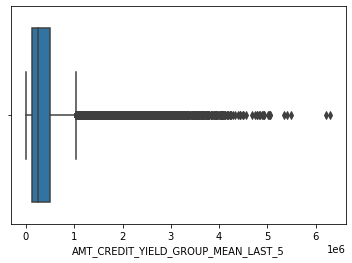

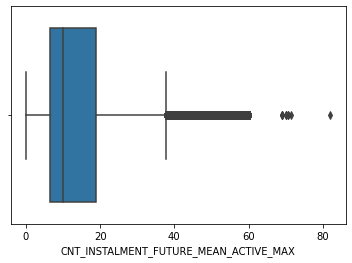

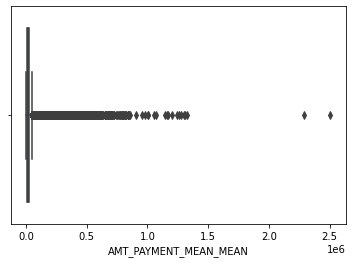

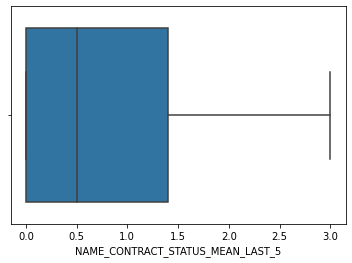

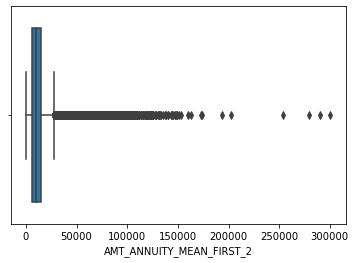

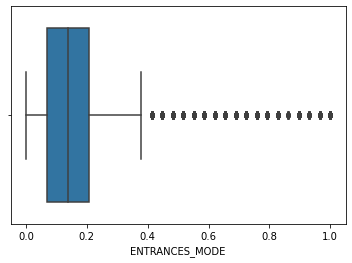

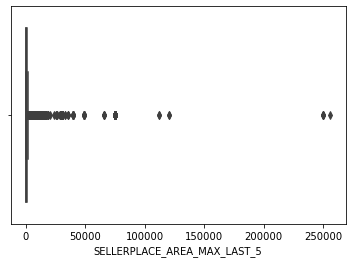

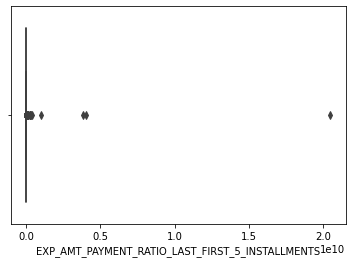

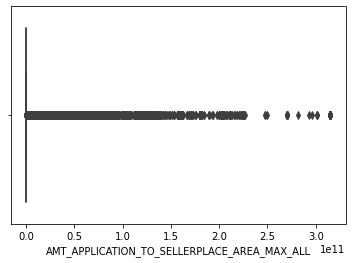

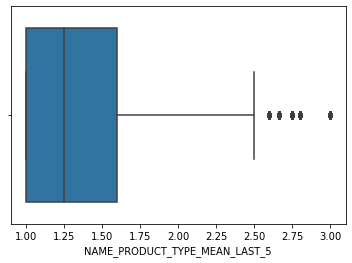

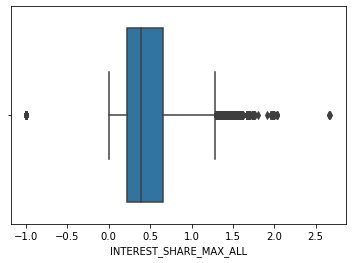

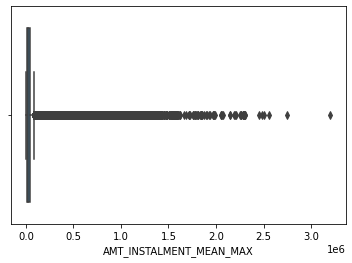

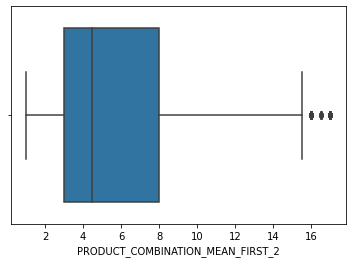

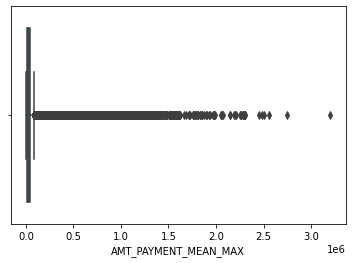

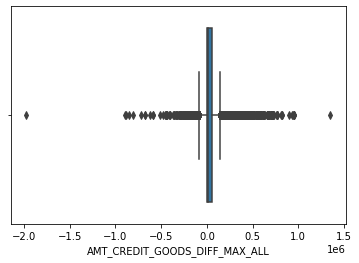

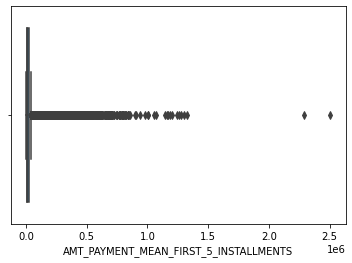

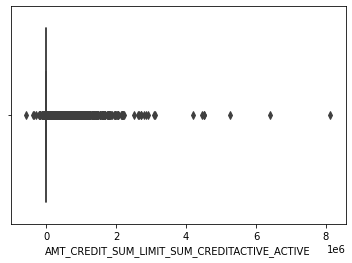

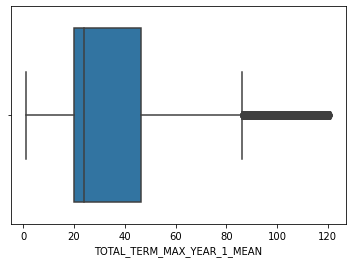

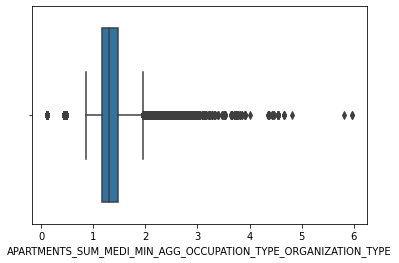

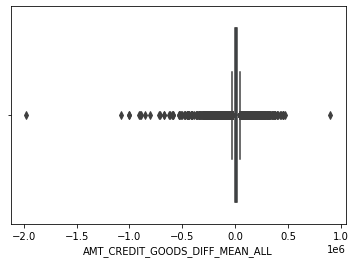

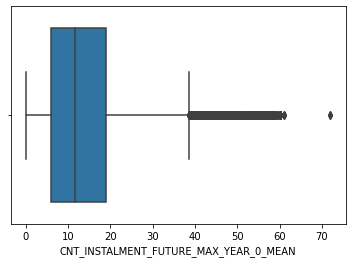

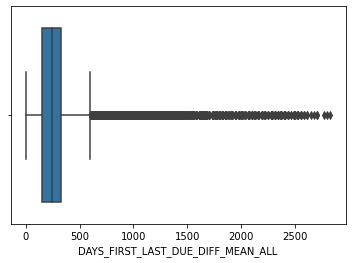

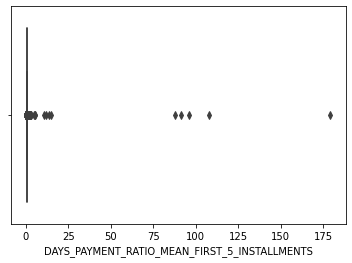

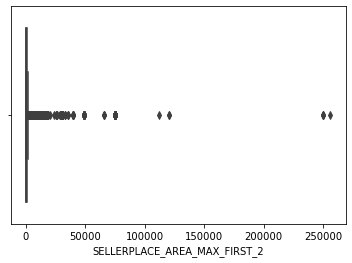

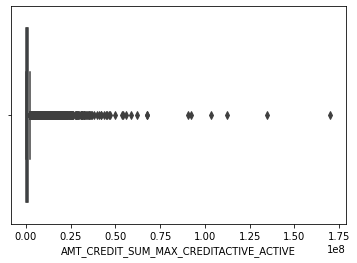

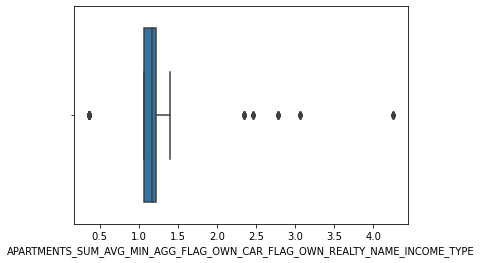

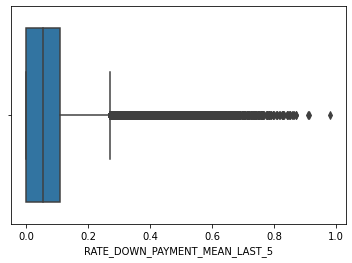

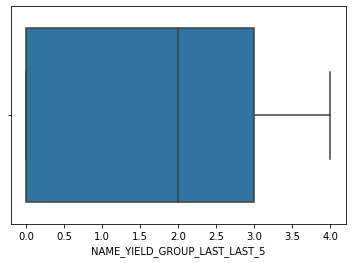

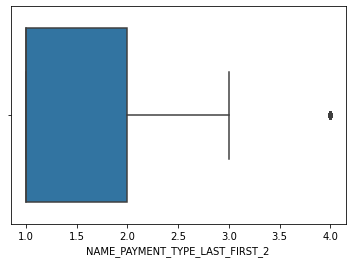

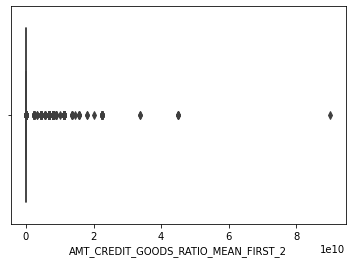

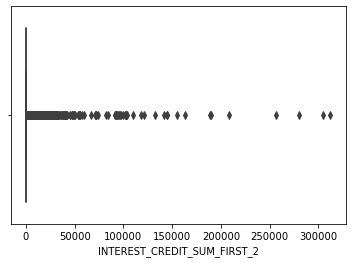

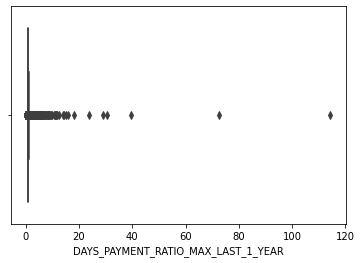

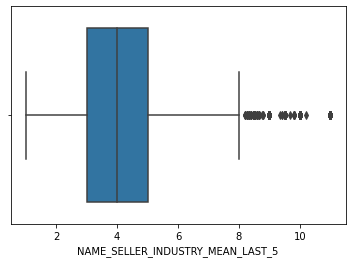

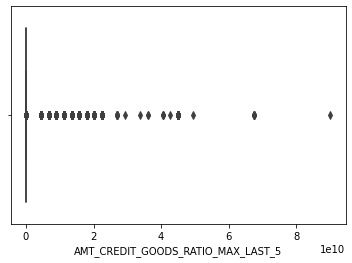

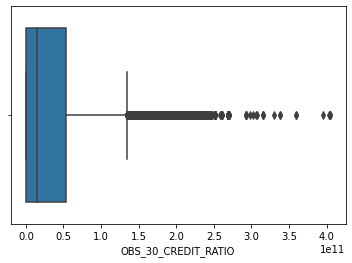

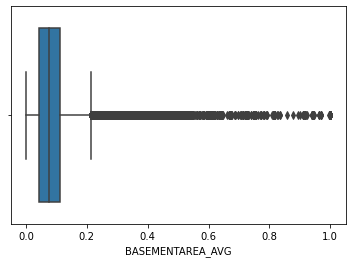

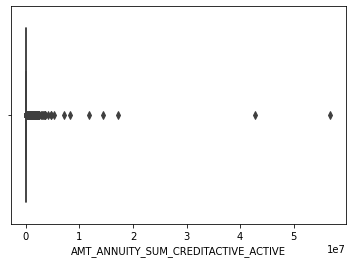

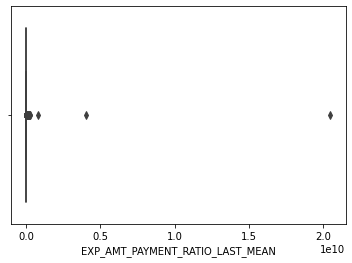

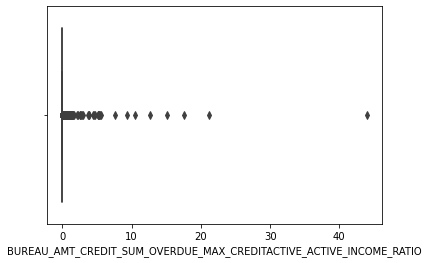

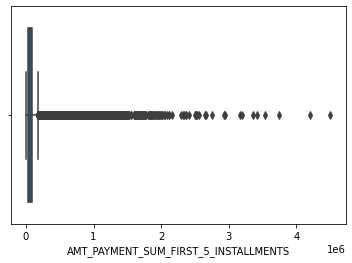

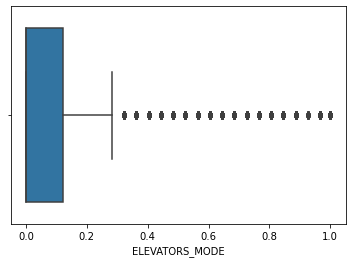

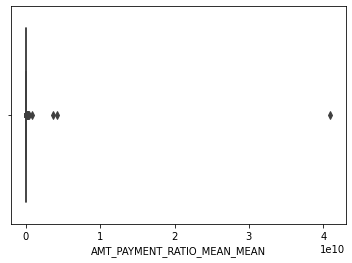

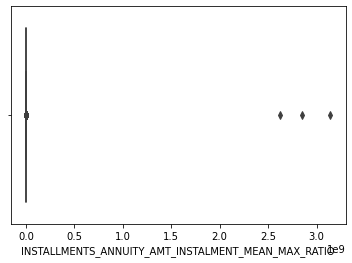

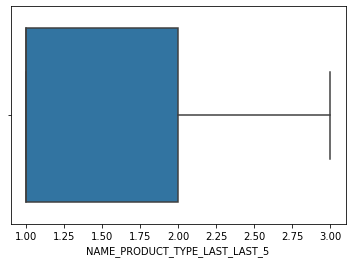

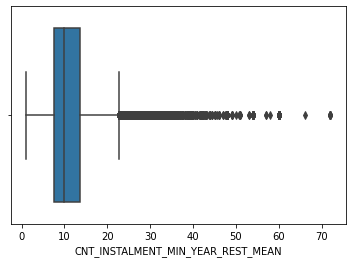

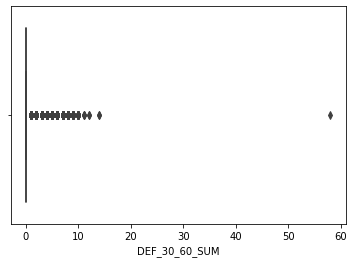

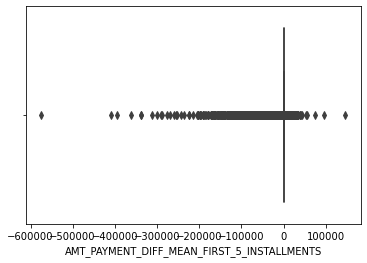

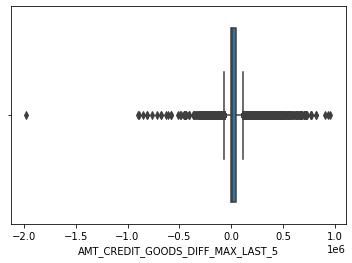

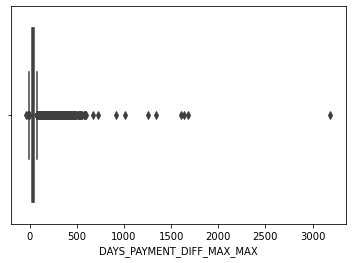

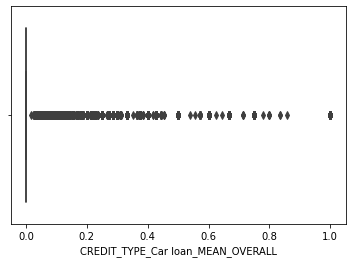

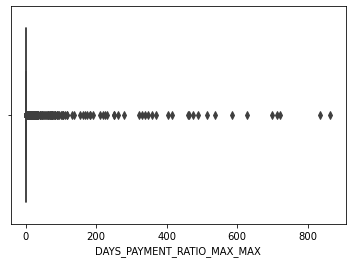

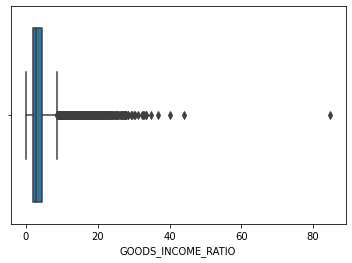

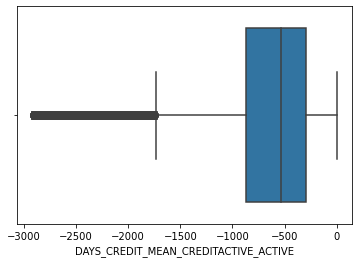

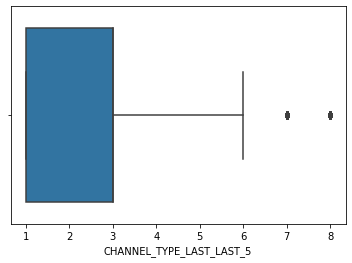

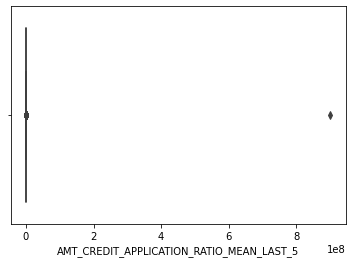

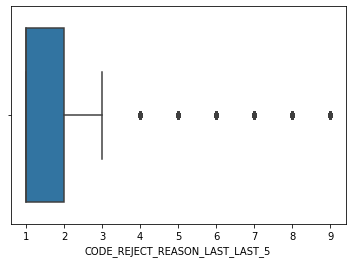

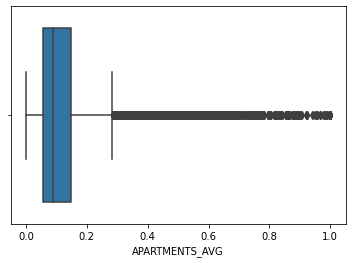

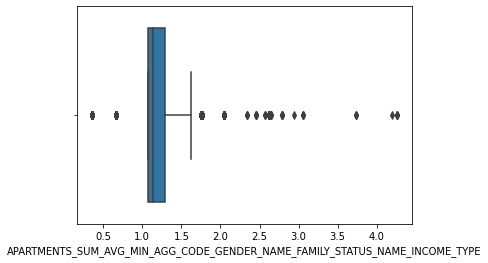

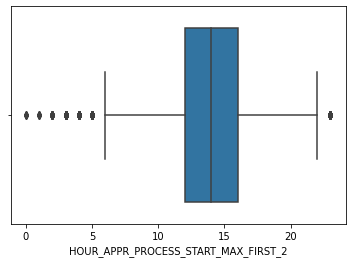

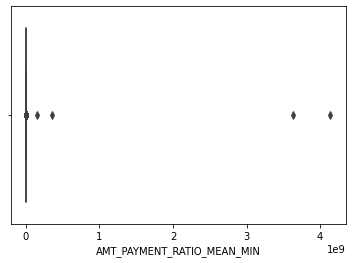

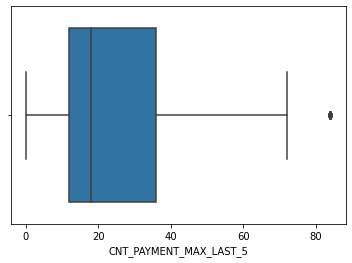

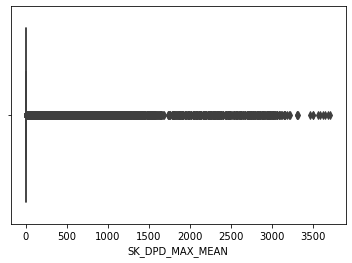

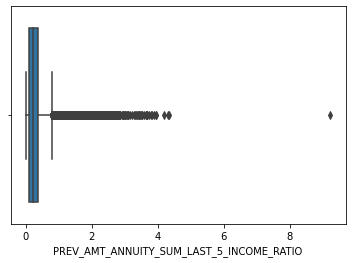

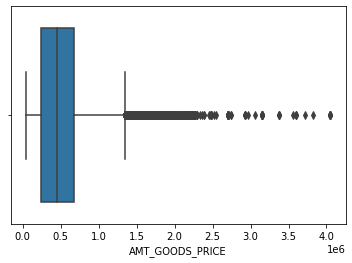

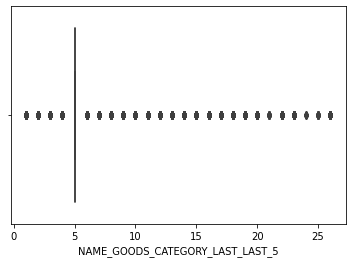

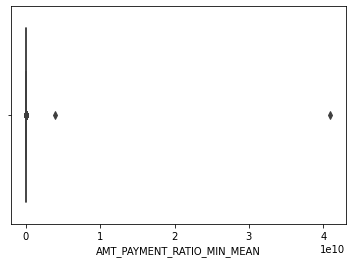

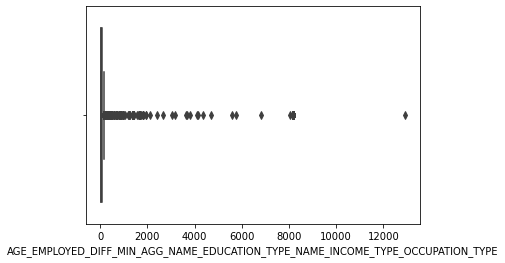

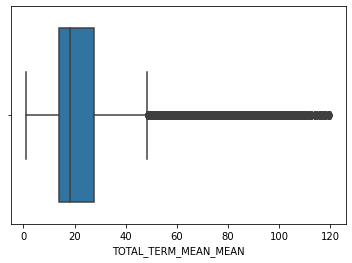

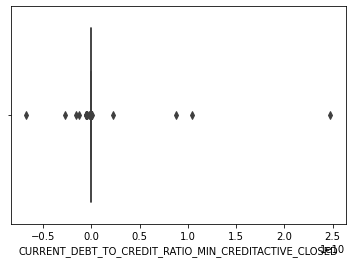

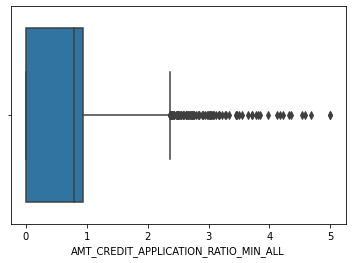

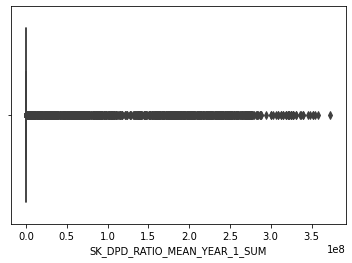

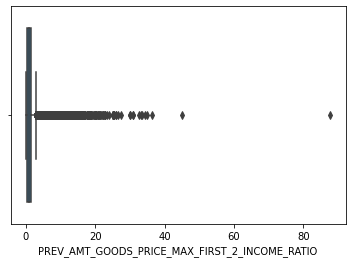

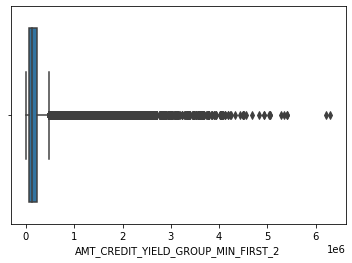

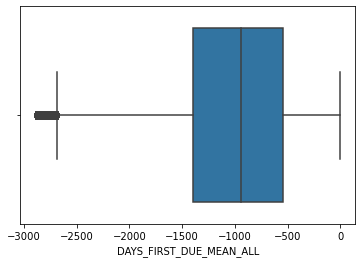

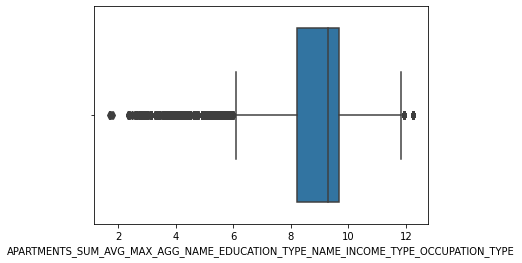

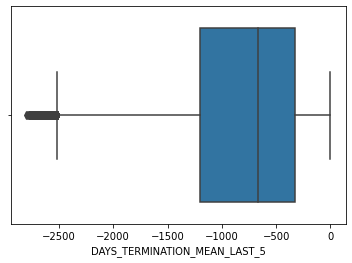

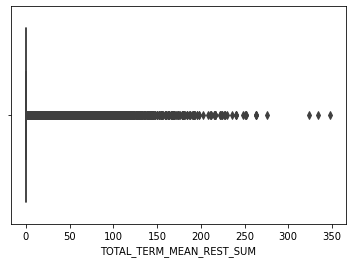

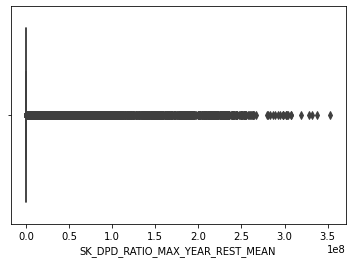

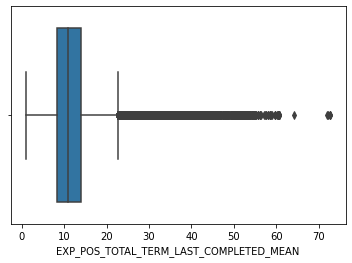

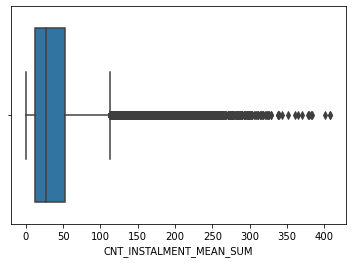

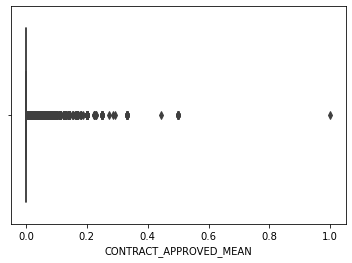

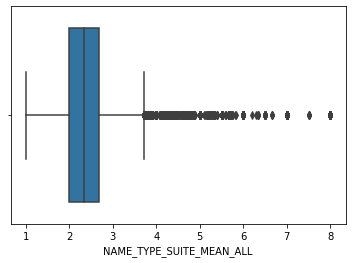

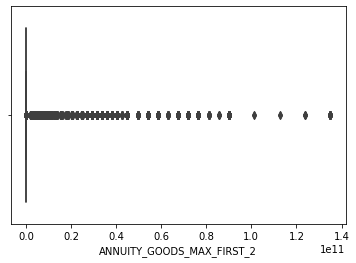

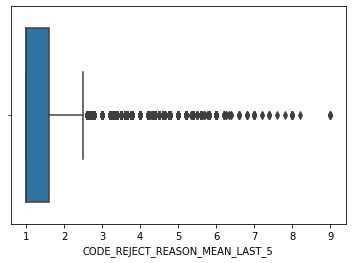

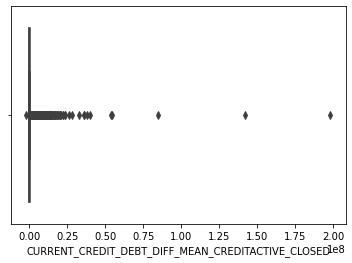

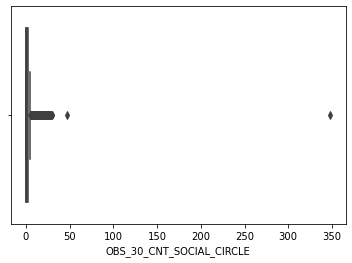

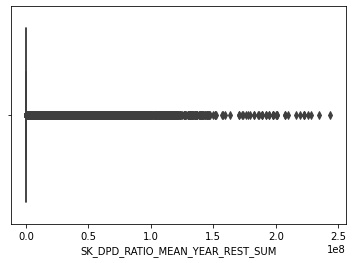

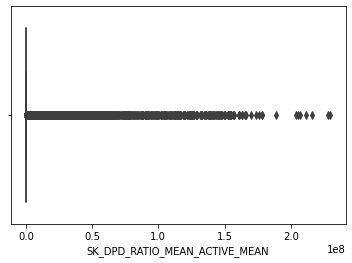

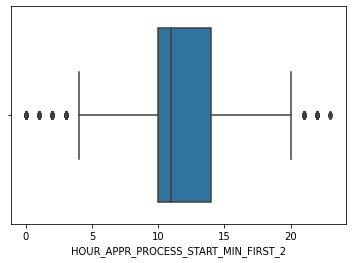

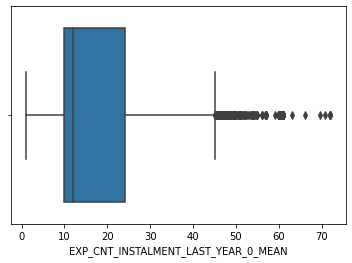

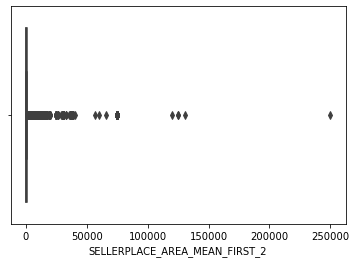

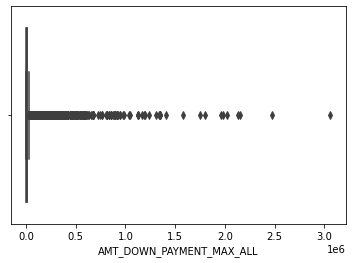

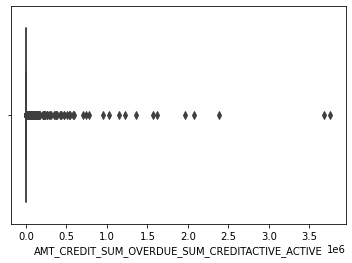

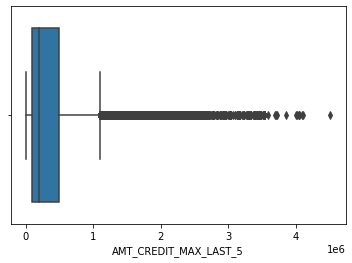

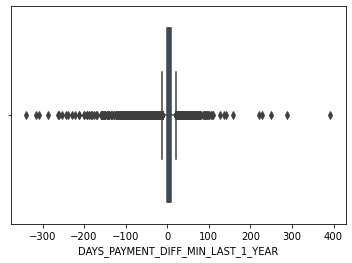

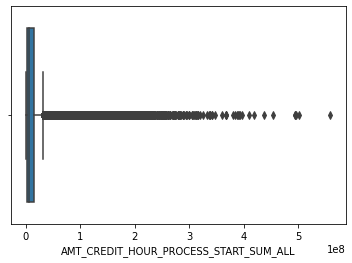

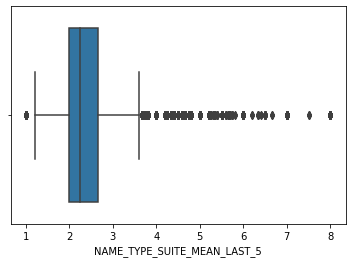

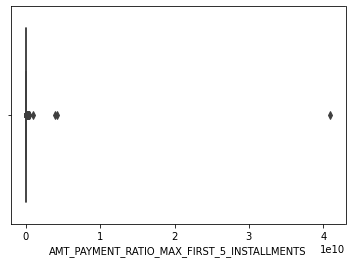

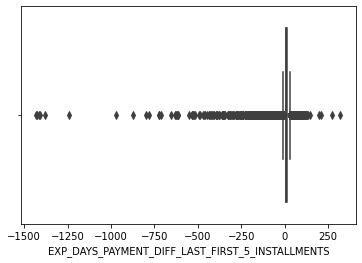

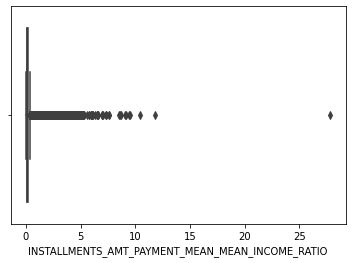

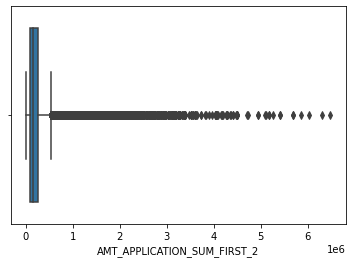

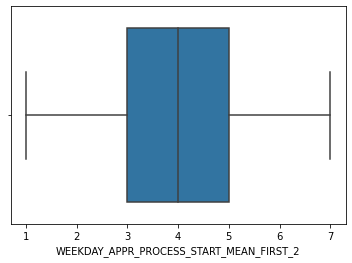

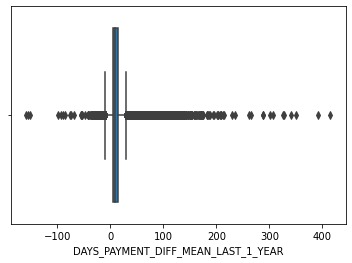

In [26]:
for variable in listeVariableAvecNaN:
    sns.boxplot(x = train_data[variable])
    plt.show()

Pour les variables qui possédant des outliers nous utiliserons la médiane comme remplacement des valeurs manquantes, pour les autres variables nous utiliserons la moyenne.

Il existe des moyens automatique pour la recherche des oultiers, comme l'intervalle inter-quartile notamment, mais pour être sûr du résultat, j'ai préféré regarder moi même les boxplots.

In [27]:
listeVariableMoyenne = ['NAME_YIELD_GROUP_MEAN_LAST_5', 'WEEKDAY_APPR_PROCESS_START_MEAN_ALL', 'DAYS_CREDIT_MEAN_CREDITACTIVE_CLOSED', 'CREDIT_TYPE_Consumer credit_MEAN_OVERALL', 'INTEREST_SHARE_MIN_LAST_5', 'CREDIT_ACTIVE_Closed_MEAN_OVERALL', 'DAYS_LAST_DUE_1ST_VERSION_MEAN_FIRST_2', 'NAME_YIELD_GROUP_MEAN_ALL', 'INTEREST_RATE_MIN_ALL', 'INTEREST_SHARE_MIN_ALL', 'DAYS_DECISION_MIN_LAST_5', 'DAYS_DECISION_MIN_FIRST_2', 'PRODUCT_COMBINATION_LAST_LAST_5', 'DAYS_LAST_DUE_MEAN_FIRST_2', 'NAME_CLIENT_TYPE_MEAN_ALL', 'DAYS_DECISION_MIN_ALL', 'DAYS_DECISION_MEAN_FIRST_2', 'NAME_CONTRACT_STATUS_MAX_ALL', 'DAYS_CREDIT_LAST_CREDITACTIVE_CLOSED', 'DAYS_FIRST_DUE_MEAN_FIRST_2', 'NAME_YIELD_GROUP_LAST_FIRST_2', 'WEEKDAY_APPR_PROCESS_START_MAX_FIRST_2', 'DAYS_FIRST_DUE_MAX_FIRST_2', 'WEEKDAY_APPR_PROCESS_START_MIN_LAST_5', 'DAYS_TERMINATION_MEAN_FIRST_2', 'INTEREST_RATE_MIN_LAST_5', 'DAYS_CREDIT_MIN_CREDITACTIVE_CLOSED', 'DAYS_DECISION_MAX_FIRST_2', 'CREDIT_ACTIVE_Active_MEAN_OVERALL', 'DAYS_TERMINATION_MAX_FIRST_2', 'MISSING_VALUES_TOTAL_PREV_SUM_LAST_5', 'NAME_CONTRACT_STATUS_LAST_LAST_5', 'WEEKDAY_APPR_PROCESS_START_MEAN_LAST_5', 'NAME_PORTFOLIO_LAST_LAST_5', 'NFLAG_INSURED_ON_APPROVAL_SUM_FIRST_2', 'PRODUCT_COMBINATION_LAST_FIRST_2', 'WEEKDAY_APPR_PROCESS_START_MIN_FIRST_2', 'NAME_CLIENT_TYPE_LAST_FIRST_2', 'NAME_CONTRACT_STATUS_MEAN_LAST_5', 'NAME_YIELD_GROUP_LAST_LAST_5', 'NAME_PRODUCT_TYPE_LAST_LAST_5', 'WEEKDAY_APPR_PROCESS_START_MEAN_FIRST_2']

In [28]:
listeVariableTrainData = train_data.columns.tolist()

In [29]:
listeVariableMédianne = listeVariableTrainData
for elt in listeVariableMoyenne:
    listeVariableMédianne.remove(elt)

In [30]:
for variable in listeVariableMoyenne:
    train_data[variable].fillna(value = train_data[variable].mean(), inplace=True) 

In [31]:
for variable in listeVariableMédianne:
    train_data[variable].fillna(value = train_data[variable].median(), inplace=True) 

In [32]:
train_data.head(5)

BUREAU_DAYS_CREDIT_MAX_CREDITACTIVE_ACTIVE_EMPLOYED_DIFF  \
0                                                     534.0   
1                                                     582.0   
2                                                    1352.0   
3                                                    1352.0   
4                                                    1352.0   

   ANNUITY_GOODS_SUM_LAST_5  EXP_CNT_INSTALMENT_FUTURE_LAST_YEAR_0_MEAN  \
0                  7460.622                                       6.668   
1                136983.970                                       4.200   
2                  6070.485                                       4.200   
3                 39593.734                                       4.293   
4                 44458.723                                       7.168   

   AMT_INTEREST_MAX_ALL  DAYS_PAYMENT_RATIO_MIN_FIRST_5_INSTALLMENTS  \
0              42987.60                                       0.9507   
1             144401.94                                       0.9893   
2               1323.00                                       0.9863   
3             662797.80                                       0.8840   
4             340127.28                                       0.9880   

   EXT_SOURCE_1_MIN_AGG_FLAG_OWN_CAR_FLAG_OWN_REALTY_NAME_INCOME_TYPE  \
0                                                             0.01718   
1                                                             0.02495   
2                                                             0.01505   
3                                                             0.01718   
4                                                             0.01718   

   DAYS_PAYMENT_DIFF_MAX_LAST_1_YEAR  EXP_CNT_INSTALMENT_FUTURE_LAST_MEAN  \
0                               24.0                                6.668   
1                               19.0                                1.529   
2                               19.0                                0.946   
3                               18.0                                3.318   
4                               12.0                                3.467   

   EXP_CNT_INSTALMENT_FUTURE_LAST_ACTIVE_MEAN  CNT_NON_CHILDREN  \
0                                       6.668               1.0   
1                                       2.992               2.0   
2                                       2.460               1.0   
3                                       6.934               2.0   
4                                       4.066               1.0   

   EXT_SOURCE_1_MAX_AGG_CODE_GENDER_NAME_FAMILY_STATUS_NAME_INCOME_TYPE  \
0                                                                0.8945   
1                                                                0.9420   
2                                                                0.8945   
3                                                                0.9240   
4                                                                0.8945   

   DEF_60_CREDIT_RATIO  CNT_INSTALMENT_MEAN_YEAR_1_MEAN  FLAG_DOCUMENT_9  \
0         2.032977e+05                           24.000                0   
1         1.293502e+11                            8.586                0   
2         1.350000e+10                           12.000                0   
3         3.126825e+10                           10.000                0   
4         5.130000e+10                           20.550                0   

   SK_DPD_DEF_SUM_YEAR_0_MEAN  \
0                         0.0   
1                         0.0   
2                         0.0   
3                         0.0   
4                         0.0   

   EXT_SOURCE_2_MEAN_AGG_CODE_GENDER_NAME_FAMILY_STATUS_NAME_INCOME_TYPE  \
0                                                                 0.4610   
1                                                                 0.5366   
2                                                                 0.4610   
3                       

Nous pouvons maintenant standardiser nos valeurs:

In [ ]:
colonneNumériqueTrain = train_data.select_dtypes(['int64','float64']).columns
colonneNumériqueTest = test_data.select_dtypes(['int64','float64']).columns

std = StandardScaler()
train_data[colonneNumériqueTrain] = std.fit_transform(train_data[colonneNumériqueTrain])

In [ ]:
train_data.head(5)

Nous allons dans un premier temps essayer d'entraîner les modèles et de les optimiser avec GridSearchCV, ensuite nous essayerons d'optimiser les modèles avec HyperOpt.

Nous allons nous intéresser à 3 modèles basés sur les arbres de décision, nous avons vu dans un projet précèdent que l'on obtenait de meilleurs résultats avec ce type de modèle (Mais il faut rester vigilant tout de même au type de données  que l'on a).

Les modèles qui seront utilisés ici seront Random Forest, XGBoost et LightGBM.

Avant d'optimiser les modèles nous allons regarder ce que nous obtenons avec les paramètres par défaut de chaque modèle, afin de voir s'il y a une amélioration ou non par la suite.

Dans un premier temps crééons nos jeu d'entrainment et de test:

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_data, target_train['TARGET'], test_size=0.30, random_state=SEED)

In [ ]:
stratified_kfold = StratifiedKFold(n_splits = 5, shuffle = True, random_state = SEED)

### Random Forest

In [ ]:
clf = RandomForestClassifier(random_state = SEED)

In [ ]:
clf.get_params()

In [ ]:
#clf.fit(X_train, y_train)

Maintenant que notre modèle est entrainé, nous allons regarder quelques informations sur ce dernier, ils nous permettront de faire un choix pour un modèle entre tous les modèles entrainés.

Pour ça nous allons créer une fonction qui nous donnera ces différentes informations.

En plus de la valeur AUC, nous afficherons égalment les scores de Rappel et de Précision. Pous nous aider nous allons créer 3 fonctions:

Le score de rappel est le rapport tp / (tp + fn) où tp est le nombre de vrais positifs et fn le nombre de faux négatifs. Le rappel est intuitivement la capacité du classificateur à trouver tous les échantillons positifs.

La score de précision est le rapport tp / (tp + fp) où tp est le nombre de vrais positifs et fp le nombre de faux positifs. La précision est intuitivement la capacité du classificateur à ne pas étiqueter comme positif un échantillon négatif.

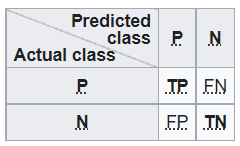

Nous pouvons également mesurer la mesure F (Fbeta_score), la mesure Fbeta est la moyenne harmonique pondérée entre précision et rappel:

    F0.5-Measure (beta=0.5): More weight on precision, less weight on recall.
    F1-Measure (beta=1.0): Balance the weight on precision and recall.
    F2-Measure (beta=2.0): Less weight on precision, more weight on recall

En plus de la fonction Fbeta_score de Sklearn, nous allons utiliser les formules existantes, la plus courante est la formule 1 mais la 2 existe aussi.

Première formule:

    fb = (1 + beta_squared) x precision x recall / (beta_squared x precision + recall + epsilon)

Deuxième formule:

    Fb = 1/(beta x (1/precision)+(1-beta) x (1/recall))

In [ ]:
def mesureF1(beta, precision, recall, epsilon):
    beta_squared = beta**2   
    formule1 = (1 + beta_squared)*(precision*recall / (beta_squared*precision + recall + epsilon))        
    formule2 = 1/(beta*(1/precision)+(1-beta)*(1/recall))
    return formule1, formule2

In [ ]:
def recuperationTP_FN_FP_TN(y_test, y_pred):
    tp, fn, fp, tn = confusion_matrix(y_test, y_pred).ravel()
    return tp, fn, fp, tn

def rappelScore(tp, fn):
    return tp/(tp + fn)

def precisionScore(tp, fp):
    return tp/(tp + fp)

In [ ]:
def informationModele(X_test, y_test, modeleEntraine):
    testScore = modeleEntraine.score(X_test, y_test)
    print('Test Score: ', testScore)
    
    y_pred = modeleEntraine.predict(X_test)
    
    print("Confusion Matrix of CV data:")
    conf_mat = confusion_matrix(y_test, y_pred)
    conf_mat = pd.DataFrame(conf_mat, columns = ['Solvable(0)','Non Solvable(1)'], index = ['0','1'])
    plt.figure(figsize = (7,6))
    plt.title('Confusion Matrix Heatmap')
    sns.heatmap(conf_mat, annot = True, fmt = 'g', linewidth = 0.5, annot_kws = {'size' : 15})
    plt.show()
    
    print("MSE : ", mean_squared_error(y_test, y_pred))
    print("RMSE : ", math.sqrt(mean_squared_error(y_test, y_pred)))
    
    y_predProba = modeleEntraine.predict_proba(X_test)[::,1]

    auc_xg = roc_auc_score(y_test, y_predProba)
    fpr_xg, tpr_xg, thresholds_xg = roc_curve(y_test, y_predProba)
    plt.figure(figsize=(12, 7))
    plt.plot(fpr_xg, tpr_xg, label=f'AUC (xgboost) = {auc_xg:.2f}')
    plt.plot([0, 1], [0, 1], color='blue', linestyle='--', label='Baseline')
    plt.title('ROC Curve', size=20)
    plt.xlabel('False Positive Rate', size=14)
    plt.ylabel('True Positive Rate', size=14)
    plt.legend();
    
    tp, fp, fn, tn = recuperationTP_FN_FP_TN(y_test, y_pred)
    print("Score de Rappel:", round(rappelScore(tp, fn), 5))
    print("Score de Precision:", round(precisionScore(tp, fp), 5))
    
    print("\nFBeta_Score en utilisant la formule de Sklearn:")
    mesureF = fbeta_score(y_test, y_pred, beta = 1)
    mesureF05 = fbeta_score(y_test, y_pred, beta = 0.5)
    mesureF2 = fbeta_score(y_test, y_pred, beta = 2)
    print("Mesure F:", mesureF)
    print("Mesure F05:", mesureF05)
    print("Mesure F2:", mesureF2)

    print("\nFBeta_Score en utilisant les formule de la littérature:")
    print("Le premier chiffre est le résultat de la formule 1 et le 2 celui de la formule 2")
    precision = precisionScore(tp, fp)
    recall = rappelScore(tp, fn)

    mesureFcalcul = mesureF1(1, precision, recall, 1e-7)
    mesureF05calcul = mesureF1(0.5, precision, recall, 1e-7)
    mesureF2calcul = mesureF1(2, precision, recall, 1e-7)
    print("Mesure F:", mesureFcalcul)
    print("Mesure F05:", mesureF05calcul)
    print("Mesure F2:", mesureF2calcul)

In [ ]:
#informationModele(X_test, y_test, clf)

In [ ]:
#precision_recall_fscore_support(y_test, y_pred)

### XGBoost

In [ ]:
xgb = XGBClassifier(random_state = SEED)

In [ ]:
xgb.fit(X_train, y_train)

In [ ]:
informationModele(X_test, y_test, xgb)

### LightGBM

In [ ]:
lgbm = LGBMClassifier(random_state = SEED)

In [ ]:
lgbm.get_params()

In [ ]:
lgbm.fit(X_train, y_train)

In [ ]:
informationModele(X_test, y_test, lgbm)

Nous allons donc essayer d'améliorer ces résultats.

## Optimisation avec GridSearchCV

### Random Forest

Pour une question de temps nous rechercherons les meilleurs hyperparamètres une fois avec 5000 lignes et ensuite nous entraînerons le dataset entier avec ces hyperparamètres, ce ne sera pas optimal malheureusement.

In [ ]:
X_train5000 = X_train[0:5000]

In [ ]:
y_train5000 = y_train[0:5000]

In [ ]:
#param_rfr = {'n_estimators' : [500, 800, 1200, 1500],
#             'max_depth' : [15, 20, 25, 30, None],            
#             'max_features': ['auto', 'sqrt', 'log2'],
#             'min_samples_leaf': [5, 10, 15, 20, 25],
#             'min_samples_split': [5, 10, 15, 20, 25]}
#
#gs_randomForestClassifier = GridSearchCV(RandomForestClassifier(),
#                 param_grid = param_rfr,            
#                  verbose = 2,
#                  cv = cv_train,
#                  scoring='roc_auc', 
#                  refit='roc_auc',
#                  return_train_score = True,                  
#                  n_jobs = -1
#                 )
#
#
#gs_randomForestClassifier.fit(X_train5000, y_train5000)

In [ ]:
# print('Nous avons les meilleurs résultats avec les paramètres: \n', gs_randomForestClassifier.best_params_)
# {'max_depth': 25, 'max_features': 'auto', 'min_samples_leaf': 25, 'min_samples_split': 20, 'n_estimators': 1200}

In [ ]:
#rfc = RandomForestClassifier(max_depth = 25, max_features = 'auto', n_estimators = 1200, min_samples_leaf = 25, min_samples_split = 20, random_state = SEED)

In [ ]:
#rfc.fit(X_train, y_train)

In [ ]:
#informationModele(X_test, y_test, rfc)

### XGBoost

In [ ]:
#param_xgb = {'max_depth' : [5, 10],
#              'min_child_weight' : [75, 80],
#              'gamma' : [0.5, 1],
#              'subsample' : [0.5, 1],
#              'colsample_bytree' : [0.5, 1],
#              'colsample_bylevel' : [0.5, 1],
#              'colsample_bynode' : [0.5, 1],
#              'reg_alpha' : [0.1, 0.3],
#              'reg_lambda' : [0.1, 0.3]}
#
#gs_XGBClassifier = GridSearchCV(XGBClassifier(),
#                 param_grid = param_xgb,            
#                  verbose = 2,
#                  cv = cv_train,
#                  scoring='roc_auc', 
#                  refit='roc_auc',
#                  return_train_score = True,                  
#                  n_jobs = -1
#                 )
#
#gs_XGBClassifier.fit(X_train5000, y_train5000)

In [ ]:
#print('Nous avons les meilleurs résultats avec les paramètres: \n', gs_XGBClassifier.best_params_)
#
#Nous avons les meilleurs résultats avec les paramètres: 
# {'colsample_bylevel': 0.5, 'colsample_bynode': 0.5, 'colsample_bytree': 0.5, 'gamma': 0.5, 'max_depth': 5,
#  'min_child_weight': 75, 
#  'reg_alpha': 0.3, 'reg_lambda': 0.3, 'subsample': 1}

In [ ]:
xgbGrid = XGBClassifier(colsample_bytree = 0.5, colsample_bynode = 0.5, colsample_bylevel = 0.5, gamma = 0.5, max_depth = 5, min_child_weight = 75, reg_alpha = 0.3, reg_lambda = 0.3, subsample = 1, random_state = SEED)

In [ ]:
xgbGrid.fit(X_train, y_train)

In [ ]:
informationModele(X_test, y_test, xgbGrid)

Nous pouvons voir une légère amélioration du score AUC après avoir entraîné le modèle et opter pour les meilleurs Hyperparamètre, mais regardons si nous pouvons encore l'améliorer un peu.

### LightGBM

In [ ]:
#param_lgbm = {'num_leaves' : [35, 40, 45],
#              'max_depth' : [5, 10],
#              'min_split_gain' : [0, 0.1],
#              'min_child_weight' : [30, 35],
#              'min_child_samples' : [30, 35],
#              'subsample' : [0.5, 1],
#              'colsample_bytree' : [0.5, 1],
#              'reg_alpha' : [0.1, 0.3],
#              'reg_lambda' : [0.1, 0.3]}
#
#gs_LGBMClassifier = GridSearchCV(LGBMClassifier(),
#                  param_grid = param_lgbm,            
#                  verbose = 2,
#                  cv = cv_train,
#                  scoring='roc_auc', 
#                  refit='roc_auc',
#                  return_train_score = True,                  
#                  n_jobs = -1
#                 )
#
#gs_LGBMClassifier.fit(X_train5000, y_train5000)

In [ ]:
#print('Nous avons les meilleurs résultats avec les paramètres: \n', gs_LGBMClassifier.best_params_)
#
#Nous avons les meilleurs résultats avec les paramètres: 
# {'colsample_bytree': 0.5, 'max_depth': 5, 'min_child_samples': 35, 'min_child_weight': 35, 'min_split_gain': 0, 
#  'num_leaves': 35, 'reg_alpha': 0.1, 'reg_lambda': 0.3, 'subsample': 0.5}

In [ ]:
lgbmGrid = LGBMClassifier(colsample_bytree = 0.5, max_depth = 5, min_child_samples = 35, min_child_weight = 35, min_split_gain = 0, num_leaves = 35, reg_alpha = 0.1, reg_lambda = 0.3, subsample = 0.5, random_state = SEED)

In [ ]:
lgbmGrid.fit(X_train, y_train)

In [ ]:
informationModele(X_test, y_test, lgbmGrid)

## Utilisation de SMOTE

Pour la suite nous allons regarder ce que nous obtenons en utilisant SMOTE (Synthetic Minority Over-Sampling TEchnique) qui est une technique utilisée pour traiter des ensembles de données déséquilibrées.

In [ ]:
#!pip install imblearn

In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.under_sampling import RandomUnderSampler

In [ ]:
smote = SMOTE(random_state = SEED)

X_train5000SMOTE, y_train5000SMOTE = smote.fit_resample(X_train5000, y_train5000)
X_trainSMOTE, y_trainSMOTE = smote.fit_resample(X_train, y_train)

In [ ]:
from collections import Counter
counter = Counter(y_train)
print(counter)
counterSMOTE = Counter(y_trainSMOTE)
print(counterSMOTE)

### Random Forest

In [ ]:
#param_rfrSMOTE1 = {'n_estimators' : [800, 1200, 1500],
#             'max_depth' : [15, 20, 25],            
#             'max_features': ['auto', 'sqrt', 'log2'],
#             'min_samples_leaf': [20, 25, 30],
#             'min_samples_split': [15, 20, 25]}
#
#grid_searchRFRSMOTE1 = GridSearchCV(estimator = RandomForestClassifier(),
#                           param_grid = param_rfrSMOTE1,
#                           verbose = 2,
#                           cv = stratified_kfold,
#                           scoring = 'roc_auc',
#                           refit='roc_auc',
#                           return_train_score = True,
#                           n_jobs=-1)
#
#grid_searchRFRSMOTE1.fit(X_train5000SMOTE, y_train5000SMOTE)

In [ ]:
#print('Nous avons les meilleurs résultats avec les paramètres: \n', grid_searchRFRSMOTE1.best_params_)
#
#Nous avons les meilleurs résultats avec les paramètres: 
#{'modelRandomForestSMOTE1__max_depth': 25, 'modelRandomForestSMOTE1__max_features': 'log2', 'modelRandomForestSMOTE1__min_samples_leaf': 20, 'modelRandomForestSMOTE1__min_samples_split': 25, 'modelRandomForestSMOTE1__n_estimators': 1200

In [ ]:
grid_searchRFRSMOTE1 = RandomForestClassifier(max_depth = 25, max_features = 'log2', min_samples_leaf = 20, min_samples_split = 25, n_estimators = 1200)

In [ ]:
#grid_searchRFRSMOTE1 = grid_searchRFRSMOTE1.fit(X_trainSMOTE, y_trainSMOTE)

In [ ]:
#informationModele(X_test, y_test, grid_searchRFRSMOTE1)

### XGBoost

In [ ]:
#param_xgbSMOTE1 = {'max_depth' : [5, 10],
#              'min_child_weight' : [75, 80],
#              'gamma' : [0.5, 1],
#              'subsample' : [0.5, 1],
#              'colsample_bytree' : [0.5, 1],
#              'colsample_bylevel' : [0.5, 1],
#              'colsample_bynode' : [0.5, 1],
#              'reg_alpha' : [0.1, 0.3],
#              'reg_lambda' : [0.1, 0.3]}
#
#grid_searchXGBSMOTE1 = GridSearchCV(estimator = XGBClassifier(),
#                           param_grid = param_xgbSMOTE1,
#                           verbose = 2,
#                           cv = stratified_kfold,
#                           scoring = 'roc_auc',
#                           refit='roc_auc',
#                           return_train_score = True,
#                           n_jobs=-1)
#
#grid_searchXGBSMOTE1.fit(X_train5000SMOTE, y_train5000SMOTE)

In [ ]:
#print('Nous avons les meilleurs résultats avec les paramètres: \n', grid_searchXGBSMOTE1.best_params_)
#
#Nous avons les meilleurs résultats avec les paramètres: 
#{'modelXGBSMOTE1__colsample_bylevel': 1, 'modelXGBSMOTE1__colsample_bynode': 0.5, 'modelXGBSMOTE1__colsample_bytree': 0.5, 'modelXGBSMOTE1__gamma': 1, 'modelXGBSMOTE1__max_depth': 10, 'modelXGBSMOTE1__min_child_weight': 80, 'modelXGBSMOTE1__reg_alpha': 0.3, 'modelXGBSMOTE1__reg_lambda': 0.3, 'modelXGBSMOTE1__subsample': 1

In [ ]:
grid_searchXGBSMOTE1 = XGBClassifier(colsample_bylevel = 0.5, colsample_bynode = 1, colsample_bytree = 0.5, gamma = 0.5, max_depth = 5, min_child_weight = 75, reg_alpha = 0.3, reg_lambda = 0.3, subsample = 1, random_state = SEED)

In [ ]:
grid_searchXGBSMOTE1 = grid_searchXGBSMOTE1.fit(X_trainSMOTE, y_trainSMOTE)

In [ ]:
informationModele(X_test, y_test, grid_searchXGBSMOTE1)

### LightGBM

In [ ]:
#param_lgbmSMOTE1 = {'num_leaves' : [35, 40, 45],
#              'max_depth' : [5, 10],
#              'min_split_gain' : [0, 0.1],
#              'min_child_weight' : [30, 35],
#              'min_child_samples' : [30, 35],
#              'subsample' : [0.5, 1],
#              'colsample_bytree' : [0.5, 1],
#              'reg_alpha' : [0.1, 0.3],
#              'reg_lambda' : [0.1, 0.3]}
#
#grid_searchLGBMSMOTE1 = GridSearchCV(estimator = LGBMClassifier(),
#                           param_grid = param_lgbmSMOTE1,
#                           verbose = 2,
#                           cv = stratified_kfold,
#                           scoring = 'roc_auc',
#                           refit='roc_auc',
#                           return_train_score = True,
#                           n_jobs=-1)
#
#grid_searchLGBMSMOTE1.fit(X_train5000SMOTE, y_train5000SMOTE)

In [ ]:
#print('Nous avons les meilleurs résultats avec les paramètres: \n', grid_searchLGBMSMOTE1.best_params_)
#
#Nous avons les meilleurs résultats avec les paramètres: 
#{'modelLGBMSMOTE1__colsample_bytree': 0.5, 'modelLGBMSMOTE1__max_depth': 10, 'modelLGBMSMOTE1__min_child_samples': 35, 'modelLGBMSMOTE1__min_child_weight': 30, 'modelLGBMSMOTE1__min_split_gain': 0, 'modelLGBMSMOTE1__num_leaves': 35, 'modelLGBMSMOTE1__reg_alpha': 0.3, 'modelLGBMSMOTE1__reg_lambda': 0.1, 'modelLGBMSMOTE1__subsample': 0.5

In [ ]:
grid_searchLGBMSMOTE1 = LGBMClassifier(colsample_bytree = 0.5, max_depth = 5, min_child_samples = 30, min_child_weight = 30, min_split_gain = 0, num_leaves = 35, reg_alpha = 0.1, reg_lambda = 0.1, subsample = 0.5, random_state = SEED)

In [ ]:
grid_searchLGBMSMOTE1 = grid_searchLGBMSMOTE1.fit(X_trainSMOTE, y_trainSMOTE)

In [ ]:
informationModele(X_test, y_test, grid_searchLGBMSMOTE1)

## Utilisation de SMOTE combiné avec un sous-échantillonnage de la classe majoritaire

In [ ]:
over = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('o', over), ('u', under)]
pipeline = imbpipeline(steps=steps)

X_trainSMOTE5000U, y_trainSMOTE5000U = pipeline.fit_resample(X_train5000, y_train5000)
X_trainSMOTEU, y_trainSMOTEU = pipeline.fit_resample(X_train, y_train)

In [ ]:
from collections import Counter
counter = Counter(y_train)
print(counter)
counterSMOTE = Counter(y_trainSMOTEU)
print(counterSMOTE)

In [ ]:
stratified_kfold = StratifiedKFold(n_splits = 3, shuffle = True, random_state = SEED)

### Random Forest

In [ ]:
#param_rfr = {'n_estimators' : [800, 1200, 1500],
#             'max_depth' : [15, 20, 25],            
#             'max_features': ['auto', 'sqrt', 'log2'],
#             'min_samples_leaf': [20, 25, 30],
#             'min_samples_split': [15, 20, 25]}
#
#grid_searchRFR = GridSearchCV(estimator = RandomForestClassifier(),
#                           param_grid = param_rfr,
#                           verbose = 2,
#                           cv = stratified_kfold,
#                           scoring = 'roc_auc',
#                           refit='roc_auc',
#                           return_train_score = True,
#                           n_jobs=-1)
#
#grid_searchRFR.fit(X_trainSMOTE5000U, y_trainSMOTE5000U)

In [ ]:
#print('Nous avons les meilleurs résultats avec les paramètres: \n', grid_searchRFR.best_params_)
#
#Nous avons les meilleurs résultats avec les paramètres: 
#{'modelRandomForest__max_depth': 20, 'modelRandomForest__max_features': 'auto', 'modelRandomForest__min_samples_leaf': 20, 'modelRandomForest__min_samples_split': 25, 'modelRandomForest__n_estimators': 1200

In [ ]:
grid_searchRFR = RandomForestClassifier(max_depth = 20, max_features = 'auto', min_samples_leaf = 20, min_samples_split = 25, n_estimators = 1200)

In [ ]:
#grid_searchRFR = grid_searchRFR.fit(X_trainSMOTEU, y_trainSMOTEU)

In [ ]:
#informationModele(X_test, y_test, grid_searchRFR)

### XGBoost

In [ ]:
#param_xgb = {'max_depth' : [5, 10],
#              'min_child_weight' : [75, 80],
#              'gamma' : [0.5, 1],
#              'subsample' : [0.5, 1],
#              'colsample_bytree' : [0.5, 1],
#              'colsample_bylevel' : [0.5, 1],
#              'colsample_bynode' : [0.5, 1],
#              'reg_alpha' : [0.1, 0.3],
#              'reg_lambda' : [0.1, 0.3]}
#
#grid_searchXGB = GridSearchCV(estimator = XGBClassifier(),
#                           param_grid = param_xgb,
#                           verbose = 2,
#                           cv = stratified_kfold,
#                           scoring = 'roc_auc',
#                           refit='roc_auc',
#                           return_train_score = True,
#                           n_jobs=-1)
#
#grid_searchXGB.fit(X_trainSMOTE5000U, y_trainSMOTE5000U)

In [ ]:
#print('Nous avons les meilleurs résultats avec les paramètres: \n', grid_searchXGB.best_params_)
#
#Nous avons les meilleurs résultats avec les paramètres: 
# {'colsample_bylevel': 0.5, 'colsample_bynode': 0.5, 'colsample_bytree': 0.5, 'gamma': 0.5, 'max_depth': 5, 'min_child_weight': 80, 'reg_alpha': 0.3, 'reg_lambda': 0.3, 'subsample': 1

In [ ]:
grid_searchXGB = XGBClassifier(colsample_bylevel = 0.5, colsample_bynode = 0.5, colsample_bytree = 0.5, gamma = 0.5, max_depth = 5, min_child_weight = 80, reg_alpha = 0.3, reg_lambda = 0.3, subsample = 1, random_state = SEED)

In [ ]:
grid_searchXGB = grid_searchXGB.fit(X_trainSMOTEU, y_trainSMOTEU)

In [ ]:
informationModele(X_test, y_test, grid_searchXGB)

### LightGBM

In [ ]:
#param_lgbm = {'num_leaves' : [35, 40, 45],
#              'max_depth' : [5, 10],
#              'min_split_gain' : [0, 0.1],
#              'min_child_weight' : [30, 35],
#              'min_child_samples' : [30, 35],
#              'subsample' : [0.5, 1],
#              'colsample_bytree' : [0.5, 1],
#              'reg_alpha' : [0.1, 0.3],
#              'reg_lambda' : [0.1, 0.3]}
#
#grid_searchLGBM = GridSearchCV(estimator = LGBMClassifier(),
#                           param_grid = param_lgbm,
#                           verbose = 2,
#                           cv = stratified_kfold,
#                           scoring = 'roc_auc',
#                           refit='roc_auc',
#                           return_train_score = True,
#                           n_jobs=-1)
#
#grid_searchLGBM.fit(X_trainSMOTE5000U, y_trainSMOTE5000U)

In [ ]:
#print('Nous avons les meilleurs résultats avec les paramètres: \n', grid_searchLGBM.best_params_)
#SMOTEU
#Nous avons les meilleurs résultats avec les paramètres: 
# {'colsample_bytree': 0.5, 'max_depth': 5, 'min_child_samples': 30, 'min_child_weight': 30, 'min_split_gain': 0, 'num_leaves': 35, 'reg_alpha': 0.1, 'reg_lambda': 0.1, 'subsample': 0.5

In [ ]:
grid_searchLGBM = LGBMClassifier(colsample_bytree = 0.5, max_depth = 5, min_child_samples = 30, min_child_weight = 30, min_split_gain = 0, num_leaves = 35, reg_alpha = 0.1, reg_lambda = 0.1, subsample = 0.5, random_state = SEED)

In [ ]:
grid_searchLGBM = grid_searchLGBM.fit(X_trainSMOTEU, y_trainSMOTEU)

In [ ]:
informationModele(X_test, y_test, grid_searchLGBM)

Nous allons maintenant regarder ce que nous obtenons avec HyperOpt.

Mais avant ça faisons une récapitulation rapide des différents résultats:

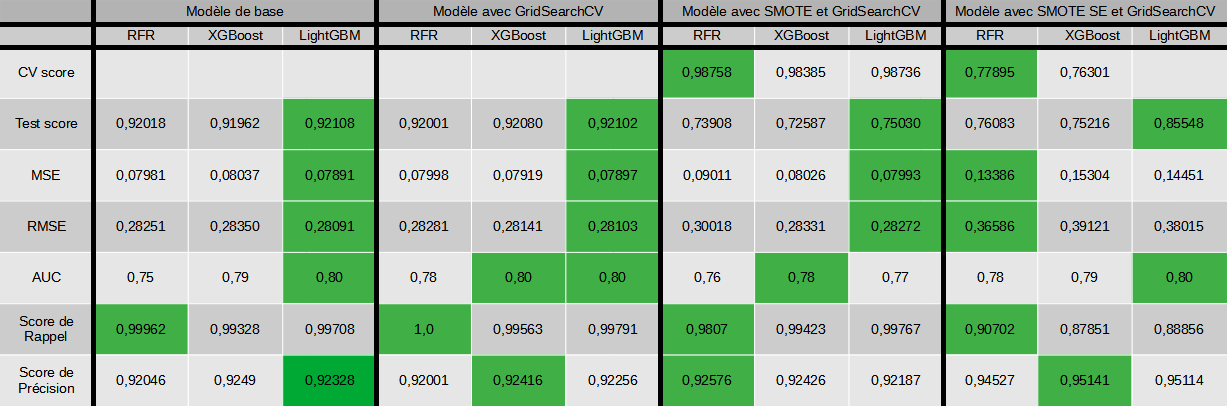

Nous pouvons que dans l'ensemble LightGBM est meilleur, nous pouvons également voir que nous avons de meilleurs résultats sans l'utilisation de SMOTE, que ce soit SMOTE seulement ou en combinant SMOTE avec un sous échantillonage.

Pour la suite nous utiliserons LightGBM, non seulement pour les résultats comme on a pu voir mais également le temps de calcul qui est bien meilleur que les autres.

Regardons maintenant une récapitulation rapide du FScore des différents modèles:

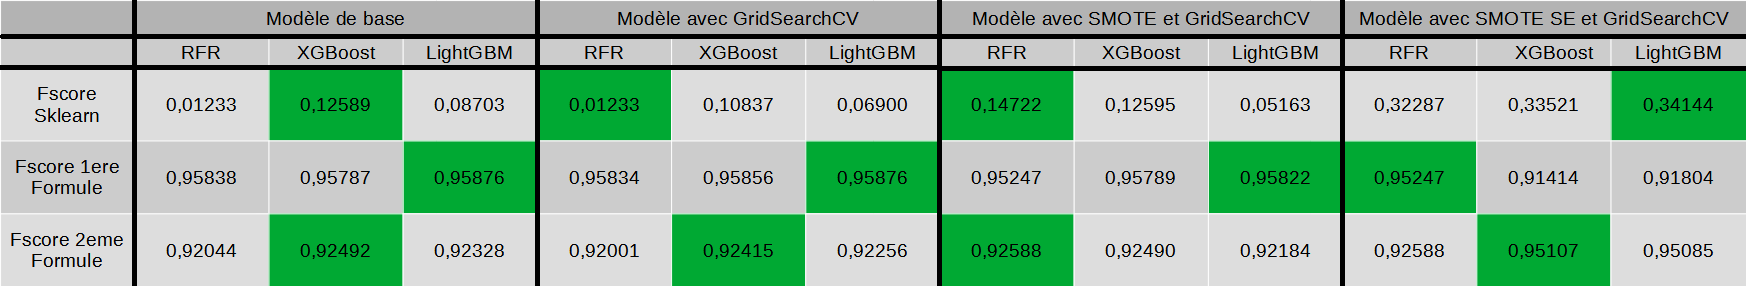

Comme précèdemment nous pouvons voir que LightGBM a de bons résultats notamment pour la 1ere formule, mais nous pouvons également voir que les résultats sont tout de même assez proche, mais pour une question de temps nous opterons pour LightGBM pour la suite.

## HyperOpt

In [ ]:
from hyperopt import hp, tpe, fmin, Trials
from sklearn.model_selection import cross_val_score

In [ ]:
space_lgbmHP = {'num_leaves' : hp.quniform('num_leaves', 20, 50, 1),
                'max_depth' : hp.quniform('max_depth', 2, 30, 1),
                'min_split_gain' : hp.quniform('min_split_gain', 0, 0.1, 0.005),
                'min_child_weight' : hp.quniform('min_child_weight', 4, 80, 2),
                'min_child_samples' : hp.quniform('min_child_samples', 4, 80, 2),
                'subsample' : hp.quniform('subsample', 0.5, 1, 0.05),
                'colsample_bytree' : hp.quniform('colsample_bytree', 0.5, 1, 0.05),
                'reg_alpha' : hp.quniform('reg_alpha', 0.1, 0.3, 0.05),
                'reg_lambda' : hp.quniform('reg_lambda', 0.1, 0.3, 0.05),
                'n_estimators' : hp.quniform('n_estimators', 200, 800, 50),
                'class_weight' : hp.choice('class_weight', [None, 'balanced']),
                'learning_rate' : hp.loguniform('learning_rate', np.log(0.005), np.log(0.2)),
                'solvability_threshold' : hp.quniform('solvability_threshold', 0.0, 1.0, 0.025)              
               }

### Metric ROC_AUC

In [ ]:
def objectiveROC_AUC(params):
    params = {'num_leaves': int(params['num_leaves']),
              'max_depth': int(params['max_depth']),
              'min_split_gain' : params['min_split_gain'],
              'min_child_weight' : int(params['min_child_weight']),
              'min_child_samples' : int(params['min_child_samples']),
              'subsample': params['subsample'],
              'colsample_bytree': params['colsample_bytree'],
              'reg_alpha': params['reg_alpha'],
              'reg_lambda': params['reg_lambda'],
              'n_estimators' : int(params['n_estimators']),
              'class_weight' : params['class_weight'],
              'learning_rate' : params['learning_rate'],
              'solvability_threshold' : params['solvability_threshold']    
             }
    
    lgbmHP = LGBMClassifier(**params)
    score = cross_val_score(lgbmHP, X_train, y_train, scoring = 'roc_auc', cv = stratified_kfold, n_jobs = -1).mean()
    return score

In [ ]:
#bestROC_AUC = fmin(fn = objectiveROC_AUC, space = space_lgbmHP, algo = tpe.suggest, max_evals=20, trials = Trials(), rstate = SEED )

In [ ]:
#bestROC_AUC

In [ ]:
#{'class_weight': 0, # 'colsample_bytree': 0.9500000000000001, # 'learning_rate': 0.1931718272383675, # 'max_depth': 18.0, # 'min_child_samples': 68.0, # 'min_child_weight': 58.0, # 'min_split_gain': 0.095, # 'n_estimators': 600.0, # 'num_leaves': 33.0, # 'reg_alpha': 0.2, # 'reg_lambda': 0.25, # 'solvability_threshold': 0.8, # 'subsample': 0.9}

In [ ]:
lgbmHP = LGBMClassifier(num_leaves = 33, max_depth = 18, min_split_gain = 0.095, min_child_weight = 58, min_child_samples = 68, subsample = 0.9, colsample_bytree = 0.9500000000000001, reg_alpha = 0.2, reg_lambda = 0.25, n_estimators = 600, class_weight = None, learning_rate = 0.1931718272383675, random_state=SEED)
lgbmHP.fit(X_train, y_train)

In [ ]:
informationModele(X_test, y_test, lgbmHP)

### Metric F1

In [ ]:
def objectiveF1Score(params):
    params = {'num_leaves': int(params['num_leaves']),
              'max_depth': int(params['max_depth']),
              'min_split_gain' : params['min_split_gain'],
              'min_child_weight' : int(params['min_child_weight']),
              'min_child_samples' : int(params['min_child_samples']),
              'subsample': params['subsample'],
              'colsample_bytree': params['colsample_bytree'],
              'reg_alpha': params['reg_alpha'],
              'reg_lambda': params['reg_lambda'],
              'n_estimators' : int(params['n_estimators']),
              'class_weight' : params['class_weight'],
              'learning_rate' : params['learning_rate']
              #'solvability_threshold' : params['solvability_threshold']    
             }
    
    lgbmHPF1 = LGBMClassifier(**params)
    score = cross_val_score(lgbmHPF1, X_train, y_train, scoring = 'f1', cv = stratified_kfold, n_jobs = -1).mean()
    return score

In [ ]:
#bestF1 = fmin(fn = objectiveROC_AUC, space = space_lgbmHP, algo = tpe.suggest, max_evals=20, trials = Trials(), rstate = SEED )

In [ ]:
#bestF1

In [ ]:
#{'class_weight': 0, # 'colsample_bytree': 0.55, # 'learning_rate': 0.14345310203344575, # 'max_depth': 25.0, # 'min_child_samples': 66.0, # 'min_child_weight': 26.0, # 'min_split_gain': 0.035, # 'n_estimators': 650.0, # 'num_leaves': 47.0, # 'reg_alpha': 0.15000000000000002, # 'reg_lambda': 0.30000000000000004, # 'solvability_threshold': 0.07500000000000001, # 'subsample': 0.7000000000000001}

In [ ]:
lgbmHPF1 = LGBMClassifier(num_leaves = 47, max_depth = 25, min_split_gain =  0.035, min_child_weight = 26, min_child_samples = 66, subsample = 0.7000000000000001, colsample_bytree = 0.55, reg_alpha = 0.15000000000000002, reg_lambda = 0.30000000000000004, n_estimators = 650, class_weight = None, learning_rate = 0.14345310203344575, random_state=SEED)
lgbmHPF1.fit(X_train, y_train)

In [ ]:
informationModele(X_test, y_test, lgbmHPF1)

### Metric ROC_AUC avec SMOTE

In [ ]:
def objectiveROC_AUCSMOTE(params):
    params = {'num_leaves': int(params['num_leaves']),
              'max_depth': int(params['max_depth']),
              'min_split_gain' : params['min_split_gain'],
              'min_child_weight' : int(params['min_child_weight']),
              'min_child_samples' : int(params['min_child_samples']),
              'subsample': params['subsample'],
              'colsample_bytree': params['colsample_bytree'],
              'reg_alpha': params['reg_alpha'],
              'reg_lambda': params['reg_lambda'],
              'n_estimators' : int(params['n_estimators']),
              'class_weight' : params['class_weight'],
              'learning_rate' : params['learning_rate']
              #'solvability_threshold' : params['solvability_threshold']    
             }
    
    lgbmHPSMOTE = LGBMClassifier(**params)
    score = cross_val_score(lgbmHPSMOTE, X_trainSMOTE, y_trainSMOTE, scoring = 'roc_auc', cv = stratified_kfold, n_jobs = -1).mean()
    return score

In [ ]:
#bestROC_AUCSMOTE = fmin(fn = objectiveROC_AUCSMOTE, space = space_lgbmHP, algo = tpe.suggest, max_evals=20, trials = Trials(), rstate = SEED )

In [ ]:
#bestROC_AUCSMOTE

In [ ]:
#{'class_weight': 0, # 'colsample_bytree': 0.65, # 'learning_rate': 0.005975355229337182, # 'max_depth': 8.0, # 'min_child_samples': 72.0, # 'min_child_weight': 30.0, # 'min_split_gain': 0.02, # 'n_estimators': 700.0, # 'num_leaves': 24.0, # 'reg_alpha': 0.2, # 'reg_lambda': 0.30000000000000004, # 'solvability_threshold': 0.325, # 'subsample': 0.5}

In [ ]:
lgbmHPSMOTE = LGBMClassifier(num_leaves = 24, max_depth = 8, min_split_gain =  0.02, min_child_weight = 30, min_child_samples = 72, subsample = 0.5, colsample_bytree = 0.65, reg_alpha = 0.2, reg_lambda = 0.30000000000000004, n_estimators = 700, class_weight = None, learning_rate = 0.005975355229337182, random_state=SEED)
lgbmHPSMOTE.fit(X_trainSMOTE, y_trainSMOTE)

In [ ]:
informationModele(X_test, y_test, lgbmHPSMOTE)

Nous pouvons voir que le score AUC est legérement moins bon qu'avec la recherche GridSearchCv, mais pour le coût métier nous regarderons tout de même ce que l'on aura.

Nous savons qu'un faux positif vaut 10x moins cher qu'un faux négatif, c'est pour ça que nous devons essayer d'avoir le moins de faux négatif possible, nous allons donc définir une nouvelle métrique.

La aussi nous utiliserons LightGBM avec recherche des hyperparamètres via GridSearchCV.

Regardons un exemple rapide de la fonction:

In [ ]:
def coutMetier(y_test, y_pred, fn_value = 10, fp_value = 1):
    tp, fn, fp, tn = confusion_matrix(y_test, y_pred).ravel()    
    scoreMetier = fn*fn_value + fp*fp_value
    return scoreMetier

Maintenant regardons ce que nous avons en modifiant le seuil des meilleurs modèles (score roc_auc = 80 càd XGBoost et LGBM avec GridSearchCv et LGBM avec SMOTE et SE etGridSearchCV):

In [ ]:
thresholds = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8, 0.81, 0.82, 0.83, 0.84, 0.85, 0.9, 0.95, 1]

In [ ]:
xgbGrid

In [ ]:
y_predXGBGRIDM = xgbGrid.predict_proba(X_test)[::,1]
y_predLGBMGRIDM = lgbmGrid.predict_proba(X_test)[::,1]

In [ ]:
coutmetier = 1000000000
listeSeuil = []

for t in thresholds:
    predicted_class1 = np.zeros(y_predXGBGRIDM.shape)
    predicted_class1[y_predXGBGRIDM > t] = 1
    coutAReduire = coutMetier(y_test, predicted_class1)
    if coutAReduire < coutmetier:
        listeSeuil.append(t)
        coutmetier = coutAReduire
    else:
        continue

In [ ]:
listeSeuil

In [ ]:
predicted_class1 = np.zeros(y_predXGBGRIDM.shape)
predicted_class1[y_predXGBGRIDM > 0.1] = 1
coutAReduire = coutMetier(y_test, predicted_class1)
print("Coût métier:", coutAReduire)

In [ ]:
coutmetier = 1000000000
listeSeuil = []

for t in thresholds:
    predicted_class1 = np.zeros(y_predLGBMGRIDM.shape)
    predicted_class1[y_predLGBMGRIDM > t] = 1
    coutAReduire = coutMetier(y_test, predicted_class1)
    if coutAReduire < coutmetier:
        listeSeuil.append(t)
        coutmetier = coutAReduire
    else:
        continue

In [ ]:
listeSeuil

In [ ]:
predicted_class1 = np.zeros(y_predLGBMGRIDM.shape)
predicted_class1[y_predLGBMGRIDM > 0.1] = 1
coutAReduire = coutMetier(y_test, predicted_class1)
print("Coût métier:", coutAReduire)

In [ ]:
y_predLGBMROC_AUCSMOTEU = grid_searchLGBM.predict_proba(X_test)[::,1]

In [ ]:
coutmetier = 1000000000
listeSeuil = []

for t in thresholds:
    predicted_class1 = np.zeros(y_predLGBMROC_AUCSMOTEU.shape)
    predicted_class1[y_predLGBMROC_AUCSMOTEU > t] = 1
    coutAReduire = coutMetier(y_test, predicted_class1)
    if coutAReduire < coutmetier:
        listeSeuil.append(t)
        coutmetier = coutAReduire
    else:
        continue

In [ ]:
listeSeuil

In [ ]:
predicted_class1 = np.zeros(y_predLGBMROC_AUCSMOTEU.shape)
predicted_class1[y_predLGBMROC_AUCSMOTEU > 0.35] = 1
coutAReduire = coutMetier(y_test, predicted_class1)
print("Coût métier:", coutAReduire)

In [ ]:
predicted_class1 = np.zeros(y_predLGBMROC_AUCSMOTEU.shape)
predicted_class1[y_predLGBMROC_AUCSMOTEU > 0.8] = 1
coutAReduire = coutMetier(y_test, predicted_class1)
print("Coût métier:", coutAReduire)

Nous avons notre coût métier au plus faible lorsque le seuil est de 0.35 et que nous prenons le modèle LightGBM avec SMOTE SE et GRidSearchCV, dans ce cas le coût métier vaut 43715.

Nous allons faire un nouvelle entraînement avec ce seuil, mais également avec un autre seuil afin de voir ce que ça donne, nous prendrons 0.35 et 0.8.

In [ ]:
sdfsdf

In [ ]:
space_lgbmHPSeuil = {'num_leaves' : hp.quniform('num_leaves', 20, 50, 1),
         'gamma' : hp.quniform('gamma', 0.1, 0.5, 0.1),
         'max_depth' : hp.quniform('max_depth', 2, 30, 1),
         'min_split_gain' : hp.quniform('min_split_gain', 0, 0.1, 0.005),
         'min_child_weight' :  hp.quniform('min_child_weight', 0, 35, 1),
         'min_child_samples' : hp.quniform('min_child_samples', 0, 80, 2),
         'subsample' : hp.quniform('subsample', 0.5, 1, 0.05),
         'colsample_bytree' : hp.quniform('colsample_bytree', 0.1, 1, 0.05),
         'reg_alpha' : hp.quniform('reg_alpha', 0.1, 1.5, 0.1),
         'reg_lambda' : hp.quniform('reg_lambda', 0.1, 1.5, 0.1),
         'n_estimators' : hp.quniform('n_estimators', 100, 800, 10),
         'class_weight' : hp.choice('class_weight', [None, 'balanced']),
         'learning_rate' : hp.quniform('learning_rate', 0.01, 0.2, 0.01),
         'solvability_threshold' : 0.35             
        }

In [ ]:
def objectiveRocAucSeuil(params):
    params = {'num_leaves': int(params['num_leaves']),
              'max_depth': int(params['max_depth']),
              'min_split_gain' : params['min_split_gain'],
              'min_child_weight' : int(params['min_child_weight']),
              'min_child_samples' : int(params['min_child_samples']),
              'subsample': params['subsample'],
              'colsample_bytree': params['colsample_bytree'],
              'reg_alpha': params['reg_alpha'],
              'reg_lambda': params['reg_lambda'],
              'n_estimators' : int(params['n_estimators']),
              'class_weight' : params['class_weight'],
              'learning_rate' : params['learning_rate'],
              'solvability_threshold' : params['solvability_threshold']    
             }
    
    lgbmHPSeuil = LGBMClassifier(**params)
    score = cross_val_score(lgbmHPSeuil, X_trainSMOTEU, y_trainSMOTEU, scoring = 'roc_auc', cv = stratified_kfold, n_jobs = -1).mean()
    return score

In [ ]:
#bestRocAucSeuil = fmin(fn = objectiveRocAucSeuil, space = space_lgbmHPSeuil, algo = tpe.suggest, max_evals = 15, trials = Trials(), rstate = SEED )

In [ ]:
#bestRocAucSeuil

 X_trainSMOTEU, y_trainSMOTEU avec ancien param pour weight et learningrate
    

{'class_weight': 0,
 'colsample_bytree': 0.8500000000000001,
 'learning_rate': 0.01,
 'max_depth': 19.0,
 'min_child_samples': 56.0,
 'min_child_weight': 2,
 'min_split_gain': 0.075,
 'n_estimators': 300.0,
 'num_leaves': 30.0,
 'reg_alpha': 0.25,
 'reg_lambda': 0.15000000000000002,
 'subsample': 0.9500000000000001}

In [ ]:
#X_train, y_train
#
#lgbmHPSeuil = LGBMClassifier(num_leaves = 37, max_depth = 17, min_split_gain =  0.065, min_child_weight = 1, min_child_samples = 52, subsample = 0.65, colsample_bytree = 0.85, reg_alpha = 0.1, reg_lambda = 0.25, n_estimators = 600, class_weight = None, learning_rate = 0.19, random_state=SEED)
#lgbmHPSeuil.fit(X_trainSMOTE, y_trainSMOTE)

In [ ]:
lgbmHPSeuil = LGBMClassifier(num_leaves = 40, max_depth = 16, min_split_gain =  0.015, min_child_weight = 34, min_child_samples = 76, subsample = 0.75, colsample_bytree = 0.2, reg_alpha = 0.6, reg_lambda = 1.1, n_estimators = 650, class_weight = None, learning_rate = 0.17, random_state=SEED)
lgbmHPSeuil.fit(X_train, y_train)

In [ ]:
informationModele(X_test, y_test, lgbmHPSeuil)

In [ ]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(lgbmHPSeuil, X_test, y_test)

Regardons ce que nous obtenons en modifiant le seuil, en prenant un autre taux (0.8) à la place de 0.1:

In [ ]:
space80 = {'num_leaves' : hp.quniform('num_leaves', 20, 50, 1),
         'gamma' : hp.quniform('gamma', 0.1, 0.5, 0.1),
         'max_depth' : hp.quniform('max_depth', 2, 30, 1),
         'min_split_gain' : hp.quniform('min_split_gain', 0, 0.1, 0.005),
         'min_child_weight' :  hp.quniform('min_child_weight', 0, 35, 1),
         'min_child_samples' : hp.quniform('min_child_samples', 0, 80, 2),
         'subsample' : hp.quniform('subsample', 0.5, 1, 0.05),
         'colsample_bytree' : hp.quniform('colsample_bytree', 0.1, 1, 0.05),
         'reg_alpha' : hp.quniform('reg_alpha', 0.1, 1.5, 0.1),
         'reg_lambda' : hp.quniform('reg_lambda', 0.1, 1.5, 0.1),
         'n_estimators' : hp.quniform('n_estimators', 100, 800, 10),
         'class_weight' : hp.choice('class_weight', [None, 'balanced']),
         'learning_rate' : hp.quniform('learning_rate', 0.01, 0.2, 0.01),
         'solvability_threshold' : 0.80             
        }

trials = Trials()

In [ ]:
def objectiveSeuil80(space80):
    params = {'num_leaves': int(space80['num_leaves']),
              'gamma' : space80['gamma'],
              'max_depth': int(space80['max_depth']),
              'min_split_gain' : space80['min_split_gain'],
              'min_child_weight' : int(space80['min_child_weight']),
              'min_child_samples' : int(space80['min_child_samples']),
              'subsample': space80['subsample'],
              'colsample_bytree': space80['colsample_bytree'],
              'reg_alpha': space80['reg_alpha'],
              'reg_lambda': space80['reg_lambda'],
              'n_estimators' : int(space80['n_estimators']),
              'class_weight' : space80['class_weight'],
              'learning_rate' : space80['learning_rate'],
              'solvability_threshold' : space80['solvability_threshold']    
             }
    
    lgbmHPSeuil80 = LGBMClassifier(**params)
    score = -cross_val_score(lgbmHPSeuil80,  X_trainSMOTEU, y_trainSMOTEU, scoring = 'roc_auc', cv = stratified_kfold, n_jobs = -1).mean()
    return score

In [ ]:
#bestSeuil80 = fmin(fn = objectiveSeuil80, space = space80, algo = tpe.suggest, max_evals = 15, trials = Trials(), rstate = SEED )

In [ ]:
#bestSeuil80

X_train, y_train

{'class_weight': 0,
 'colsample_bytree': 0.2,
 'gamma': 0.1,
 'learning_rate': 0.024619870765448686,
 'max_depth': 27.0,
 'min_child_samples': 72.0,
 'min_child_weight': 4.0,
 'min_split_gain': 0.075,
 'n_estimators': 650.0,
 'num_leaves': 28.0,
 'reg_alpha': 1.1,
 'reg_lambda': 0.7000000000000001,
 'subsample': 0.8500000000000001}

In [ ]:
lgbmHPSeuil80 = LGBMClassifier(num_leaves = 24, max_depth = 21, min_split_gain =  0.01, min_child_weight = 0, min_child_samples = 38, subsample = 0.65, colsample_bytree = 0.8, reg_alpha = 1.2, reg_lambda = 1.3, n_estimators = 740, class_weight = 'balanced', learning_rate = 0.03566585075786466, random_state=SEED)
lgbmHPSeuil80.fit(X_train, y_train)

In [ ]:
informationModele(X_test, y_test, lgbmHPSeuil80)

Comme nous pouvons le voir nous avons bien diminué le nombre de faux positif, nous avons 6786 FN avec le seuil 0.1 à la place 7045 FN avec le seuil 0.8.

Regardons les variables les plus importantes:

In [ ]:
featureImportances = lgbmHPSeuil.feature_importances_
colonneDataframe = train_data.columns

topFeature = np.argsort(featureImportances)[::-1][:25]
topFeatureImportances = featureImportances[topFeature]
nomVariable = colonneDataframe[topFeatureImportances]
        
plt.figure(figsize = (10, 10)) 
sns.barplot(x = topFeatureImportances, y = list(range(25)), orient = 'h')
plt.yticks(list(range(25)), nomVariable)
plt.title('Les 25 variables les plus importantes')
plt.xlabel('Importance de la variable')
plt.ylabel('Nom de la variable')
plt.show()

In [ ]:
space80W = {'num_leaves' : hp.quniform('num_leaves', 20, 50, 1),
         'gamma' : hp.quniform('gamma', 0.1, 0.5, 0.1),
         'max_depth' : hp.quniform('max_depth', 2, 30, 1),
         'min_split_gain' : hp.quniform('min_split_gain', 0, 0.1, 0.005),
         'min_child_weight' :  hp.quniform('min_child_weight', 0, 35, 1),
         'min_child_samples' : hp.quniform('min_child_samples', 0, 80, 2),
         'subsample' : hp.quniform('subsample', 0.5, 1, 0.05),
         'colsample_bytree' : hp.quniform('colsample_bytree', 0.1, 1, 0.05),
         'reg_alpha' : hp.quniform('reg_alpha', 0.1, 1.5, 0.1),
         'reg_lambda' : hp.quniform('reg_lambda', 0.1, 1.5, 0.1),
         'n_estimators' : hp.quniform('n_estimators', 100, 800, 10),
         'class_weight' : hp.choice('class_weight', [None, 'balanced']),
         'learning_rate' : hp.loguniform('learning_rate', -4, -1),
         'solvability_threshold' : 0.80             
        }

trials = Trials()

def objectiveSeuil80W(space80W):
    params = {'num_leaves': int(space80W['num_leaves']),
              'gamma' : space80W['gamma'],
              'max_depth': int(space80W['max_depth']),
              'min_split_gain' : space80W['min_split_gain'],
              'min_child_weight' : int(space80W['min_child_weight']),
              'min_child_samples' : int(space80W['min_child_samples']),
              'subsample': space80W['subsample'],
              'colsample_bytree': space80W['colsample_bytree'],
              'reg_alpha': space80W['reg_alpha'],
              'reg_lambda': space80W['reg_lambda'],
              'n_estimators' : int(space80W['n_estimators']),
              'class_weight' : space80W['class_weight'],
              'learning_rate' : space80W['learning_rate'],
              'solvability_threshold' : space80W['solvability_threshold']    
             }
    
    lgbmHPSeuil80W = LGBMClassifier(**params)
    score = -cross_val_score(lgbmHPSeuil80W, X_train, y_train, scoring = 'roc_auc', cv = stratified_kfold, n_jobs = -1).mean()
    return score

bestSeuil80W = fmin(fn = objectiveSeuil80W, space = space80W, algo = tpe.suggest, max_evals = 15, trials = Trials(), rstate = SEED )

In [ ]:
bestSeuil80W 

In [ ]:
sdfsdf

In [ ]:
from sklearn.feature_selection import RFECV
from sklearn.svm import SVR

estimator = SVR(kernel="linear")
selector = RFECV(estimator, min_features_to_select = 500, step = 15, cv = stratified_kfold, n_jobs = -1)
selector = selector.fit(train_data, target_train)
selector.support_
selector.ranking_

In [ ]:
#regressor = LinearRegression()
#feature_selector = RFECV(regressor)
#
#fit = feature_selector.fit(X,y)

optimal_feature_count = selector.n_features_
print(f"Optimal numer of features: {optimal_feature_count}")

X_new = train_data.loc[:, selector.get_support()]

plt.plot(range(1, len(selector.grid_scores_) + 1), selector.grid_scores_, marker = "o")
plt.ylabel("Model Score")
plt.xlabel("Number of Features")
plt.title(f"Feature Selection using RFE \n Optimal number of features is {optimal_feature_count} (at score of {round(max(selector.grid_scores_), 4)})")
plt.tight_layout() 
plt.show()

In [ ]:
regressor = LinearRegression()
feature_selector = RFECV(regressor)

fit = feature_selector.fit(train_data, target_train)

optimal_feature_count = feature_selector.n_features_
print(f"Optimal numer of features: {optimal_feature_count}")

X_new = train_data.loc[:, feature_selector.get_support()]

plt.plot(range(1, len(fit.grid_scores_) + 1), fit.grid_scores_, marker = "o")
plt.ylabel("Model Score")
plt.xlabel("Number of Features")
plt.title(f"Feature Selection using RFE \n Optimal number of features is {optimal_feature_count} (at score of {round(max(fit.grid_scores_), 4)})")
plt.tight_layout() 
plt.show()